# Purchase card transactions for the Brimingham City Council Project

We follow the Data Analysis process which includes 6 main steps, but we will include just the firs 5 ones (since we are not going to deploy the product):

1. Business Questions
2. Data collection
3. Exploratory Data Analysis
4. Modeling
5. Evaluating


## 1. Business Questions

For this project we are using a historical dataset wich includes a collection of purchase card transactions for the Birmingham City Council.

There are several important tasks which can be performed in order to get the most of the available data.

### 1.1 We list the possible tasks that could be performed and are interesting enough to be analyzed and taked into account for this project:

1. (Clustering) Discovering profiles.
2. (Anomalies detection) Unusual activities.
3. (Forecasting) Predicting future transactional behaviors (Next purchase, Expenditures forecasting, etc.)
4. (Creativity) Stating a problem that may be solved using the available data.

### 1.2 By taking into account these tasks we establish a series of important questions which could be answered by following the Data Analysis Process stated previously.

1. Clustering: a) which are the all around purchase card transactions' profiles?, b) which are the credit card customers' profiles?, c) which are the merchants' profiles?
2. Anomalies detection: a) which transactions are unusual and may be fraudulent?
3. Forecasting: what would the next purchase be for a particular client?, b) how much would a client expend in the next period (days, month, years)?, c) how much would be the income for a particular merchant in the next period (days, months, years)?
4. Creativity: Classification: Taking into account a time frame: a) what would be, for a card transaction, the most probable type of consumption (Vehicle Fuel, Hospitality, Food, Accomodation, etc.)?, b) what would be, for a customer, the most probable type of consumption (Vehicle Fuel, Hospitality, Food, Accomodation, etc.)?, c) what would be, for a card transaction, the most probable company in which the money will be spent?, d) what would be, for a customer, the most probable company in which he/she would spend his/her money?, e) what would be the most probable card transaction associated directorate?, f) what would be the most probable card transaction Value Added Tax (VAT)?

Although these are the main questions that any data scientist may try to answer by exploring, cleaning and analyzing the available data, for the purpose of this test, we will focus on three specific questions:

1) Clustering: 
    a) which are the credit card customers' profiles for the year 2014?
    b) which are the all around purchase card transactions' profiles for the year 2014?

2) Classification: what would be, for a client, the most probable type of consumption for the year 2014?

Even though we will be answering these three questions using several models (unsupervised and supervised) we need to collect the data and do an exploratory analysis. During this EDA we will observe, gain insights, clean, fix and perform other activities related, not only to the 3 main tasks in hand, but looking further, towards preparing the data so many other questions, related to other tasks, could be answered. Since the scope of this test is not that broad we will focus on the three previously presented questions.

## 2. Data Collection

### 2.1 Importing the necessary libraries

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from kmodes.kmodes import KModes
from difflib import SequenceMatcher
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score, silhouette_samples, silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster



### 2.2 Merging the data by years

We define a function that will take the months, the years, all the xls files and the path to where the files are saved in order to obtain a list of the dataframes that will include the information per year.

In [2]:
def merging_xls_in_df(months, years, files, path):
    dfs = list()
    for y in years:
        df = pd.DataFrame()
        for m in months:
            for f in files:
                if f.endswith(".xls") and m in f and y in f:
                    df = df.append(pd.read_excel(path+'/'+f, parse_dates = True))
        dfs.append(df)
    return dfs

We declare the lists of months, years and files as well as the path in which the files will be found in order to be opened and included in each particular dataframe per year

In [3]:
months = ['jan','feb','mar','apr','may','jun','jul','aug','sept','oct','nov','dec']
years = ['2014','2015','2016','2017','2018']
destdir = '/Users/andresaristi/Documents/BirminghamCardTransactions/dataset'
files = [ f for f in os.listdir(destdir) if os.path.isfile(os.path.join(destdir,f)) ] 

We obtain the list of dataframes per year and later we take out 5 dataframes (2014, 2015, 2016, 2017, and 2018). 

We will take these 5 dataframes and we will apply the Exploratory Data Analysis to each of them in order to try to  understand the clients or the merchants by means of a clustering algorithm, for example, in a time frame of a year. Also we may want to use just one year to classify clients or companies (for example) as we already explained in our business questions' section. 

We will also concatenate the 5 dataframes in order to obtain more data so we may be able to perform some forecasting. It does not mean that we cannot do forecasting with information of just one year, but we may find more interesting patterns with data in a longer time frame.

We highlight the fact that we do not have the information related to december of 2017, since this csv file involves information not related to the business.

We add 2015 to the purchase card transactions xls files of february and march in order for our merging function to work according to plan.

In [4]:
dfs = merging_xls_in_df(months, years, files, destdir)
df2014 = dfs[0]
df2015 = dfs[1]
df2016 = dfs[2]
df2017 = dfs[3]
df2018 = dfs[4]
df = pd.concat([df2014,df2015,df2016,df2017,df2018])

We save the list of dataframes in a .pkl file

In [5]:
dfs_pkl_filename = '/Users/andresaristi/Documents/BirminghamCardTransactions/pickle_files/dfs.pkl'
dfs_pkl = open(dfs_pkl_filename, 'wb')
pickle.dump(dfs, dfs_pkl)
dfs_pkl.close()

We show that the file for december 2017 does not have anything in common with the other xls files, so it cannot be taked into account for the analysis.

In [6]:
dfdecember2017 = pd.read_csv(destdir+'/'+'open_data_planning_weekly_list.csv')
dfdecember2017.head()

REFERENCE     Category Received_Date  \
0  2018/00188/PA  Householder    11/01/2018   
1  2017/10761/PA       Advert    18/12/2017   
2  2018/00011/PA  Householder    03/01/2018   
3  2018/00117/PA  Householder    08/01/2018   
4  2018/00191/PA  Householder    11/01/2018   

                                            LOCATION  \
0  120 Oakfield Road, Selly Oak, Birmingham, B29 7ED   
1  Arya International Mini Market, 568 Bristol Ro...   
2               16 Wyvern Grove, Birmingham, B29 6RN   
3    9 Naunton Close, Selly Oak, Birmingham, B29 4DX   
4  145 Lichfield Road, Four Oaks, Sutton Coldfiel...   

                                                 DEV    Accepted  \
0  Replacement doors and windows, external insula...  11/01/2018   
1   Retention of internally illuminated ATM surround  11/01/2018   
2           Erection of single storey rear extension  10/01/2018   
3             Erection of two storey front extension  12/01/2018   
4    Erection of two storey side and rear extensions  11/01/2018   

                                           APPLICANT  \
0  Mr and Mrs M Webb,120 Oakfield Road, Selly Oak...   
1  Cardtronics UK Ltd T/A Cashzone,PO Box 476, Ha...   
2   Mr J Foxall,16 Wyvern Grove, Birmingham, B29 6RN   
3  Mr Jose Sodre,9 Naunton Close, Selly Oak, Birm...   
4  Mr Andrew Haslehurst,145 Lichfield Road, Four ...   

                                               AGENT              WARD  geom  
0  Architecture For You, 236 Franklin Road, Bourn...         Selly Oak   NaN  
1  Des Ager Design & Planning Consultant, 1 Turne...         Selly Oak   NaN  
2  Anglian Home Improvements, National Administra...         Selly Oak   NaN  
3                                                 ,             Weoley   NaN  
4  K G Bramwell MCIAT, 65 Brookhus Farm Road, Wal...  Sutton Four Oaks   NaN

## 3. Exploratory Data Analysis

As stated before, we are going to do an EDA for the 2014 dataframe. This in order to be able to do different kind of analysis.

### 3.1 Dataframe year 2014

We return the first 5 rows (observations or data points) sorted by transaction date in order to see the different features involved in this dataframe. We can observe 12 features. Later on we will se that we can establish our transaction date as our index instead of our predefined numeric index. 

In [7]:
df2014.sort_values(by='TRANS DATE').head()

TRANS DATE TRANS VAT DESC  ORIGINAL GROSS AMT             MERCHANT NAME  \
28   2013-11-12             VR             -594.00    www.pcc.nhs.uk/eventma   
2316 2014-03-06             VR               98.33  bp snax 24 weoley castle   
1679 2014-03-27             VZ              -10.54        asda home delivery   
2291 2014-04-01             VR               94.93     bp snax 24 cofton 859   
682  2014-04-02             VZ              200.00          surveymonkey.com   

           CARD NUMBER BILLING CUR CODE TRANS CAC CODE 1   TRANS CAC DESC 1  \
28    ************7557              GBP             L100  Equip Operational   
2316  ************5353              GBP             K020       Vehicle Fuel   
1679  ************9410              GBP             L220     Purchases Food   
2291  ************5044              GBP             K020       Vehicle Fuel   
682   ************4084              GBP             L9Y0    Computing Other   

     TRANS CAC CODE 2              TRANS CAC DESC 2 TRANS CAC CODE 3  \
28              RVA0K                 Admin Support              A00   
2316            RHAAC      E'baston CBHO 1 C'takers              A00   
1679            REAJP  Perry Common Junior & Infant              A00   
2291            RHF03           Northfield Hsg Mgmt              A00   
682             RVP0J             CP Cwide Team Bus              A00   

              Directorate  
28    Adult & Communities  
2316       Local Services  
1679        CYP&F SCHOOLS  
2291       Local Services  
682                 CYP&F

We confirm the amount of 12 features and find out that we are dealing with a dataset of 34467 data points.

In [8]:
df2014.shape

(34467, 12)

We found out that there are certain missing values for some of our features:

- TRANS VAT DESC: 677
- TRANS CAC CODE 1: 1
- TRANS CAC DESC 1: 1
- TRANS CAC CODE 2: 9
- TRANS CAC DESC 2: 9
- TRANS CAC CODE 3: 12

In [9]:
df2014.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34467 entries, 0 to 3292
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   TRANS DATE          34467 non-null  datetime64[ns]
 1   TRANS VAT DESC      33790 non-null  object        
 2   ORIGINAL GROSS AMT  34467 non-null  float64       
 3   MERCHANT NAME       34467 non-null  object        
 4   CARD NUMBER         34467 non-null  object        
 5   BILLING CUR CODE    34467 non-null  object        
 6   TRANS CAC CODE 1    34466 non-null  object        
 7   TRANS CAC DESC 1    34466 non-null  object        
 8   TRANS CAC CODE 2    34458 non-null  object        
 9   TRANS CAC DESC 2    34458 non-null  object        
 10  TRANS CAC CODE 3    34455 non-null  object        
 11  Directorate         34467 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 3.4+ MB


We are going to try to find some patterns related to those missing values.

In [10]:
df2014[df2014['TRANS VAT DESC'].isna()].head(20)

TRANS DATE TRANS VAT DESC  ORIGINAL GROSS AMT       MERCHANT NAME  \
981  2014-04-11            NaN               52.81       w m morrisons   
1024 2014-04-28            NaN               75.03   js online grocery   
1030 2014-04-07            NaN              282.26              viking   
1039 2014-04-24            NaN               40.11   js online grocery   
1040 2014-04-17            NaN               82.74   js online grocery   
1041 2014-04-16            NaN               45.75   js online grocery   
1043 2014-04-10            NaN               50.48   js online grocery   
1046 2014-04-03            NaN               80.81   js online grocery   
1067 2014-05-01            NaN               10.91   tesco stores 6227   
1069 2014-04-28            NaN               19.61   tesco stores 6227   
1070 2014-04-08            NaN               10.12   tesco stores 6227   
1075 2014-04-10            NaN                3.58   tesco stores 5207   
1102 2014-04-10            NaN               43.18       w m morrisons   
1186 2014-04-04            NaN               41.78   sainsbury's s/mkt   
1233 2014-04-17            NaN               37.55           mcdonalds   
1242 2014-04-08            NaN              124.47        waitrose 150   
1256 2014-04-07            NaN              137.64  asda home delivery   
1277 2014-04-15            NaN              746.75    makro deliveries   
1343 2014-04-04            NaN              162.10   tesco stores 5854   
1352 2014-04-28            NaN              153.49    post office shop   

           CARD NUMBER BILLING CUR CODE TRANS CAC CODE 1    TRANS CAC DESC 1  \
981   ************7911              GBP             M900         Hospitality   
1024  ************0073              GBP             L220      Purchases Food   
1030  ************0065              GBP             L420          Stationery   
1039  ************9807              GBP             L220      Purchases Food   
1040  ************9807              GBP             L220      Purchases Food   
1041  ************9807              GBP             L220      Purchases Food   
1043  ************9807              GBP             L220      Purchases Food   
1046  ************9807              GBP             L220      Purchases Food   
1067  ************1490              GBP             L220      Purchases Food   
1069  ************1490              GBP             L220      Purchases Food   
1070  ************1490              GBP             L220      Purchases Food   
1075  ************4886              GBP             L220      Purchases Food   
1102  ************6741              GBP             L100   Equip Operational   
1186  ************3783              GBP             L220      Purchases Food   
1233  ************5752              GBP             M900         Hospitality   
1242  ************3759              GBP             L100   Equip Operational   
1256  ************1339              GBP             L220      Purchases Food   
1277  ************1436              GBP             MC70  Supplies & Sev Mic   
1343  ************9520              GBP             L220      Purchases Food   
1352  ************6976              GBP             MC70  Supplies & Sev Mic   

     TRANS CAC CODE 2                    TRANS CAC DESC 2 TRANS CAC CODE 3  \
981             REARM                       Wyndcliffe JI              A00   
1024            REAAB       The City of Birmingham School              A00   
1030            REAAB       The City of Birmingham School              A00   
1039            REARK                     Wychall Farm JI              A5F   
1040            REARK                     Wychall Farm JI              A5F   
1041            REARK                     Wychall Farm JI              A00   
1043            REARK                     Wychall Farm JI              A5F   
1046            REARK                     Wychall Farm JI              A5F   
1067            REAAB       The City of Birmingham School          

Since we do not see a clear pattern, and at the moment the VAT (Value Added Tax) seems like an interesting feature (for instance, a classification task), and we do not want to eliminate rows so soon (it is just a 2% of the data), we decide to establish another category as 'other'.

In [11]:
df2014.loc[df2014['TRANS VAT DESC'].isna(),'TRANS VAT DESC'] = 'other'

In [12]:
df2014.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34467 entries, 0 to 3292
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   TRANS DATE          34467 non-null  datetime64[ns]
 1   TRANS VAT DESC      34467 non-null  object        
 2   ORIGINAL GROSS AMT  34467 non-null  float64       
 3   MERCHANT NAME       34467 non-null  object        
 4   CARD NUMBER         34467 non-null  object        
 5   BILLING CUR CODE    34467 non-null  object        
 6   TRANS CAC CODE 1    34466 non-null  object        
 7   TRANS CAC DESC 1    34466 non-null  object        
 8   TRANS CAC CODE 2    34458 non-null  object        
 9   TRANS CAC DESC 2    34458 non-null  object        
 10  TRANS CAC CODE 3    34455 non-null  object        
 11  Directorate         34467 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 3.4+ MB


Since the amount of missing values for the other features does not seeem considerable, we eliminate the rows.

In [13]:
df2014 = df2014[~df2014['TRANS CAC CODE 1'].isna()]
df2014 = df2014[~df2014['TRANS CAC DESC 1'].isna()]
df2014 = df2014[~df2014['TRANS CAC CODE 2'].isna()]
df2014 = df2014[~df2014['TRANS CAC DESC 2'].isna()]
df2014 = df2014[~df2014['TRANS CAC CODE 3'].isna()]

In [14]:
df2014.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34453 entries, 0 to 3292
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   TRANS DATE          34453 non-null  datetime64[ns]
 1   TRANS VAT DESC      34453 non-null  object        
 2   ORIGINAL GROSS AMT  34453 non-null  float64       
 3   MERCHANT NAME       34453 non-null  object        
 4   CARD NUMBER         34453 non-null  object        
 5   BILLING CUR CODE    34453 non-null  object        
 6   TRANS CAC CODE 1    34453 non-null  object        
 7   TRANS CAC DESC 1    34453 non-null  object        
 8   TRANS CAC CODE 2    34453 non-null  object        
 9   TRANS CAC DESC 2    34453 non-null  object        
 10  TRANS CAC CODE 3    34453 non-null  object        
 11  Directorate         34453 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 3.4+ MB


In [15]:
df2014.describe(include='all').T

count unique                                     top  \
TRANS DATE            34453    253                     2014-06-11 00:00:00   
TRANS VAT DESC        34453      8                                      VZ   
ORIGINAL GROSS AMT  34453.0    NaN                                     NaN   
MERCHANT NAME         34453   4716                    amazon mktplce eu-uk   
CARD NUMBER           34453    993                        ************5412   
BILLING CUR CODE      34453      1                                     GBP   
TRANS CAC CODE 1      34453     96                                    K020   
TRANS CAC DESC 1      34453     96                            Vehicle Fuel   
TRANS CAC CODE 2      34453    816                                   RUF0F   
TRANS CAC DESC 2      34453    810  Illegal Money Lending T Stds Comm Inv.   
TRANS CAC CODE 3      34453     23                                     A00   
Directorate           34453     12                           CYP&F SCHOOLS   

                     freq      first       last        mean          std  \
TRANS DATE            473 2013-11-12 2015-01-01         NaN          NaN   
TRANS VAT DESC      17533        NaT        NaT         NaN          NaN   
ORIGINAL GROSS AMT    NaN        NaT        NaT  162.580459  1959.630681   
MERCHANT NAME        4113        NaT        NaT         NaN          NaN   
CARD NUMBER           325        NaT        NaT         NaN          NaN   
BILLING CUR CODE    34453        NaT        NaT         NaN          NaN   
TRANS CAC CODE 1     5396        NaT        NaT         NaN          NaN   
TRANS CAC DESC 1     5396        NaT        NaT         NaN          NaN   
TRANS CAC CODE 2     3276        NaT        NaT         NaN          NaN   
TRANS CAC DESC 2     3276        NaT        NaT         NaN          NaN   
TRANS CAC CODE 3    33971        NaT        NaT         NaN          NaN   
Directorate         15605        NaT        NaT         NaN          NaN   

                       min    25%    50%    75%       max  
TRANS DATE             NaN    NaN    NaN    NaN       NaN  
TRANS VAT DESC         NaN    NaN    NaN    NaN       NaN  
ORIGINAL GROSS AMT -6794.0  12.66  39.92  84.76  92379.56  
MERCHANT NAME          NaN    NaN    NaN    NaN       NaN  
CARD NUMBER            NaN    NaN    NaN    NaN       NaN  
BILLING CUR CODE       NaN    NaN    NaN    NaN       NaN  
TRANS CAC CODE 1       NaN    NaN    NaN    NaN       NaN  
TRANS CAC DESC 1       NaN    NaN    NaN    NaN       NaN  
TRANS CAC CODE 2       NaN    NaN    NaN    NaN       NaN  
TRANS CAC DESC 2       NaN    NaN    NaN    NaN       NaN  
TRANS CAC CODE 3       NaN    NaN    NaN    NaN       NaN  
Directorate            NaN    NaN    NaN    NaN       NaN

We want to understand the distribution of a possible dependant cateorical value if we were to do card transaction's classification, per year, related to directorates, as well as its baseline.

<AxesSubplot:xlabel='Directorate', ylabel='count'>

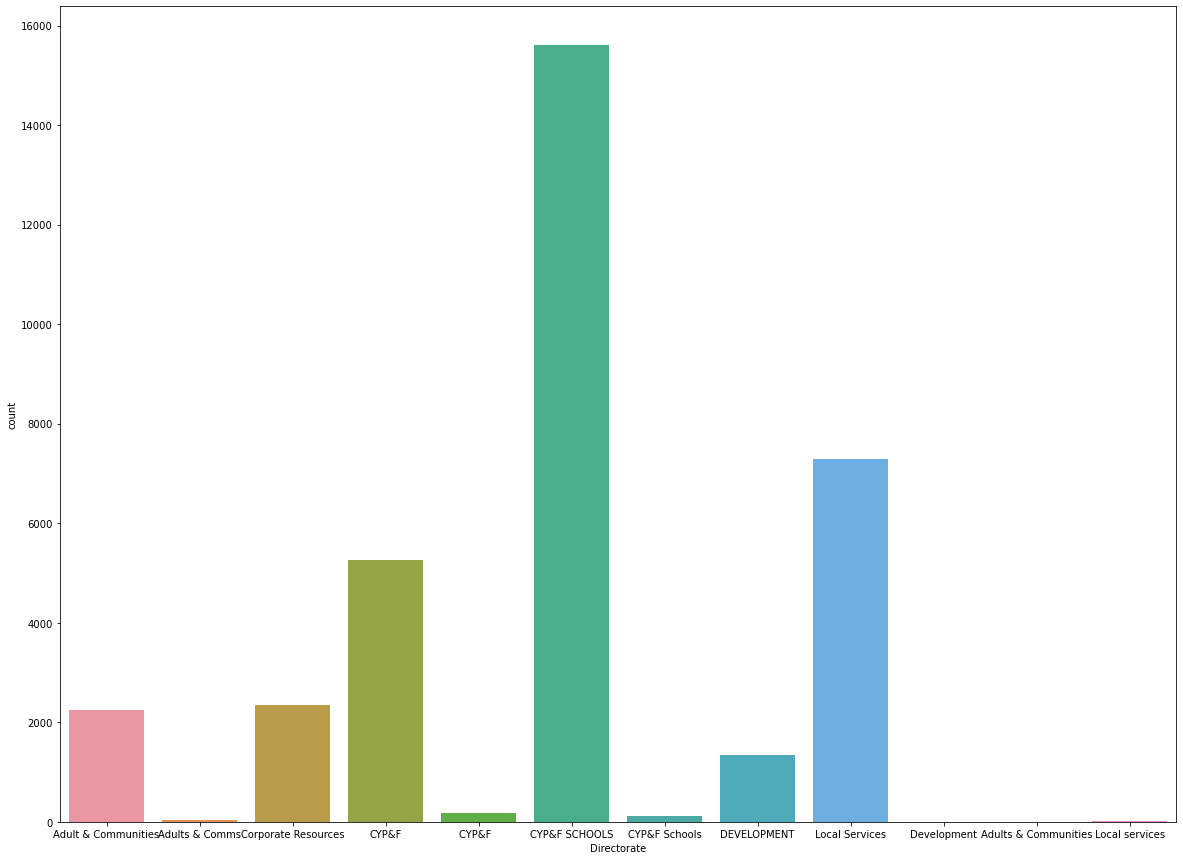

In [16]:
plt.figure(figsize=(20,15))
sns.countplot(x='Directorate',data=df2014)

In [17]:
pd.crosstab(index=df2014['Directorate'],columns='count')

col_0                 count
Directorate                
Adult & Communities    2256
Adults & Comms           33
Adults & Communities      6
CYP&F                  5261
CYP&F                   183
CYP&F SCHOOLS         15605
CYP&F Schools           116
Corporate Resources    2351
DEVELOPMENT            1340
Development               2
Local Services         7289
Local services           11

We found out that there are redundant categories that we must fusion in order to have a clearer view of the real directorates involved in the card transactions. 

We check that the values are indeed related and the difference between the previous categories where typos (checking the xls files).

In [18]:
df2014.loc[df2014['Directorate'] == 'Adults & Comms','Directorate'] = 'Adult & Communities'
df2014.loc[df2014['Directorate'] == 'Adults & Communities','Directorate'] = 'Adult & Communities'
df2014.loc[df2014['Directorate'] == 'CYP&F  ','Directorate'] = 'CYP&F'
df2014.loc[df2014['Directorate'] == 'CYP&F Schools','Directorate'] = 'CYP&F SCHOOLS'
df2014.loc[df2014['Directorate'] == 'Development','Directorate'] = 'DEVELOPMENT'
df2014.loc[df2014['Directorate'] == 'Local services','Directorate'] = 'Local Services'

<AxesSubplot:xlabel='Directorate', ylabel='count'>

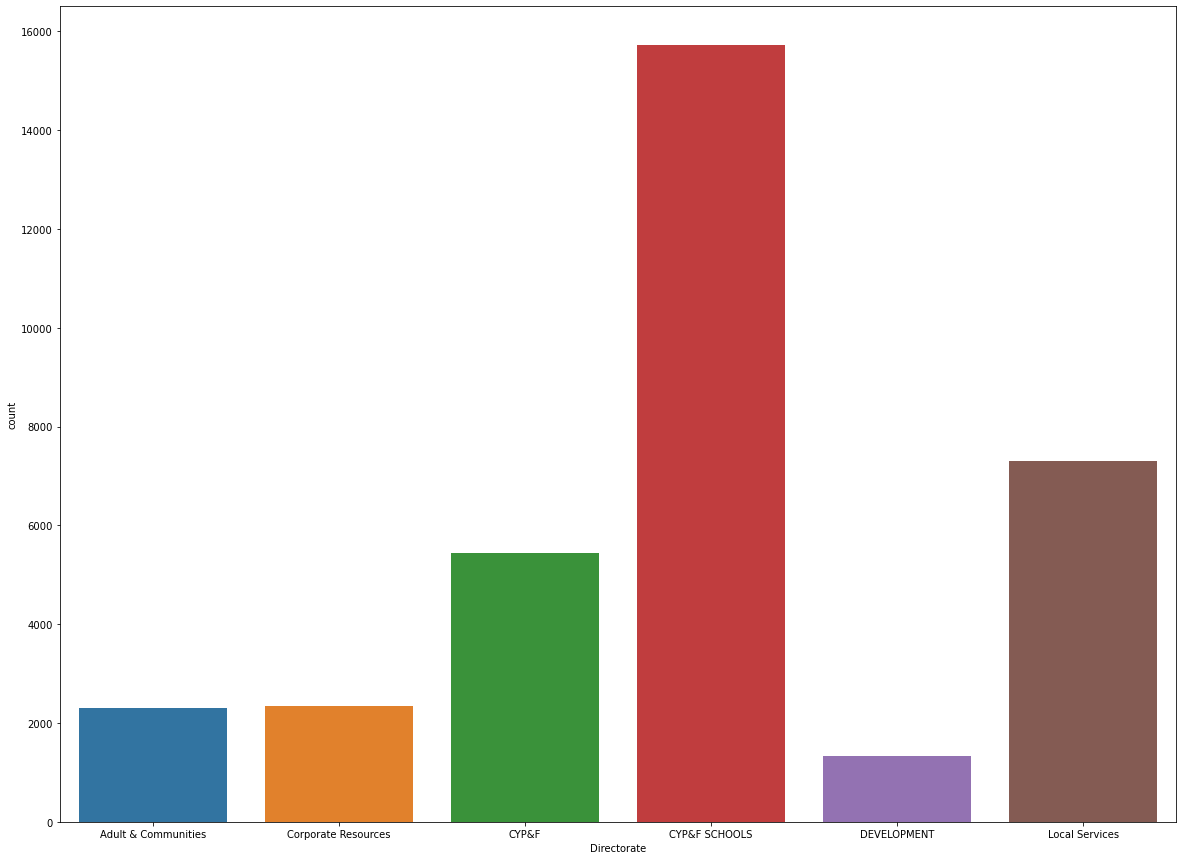

In [19]:
plt.figure(figsize=(20,15))
sns.countplot(x='Directorate',data=df2014)

In [20]:
pd.crosstab(index=df2014['Directorate'],columns='count')

col_0                count
Directorate               
Adult & Communities   2295
CYP&F                 5444
CYP&F SCHOOLS        15721
Corporate Resources   2351
DEVELOPMENT           1342
Local Services        7300

We found out a baseline of 45.63% (for directorates) for the year of 2014

In [21]:
df2014['Directorate'][df2014['Directorate'] == 'CYP&F SCHOOLS'].count()/df2014.shape[0]*100

45.63027893071721

<AxesSubplot:xlabel='TRANS VAT DESC', ylabel='count'>

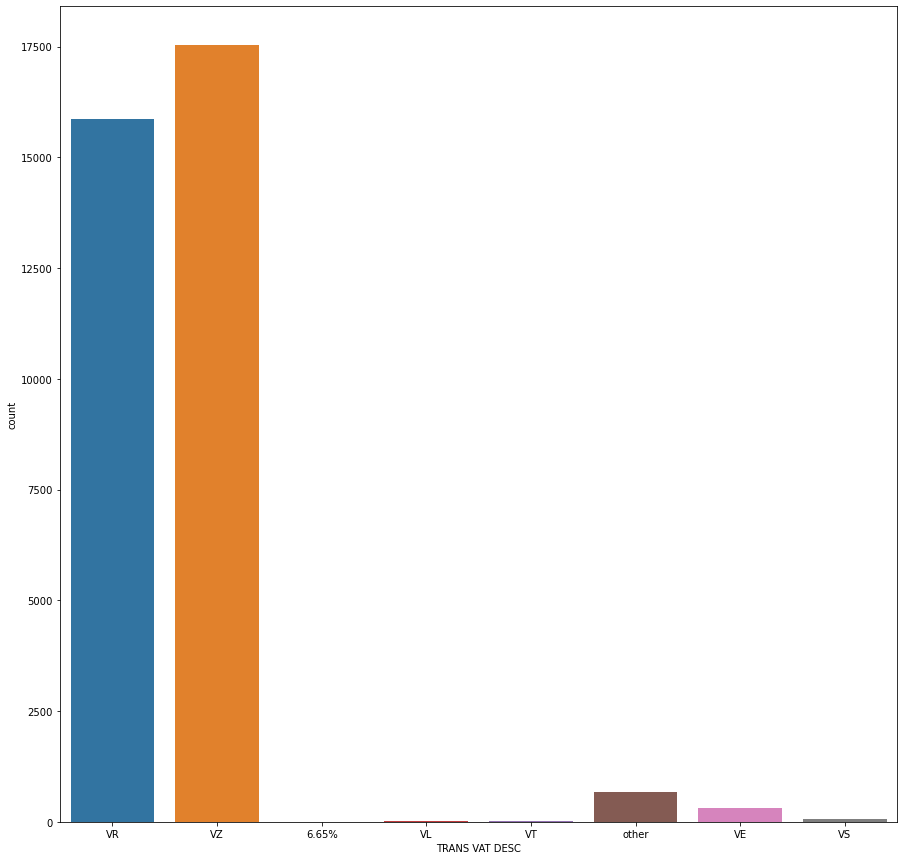

In [22]:
plt.figure(figsize=(15,15))
sns.countplot(x='TRANS VAT DESC',data=df2014)

We must enfasize on the importance of the meaning of each acronym mentioned in the previous bar plot.

Firstly, we would indicate that VAT is the Value-Added-Tax. In this dataset they use several categories to identify the applied tax for each transaction.

- VR: Standard rate (20%)
- VZ: Zero rate (0%)
- 6.65% rate
- VL: Lower (or reduced) rate (5%)
- VE: Exempt

According to the document of Schools Financial Procedures Manual from the Birmingham City Council

There is no data dictionary document stating the meaning of VT and VS, and 64 datapoints is just the 0.19% of the total amount of rows.

Also, since the amount of data points with VAT 6.65%, VE and VL is not significative (364, which is a 0.91%), and altogether, with the previous categories of VT and VS, it only gives us a 1.1%, we wil merge them with the 'other' category.

In [23]:
amount_of_VT_VS = df2014[df2014['TRANS VAT DESC'].isin(['VT','VS'])]['TRANS VAT DESC'].count()
amount_of_VT_VS

64

In [24]:
amount_of_VE_VL_665 = df2014[df2014['TRANS VAT DESC'].isin(['VE','VL','6.65'])]['TRANS VAT DESC'].count()
amount_of_VE_VL_665

316

In [25]:
df2014.loc[df2014['TRANS VAT DESC'].isin(['VT','VS','VE','VL','6.65%']),'TRANS VAT DESC'] = 'other'

In [26]:
pd.crosstab(index=df2014['TRANS VAT DESC'],columns='count')

col_0           count
TRANS VAT DESC       
VR              15858
VZ              17533
other            1062

<AxesSubplot:xlabel='TRANS VAT DESC', ylabel='count'>

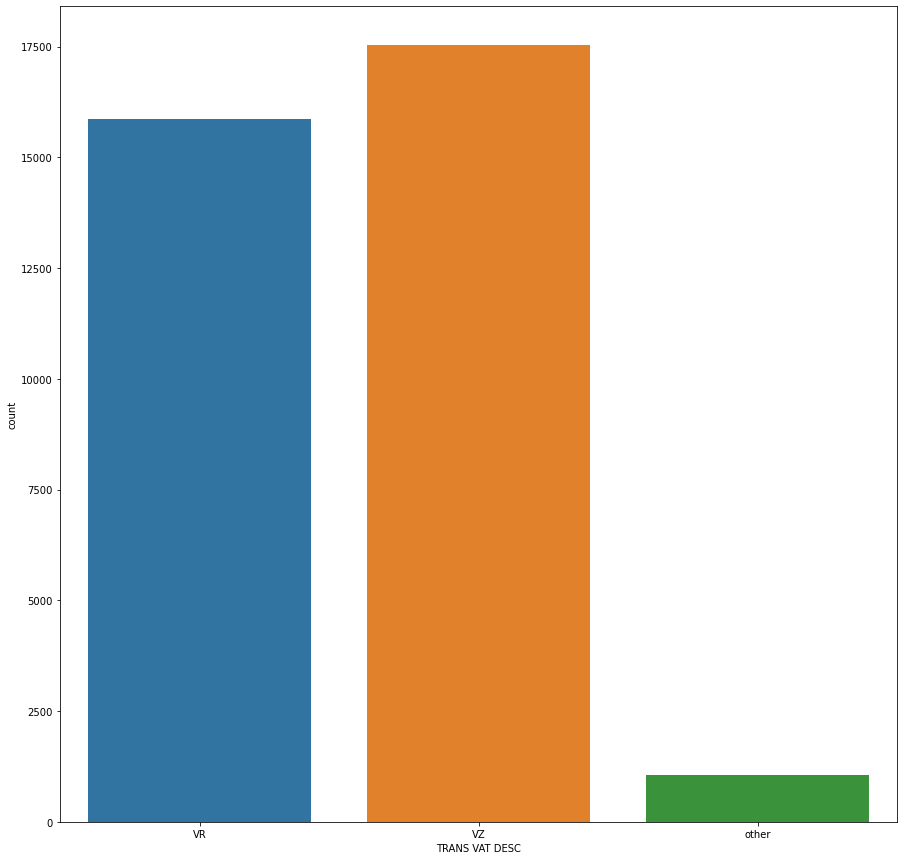

In [27]:
plt.figure(figsize=(15,15))
sns.countplot(x='TRANS VAT DESC',data=df2014)

We found out a baseline of 50.89% (for TRANS VAT DESC) for the year of 2014

In [28]:
df2014['TRANS VAT DESC'][df2014['TRANS VAT DESC'] == 'VZ'].count()/df2014.shape[0]*100

50.88961774010971

In order for us to do an exploratory analysis aiming at profiling clients and merchants we need to verify the possible typing mistakes for both categories as well as creating different dataframes grouping by each of those categories.

In [29]:
clients = df2014['CARD NUMBER'].unique()  
clients

array(['************5770', '************8738', '************2997',
       '************5804', '************3069', '************5507',
       '************7321', '************2823', '************7214',
       '************5463', '************7557', '************8311',
       '************8061', '************7123', '************1149',
       '************4714', '************4518', '************4985',
       '************5440', '************7776', '************5465',
       '************4039', '************9236', '************8055',
       '************5812', '************8657', '************3981',
       '************6316', '************6299', '************3879',
       '************7915', '************8085', '************6398',
       '************8985', '************7966', '************4993',
       '************4302', '************5339', '************1337',
       '************8002', '************8584', '************1858',
       '************4596', '************6968', '************17

We want to check if there is a typo in the amount of asterisks and there are possibly repeteated card numbers (i.e. clients)

In [30]:
num = None
differences = 0
for c in clients:
    if num == None:
        num == len(c)
    else:
        if num != len(c):
            differences += 1
print("There are", differences,"differences in length")    

There are 0 differences in length


We want to check the amount of different merchants involved in the 2014 dataset

In [31]:
merchants = df2014['MERCHANT NAME'].unique()  
len(merchants)

4716

We define a function to verify the similarity of the names between merchants in orther to avoid repetitions. We use SequenceMatcher and its ratio.

In [32]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

We define a new dataframe where we will make the changes related to the merchants.

In [33]:
df2014Merchants = df2014.copy()

We define a threshold of 95% and we process the column MERCHANT NAME trying to find names that are similar in more that 95% in order to reduce the amount of redundant categories. We reduce the amount of merchants to 4662.

In [34]:
for i in range(len(merchants)):
    for j in range(i,len(merchants)):
        if similar(merchants[i],merchants[j]) != 1 and similar(merchants[i],merchants[j]) > 0.95:
            print(merchants[i],'---',merchants[j])
            df2014Merchants.loc[df2014Merchants['MERCHANT NAME'] == merchants[j],'MERCHANT NAME'] = merchants[i]

amazon *mktplce eu-uk --- amazon mktplce eu-uk
w m morrison plc --- w m morrisons plc
sainsburys s/mkts --- sainsburys s/mkt
sainsburys s/mkts --- sainsburys smkts
w m morrisons --- w m morrison
w m morrisons --- wm morrisons
sainsburys smkt --- sainsburys s/mkt
sainsburys smkt --- sainsbury's smkt
sainsburys smkt --- sainsburys smkts
wm morrisons store --- wm morrison store
pret a manger --- pret a manager
monarch air --- monarch airl
tesco store 2624 --- tesco stores 2624
sacat marks  spencer --- sacat marks & spencer
1&1 internet limited --- 11 internet limited
sainsburys s/mkt --- sainsbury's s/mkt
mcdonalds rest --- mcdonalds rest.
sainsbury's s/mkt --- sainsbury's smkt
tesco pay at pump 4203 --- tesco pay at pump 4231
morrisons petrol --- morrison petrol
the bristish associati --- the british associatio
paypal *vyka ltd --- paypal vyka ltd
pam's florist --- pams florist
paypal *pixygraphic --- paypal pixygraphic
sport  leisure --- sport & leisure
ee  t-mobile --- ee & t-mobile
se

In [35]:
len(df2014Merchants['MERCHANT NAME'].unique())

4662

We save the last 2014 dataframe in a .pkl file.

In [36]:
df2014_pkl_filename = '/Users/andresaristi/Documents/BirminghamCardTransactions/pickle_files/df2014.pkl'
df2014_pkl = open(df2014_pkl_filename, 'wb')
pickle.dump(df2014Merchants, df2014_pkl)
df2014_pkl.close()

We load the last saved 2014 dataframe.

In [37]:
df2014_pkl_opened = open(df2014_pkl_filename, 'rb')
df2014_pkl_loaded = pickle.load(df2014_pkl_opened)
df2014_pkl_loaded

TRANS DATE TRANS VAT DESC  ORIGINAL GROSS AMT          MERCHANT NAME  \
0    2014-04-29             VR               52.32        shell kings 587   
1    2014-04-04             VR               65.82        shell kings 587   
2    2014-04-07             VR               41.35         tesco pfs 2484   
3    2014-04-25             VR               47.19  bush  service station   
4    2014-04-24             VR               98.08  bush  service station   
...         ...            ...                 ...                    ...   
3288 2014-12-18             VR               39.30      sainsburys s/mkts   
3289 2014-12-22             VR              349.00             dreams ltd   
3290 2014-12-22             VR               51.30      sainsburys s/mkts   
3291 2014-12-24             VZ               62.00    post office counter   
3292 2014-12-24             VZ               31.00    post office counter   

           CARD NUMBER BILLING CUR CODE TRANS CAC CODE 1    TRANS CAC DESC 1  \
0     ************5770              GBP             K020        Vehicle Fuel   
1     ************5770              GBP             K020        Vehicle Fuel   
2     ************8738              GBP             K020        Vehicle Fuel   
3     ************2997              GBP             K020        Vehicle Fuel   
4     ************2997              GBP             K020        Vehicle Fuel   
...                ...              ...              ...                 ...   
3288  ************8673              GBP             MC70  Supplies & Sev Mic   
3289  ************8673              GBP             L100   Equip Operational   
3290  ************8673              GBP             MC70  Supplies & Sev Mic   
3291  ************8673              GBP             L700             Postage   
3292  ************8673              GBP             L700             Postage   

     TRANS CAC CODE 2                TRANS CAC DESC 2 TRANS CAC CODE 3  \
0               RV12N            African-Caribbean DC              A00   
1               RV12N            African-Caribbean DC              A00   
2               RV11Y         Marsh Lane Dce, 79, B23              A00   
3               RV1K1        Elders Group - Erdington              A00   
4               RV1K1        Elders Group - Erdington              A00   
...               ...                             ...              ...   
3288            RJHH8    Homeless Centre-Breedon Road              A00   
3289            RJHH8    Homeless Centre-Breedon Road              A00   
3290            RJHH4       Homeless Centre  Bushmere              A00   
3291            RJHNB  H/Needs Hmelss Assessment Team              A00   
3292            RJHNB  H/Needs Hmelss Assessment Team              A00   

              Directorate  
0     Adult & Communities  
1     Adult & Communities  
2     Adult & Communities  
3     Adult & Communities  
4     Adult & Communities  
...                   ...  
3288       Local Services  
3289       Local Services  
3290       Local Services  
3291       Local Services  
3292       Local Services  

[34453 rows x 12 columns]

We group by clients and do feature engineering by creating new numerical variables related to the different Value-Added tax of each client.

In [38]:
df_clients_2014 = df2014_pkl_loaded.groupby('CARD NUMBER').agg(accumulated_gross_amt=('ORIGINAL GROSS AMT', 'sum'), 
                                                               Number_of_transactions=('CARD NUMBER', 'count'), 
                                                               VR_number=('TRANS VAT DESC', lambda val: (val == 'VR').sum()),
                                                              VZ_number=('TRANS VAT DESC', lambda val: (val == 'VZ').sum()),
                                                              other_number=('TRANS VAT DESC', lambda val: (val == 'other').sum()))
df_clients_2014.head()

accumulated_gross_amt  Number_of_transactions  VR_number  \
CARD NUMBER                                                                  
************0007                 214.04                       8          3   
************0015                  48.04                       1          1   
************0040                 737.18                       9          8   
************0047               10855.66                      95         38   
************0057                 760.81                       8          2   

                  VZ_number  other_number  
CARD NUMBER                                
************0007          5             0  
************0015          0             0  
************0040          1             0  
************0047         51             6  
************0057          4             2

We create a function to do more feature engineering by creating columns related to the main description of card transactions per client.

In [39]:
def add_trans_description(descriptions, data, variable, name):
    df = pd.DataFrame()
    i=0
    for descr in descriptions:
        df1 = pd.DataFrame()
        print(descr)
        #exec("%s = %s" % (des, descr)) (
        df1 = data.groupby(variable).agg(descr=(name, lambda val: (val == descr).sum()))
        df = pd.concat([df,df1], axis=1)
    return df

We create the new dataframe that will contain 96 new numerical features. 

In [40]:
descriptions = df2014Merchants['TRANS CAC DESC 1'].unique()
df_clients_2014_transf = add_trans_description(descriptions,df2014_pkl_loaded,'CARD NUMBER','TRANS CAC DESC 1')
df_clients_2014_transf

Vehicle Fuel
Training Other
Computing Other
Vehicle Excise Lics
Equip Other
Vehicle R&M
Books
Staff Advert Exp
Equip Operational
Stationery
Purchases Food
Bldg RM Departmental
Travel Bus/Rail
Hospitality
Vehicle OthrunCosts
Ttavel Other (UK)
Photocopying
Mat'l Raw/Drct
Postage
Travel Taxis
Supplies & Sev Mic
Prof Fees other
Other Fix&Fittings
Conference Fees Subs Foreign
Conference Fees Subs UK
Legal Fee Other
Equip Office
Electricity
Car Allowances etc
Travel Foreign
N'Papers&Periodicals
Phon NonCentrx Lines
Visits Expenditure
Other Services
Personal Needs
Clothing&Uniforms
HR&M Door Entry
Equip Maintenance
Licences & Permits
Stock Misc
Cleaning Materials
Subscriptions
Grounds Maintenance
Bldg RM Fair Fund NS
Bldg RM Routine UDD
Signs & N'boards
Premises Provisions
Disinfestation
Mobiles/Radios/Pagrs
Bldg RM Emergy UDD
Bank & Goro ChgsS
Oth Indirect EmpExps
Car Parking
Advertising NonStaff
GoodsPurchforResale
Promotions/Marketing
Transport Misc
Other Agencies
Witness Expenses
In Year 

descr  descr  descr  descr  descr  descr  descr  descr  \
CARD NUMBER                                                                
************0007      0      0      0      0      0      0      0      0   
************0015      1      0      0      0      0      0      0      0   
************0040      9      0      0      0      0      0      0      0   
************0047      0      2      1      2      1      0      2      0   
************0057      8      0      0      0      0      0      0      0   
...                 ...    ...    ...    ...    ...    ...    ...    ...   
************9957      6      0      0      0      1      0      2      0   
************9963      0      0      0      0      1      0      0      0   
************9968     11      0      0      0      0      0      0      0   
************9971      0      1      0      0      1      0     12      0   
************9989      0      0      0      0      4      0      4      0   

                  descr  descr  ...  descr  descr  descr  descr  descr  descr  \
CARD NUMBER                     ...                                             
************0007      2      0  ...      0      0      0      0      0      0   
************0015      0      0  ...      0      0      0      0      0      0   
************0040      0      0  ...      0      0      0      0      0      0   
************0047     32      8  ...      0      0      0      0      0      0   
************0057      0      0  ...      0      0      0      0      0      0   
...                 ...    ...  ...    ...    ...    ...    ...    ...    ...   
************9957     12      2  ...      0      0      0      0      0      0   
************9963      2      0  ...      0      0      0      0      0      0   
************9968      0      0  ...      0      0      0      0      0      0   
************9971      3      1  ...      0      0      0      0      0      0   
************9989     19      3  ...      0      0      0      0      0      0   

                  descr  descr  descr  descr  
CARD NUMBER                                   
************0007      0      0      0      0  
************0015      0      0      0      0  
************0040      0      0      0      0  
************0047      0      0      0      0  
************0057      0      0      0      0  
...                 ...    ...    ...    ...  
************9957      0      0      0      0  
************9963      0      0      0      0  
************9968      0      0      0      0  
************9971      0      0      0      0  
************9989      0      0      0      0  

[993 rows x 96 columns]

We trim the card transactions' descriptions in order to associate them to each column of the previously created dataframe.

In [41]:
descriptions = df2014Merchants['TRANS CAC DESC 1'].unique()  
descriptions_trimmed = list()
for descr in descriptions:
    des = descr
    des = descr.replace(" ","")
    des = descr.replace("&","")
    des = descr.replace("/","")
    des = descr.replace("(","")
    des = descr.replace(")","")
    des = descr.replace("'","")
    des = descr.replace("-","")
    des = descr.replace(".","")
df_clients_2014_transf.shape
len(descriptions)
df_clients_2014_transf.columns = descriptions

We visualize the first 5 rows of our new dataframe

In [42]:
df_clients_2014_transf.head()

Vehicle Fuel  Training Other  Computing Other  \
CARD NUMBER                                                       
************0007             0               0                0   
************0015             1               0                0   
************0040             9               0                0   
************0047             0               2                1   
************0057             8               0                0   

                  Vehicle Excise Lics  Equip Other  Vehicle R&M  Books  \
CARD NUMBER                                                              
************0007                    0            0            0      0   
************0015                    0            0            0      0   
************0040                    0            0            0      0   
************0047                    2            1            0      2   
************0057                    0            0            0      0   

                  Staff Advert Exp  Equip Operational  Stationery  ...  \
CARD NUMBER                                                        ...   
************0007                 0                  2           0  ...   
************0015                 0                  0           0  ...   
************0040                 0                  0           0  ...   
************0047                 0                 32           8  ...   
************0057                 0                  0           0  ...   

                  Floral Decorations  GOVEN'MNT DEPARTMNTS  Refuse Collection  \
CARD NUMBER                                                                     
************0007                   0                     0                  0   
************0015                   0                     0                  0   
************0040                   0                     0                  0   
************0047                   0                     0                  0   
************0057                   0                     0                  0   

                  Sec. 24 CH Act 1989  IT Leasing Charges  \
CARD NUMBER                                                 
************0007                    0                   0   
************0015                    0                   0   
************0040                    0                   0   
************0047                    0                   0   
************0057                    0                   0   

                  NonEmpAllow-Training  Training Tutor Fees  \
CARD NUMBER                                                   
************0007                     0                    0   
************0015                     0                    0   
************0040                     0                    0   
************0047                     0                    0   
************0057                     0                    0   

                  Aftercare Assistance  Rents incl Svce Chgs  \
CARD NUMBER                                                    
************0007                     0                     0   
************0015                     0                     0   
************0040                     0                     0   
************0047                     0                     0   
************0057                     0                     0   

                  SchGovBrds Clerks  
CARD NUMBER                          
************0007                  0  
************0015                  0  
************0040                  0  
************0047                  0  
************0057                  0  

[5 rows x 96 columns]

We concatenate the two dataframes in one, which we will later use to clusterize. 

Previously, we will need to standardize our new numerical variables, since we are going to use unsupervised techniques based on distances.

In [43]:
data2014 = pd.concat([df_clients_2014, df_clients_2014_transf],axis=1)
data2014.head()

accumulated_gross_amt  Number_of_transactions  VR_number  \
CARD NUMBER                                                                  
************0007                 214.04                       8          3   
************0015                  48.04                       1          1   
************0040                 737.18                       9          8   
************0047               10855.66                      95         38   
************0057                 760.81                       8          2   

                  VZ_number  other_number  Vehicle Fuel  Training Other  \
CARD NUMBER                                                               
************0007          5             0             0               0   
************0015          0             0             1               0   
************0040          1             0             9               0   
************0047         51             6             0               2   
************0057          4             2             8               0   

                  Computing Other  Vehicle Excise Lics  Equip Other  ...  \
CARD NUMBER                                                          ...   
************0007                0                    0            0  ...   
************0015                0                    0            0  ...   
************0040                0                    0            0  ...   
************0047                1                    2            1  ...   
************0057                0                    0            0  ...   

                  Floral Decorations  GOVEN'MNT DEPARTMNTS  Refuse Collection  \
CARD NUMBER                                                                     
************0007                   0                     0                  0   
************0015                   0                     0                  0   
************0040                   0                     0                  0   
************0047                   0                     0                  0   
************0057                   0                     0                  0   

                  Sec. 24 CH Act 1989  IT Leasing Charges  \
CARD NUMBER                                                 
************0007                    0                   0   
************0015                    0                   0   
************0040                    0                   0   
************0047                    0                   0   
************0057                    0                   0   

                  NonEmpAllow-Training  Training Tutor Fees  \
CARD NUMBER                                                   
************0007                     0                    0   
************0015                     0                    0   
************0040                     0                    0   
************0047                     0                    0   
************0057                     0                    0   

                  Aftercare Assistance  Rents incl Svce Chgs  \
CARD NUMBER                                                    
************0007                     0                     0   
************0015                     0                     0   
************0040                     0                     0   
************0047                     0                     0   
************0057                     0                     0   

                  SchGovBrds Clerks  
CARD NUMBER                          
************0007                  0  
************0015                  0  
************0040                  0  
************0047                  0  
************0057                  0  

[5 rows x 101 columns]

We can see the difference in scales which won't be useful to us if we want use PCA to reduce dimensions and preprocess the data in order for the clustering methods to consume it and be interpreted correctly.

In [44]:
data2014.describe()

accumulated_gross_amt  Number_of_transactions   VR_number   VZ_number  \
count           9.930000e+02              993.000000  993.000000  993.000000   
mean            5.640871e+03               34.695871   15.969789   17.656596   
std             7.110156e+04               41.762893   21.285007   31.576550   
min            -6.236000e+01                1.000000    0.000000    0.000000   
25%             4.653700e+02                7.000000    3.000000    1.000000   
50%             1.255960e+03               19.000000    8.000000    5.000000   
75%             3.279320e+03               48.000000   21.000000   21.000000   
max             2.209574e+06              325.000000  165.000000  288.000000   

       other_number  Vehicle Fuel  Training Other  Computing Other  \
count    993.000000    993.000000      993.000000       993.000000   
mean       1.069486      5.434038        0.211480         0.472306   
std        4.276507     11.459603        0.951224         2.174237   
min        0.000000      0.000000        0.000000         0.000000   
25%        0.000000      0.000000        0.000000         0.000000   
50%        0.000000      0.000000        0.000000         0.000000   
75%        0.000000      6.000000        0.000000         0.000000   
max       63.000000     88.000000       15.000000        41.000000   

       Vehicle Excise Lics  Equip Other  ...  Floral Decorations  \
count           993.000000   993.000000  ...          993.000000   
mean              0.437059     0.888218  ...            0.005035   
std               3.830364     3.143829  ...            0.095117   
min               0.000000     0.000000  ...            0.000000   
25%               0.000000     0.000000  ...            0.000000   
50%               0.000000     0.000000  ...            0.000000   
75%               0.000000     0.000000  ...            0.000000   
max              99.000000    49.000000  ...            2.000000   

       GOVEN'MNT DEPARTMNTS  Refuse Collection  Sec. 24 CH Act 1989  \
count            993.000000         993.000000           993.000000   
mean               0.003021           0.004028             0.002014   
std                0.095202           0.077667             0.063468   
min                0.000000           0.000000             0.000000   
25%                0.000000           0.000000             0.000000   
50%                0.000000           0.000000             0.000000   
75%                0.000000           0.000000             0.000000   
max                3.000000           2.000000             2.000000   

       IT Leasing Charges  NonEmpAllow-Training  Training Tutor Fees  \
count          993.000000            993.000000           993.000000   
mean             0.002014              0.001007             0.007049   
std              0.044856              0.031734             0.145326   
min              0.000000              0.000000             0.000000   
25%              0.000000              0.000000             0.000000   
50%              0.000000              0.000000             0.000000   
75%              0.000000              0.000000             0.000000   
max              1.000000              1.000000             4.000000   

       Aftercare Assistance  Rents incl Svce Chgs  SchGovBrds Clerks  
count            993.000000            993.000000         993.000000  
mean               0.002014              0.001007           0.001007  
std                0.063468              0.031734           0.031734  
min                0.000000              0.000000           0.000000  
25%                0.000000              0.000000           0.000000  
50%                0.000000              0.000000           0.000000  
75%                0.000000              0.000000           0.000000  
max                2.000000              1.000000           1.000000  

[8 rows x 101 columns]

We have created 101 new numerical variables by means of feature engineering.

To reduce the amount of variables we group by common elements such as:

- Vehicles
- Personal needs
- Services
- Transport
- Residence
- Work related
- Family&School
- Legal



In [45]:
data2014_copy = data2014.copy()
data2014['Vehicles'] = data2014['Vehicle Fuel'] + data2014['Vehicle Excise Lics'] + data2014['Vehicle R&M'] + data2014['Vehicle OthrunCosts'] + data2014['Car Allowances etc'] + data2014['Car Parking'] + data2014['Vehicle Hire Charge'] + data2014['Vehicle Tyres']
data2014.drop(['Vehicle Fuel'],axis=1,inplace=True)
data2014.drop(['Vehicle Excise Lics'],axis=1,inplace=True)
data2014.drop(['Vehicle R&M'],axis=1,inplace=True)
data2014.drop(['Vehicle OthrunCosts'],axis=1,inplace=True)
data2014.drop(['Car Allowances etc'],axis=1,inplace=True)
data2014.drop(['Car Parking'],axis=1,inplace=True)
data2014.drop(['Vehicle Hire Charge'],axis=1,inplace=True)
data2014.drop(['Vehicle Tyres'],axis=1,inplace=True)

data2014['Personal needs'] = data2014['Books'] + data2014['Purchases Food'] + data2014['Hospitality'] + data2014['Postage'] + data2014['Personal Needs'] + data2014['Clothing&Uniforms'] + data2014['Subscriptions'] + data2014['Laundry'] + data2014['Entertainers/Artists'] + data2014['Mobiles/Radios/Pagrs'] + data2014['Floral Decorations'] + data2014['Aftercare Assistance'] + data2014["Mat'l Raw/Drct"] + data2014['In Year Credits'] + data2014['CSDP Act Telephones']
data2014.drop(['Books'],axis=1,inplace=True)  
data2014.drop(['Purchases Food'],axis=1,inplace=True)  
data2014.drop(['Hospitality'],axis=1,inplace=True)  
data2014.drop(['Postage'],axis=1,inplace=True)  
data2014.drop(['Personal Needs'],axis=1,inplace=True)  
data2014.drop(['Clothing&Uniforms'],axis=1,inplace=True)  
data2014.drop(['Subscriptions'],axis=1,inplace=True)  
data2014.drop(['Laundry'],axis=1,inplace=True)  
data2014.drop(['Entertainers/Artists'],axis=1,inplace=True)  
data2014.drop(['Mobiles/Radios/Pagrs'],axis=1,inplace=True)  
data2014.drop(['Floral Decorations'],axis=1,inplace=True)  
data2014.drop(['Aftercare Assistance'],axis=1,inplace=True) 
data2014.drop(["Mat'l Raw/Drct"],axis=1,inplace=True) 
data2014.drop(['In Year Credits'],axis=1,inplace=True)
data2014.drop(['CSDP Act Telephones'],axis=1,inplace=True)

data2014['Services'] = data2014['Photocopying'] + data2014['Gas'] + data2014['Electricity'] + data2014["N'Papers&Periodicals"] + data2014['Other Services'] + data2014['Disinfestation'] + data2014['Consultancy Fees'] + data2014['Security Contracts'] + data2014['Phon NonCentrx Lines'] + data2014['Bank & Goro ChgsS'] + data2014['Refuse Collection']
data2014.drop(['Photocopying'],axis=1,inplace=True)  
data2014.drop(['Gas'],axis=1,inplace=True)  
data2014.drop(['Electricity'],axis=1,inplace=True)  
data2014.drop(["N'Papers&Periodicals"],axis=1,inplace=True)  
data2014.drop(['Other Services'],axis=1,inplace=True)  
data2014.drop(['Disinfestation'],axis=1,inplace=True)  
data2014.drop(['Consultancy Fees'],axis=1,inplace=True)  
data2014.drop(['Security Contracts'],axis=1,inplace=True)  
data2014.drop(['Phon NonCentrx Lines'],axis=1,inplace=True)  
data2014.drop(['Bank & Goro ChgsS'],axis=1,inplace=True)   
data2014.drop(['Refuse Collection'],axis=1,inplace=True)

data2014['Transport'] = data2014['Travel Bus/Rail'] + data2014["Ttavel Other (UK)"] + data2014['Travel Taxis'] + data2014['Travel Foreign'] + data2014['Transport Misc'] + data2014['Transport Insurance'] 
data2014.drop(['Travel Bus/Rail'],axis=1,inplace=True)  
data2014.drop(["Ttavel Other (UK)"],axis=1,inplace=True) 
data2014.drop(['Travel Taxis'],axis=1,inplace=True) 
data2014.drop(['Travel Foreign'],axis=1,inplace=True) 
data2014.drop(['Transport Misc'],axis=1,inplace=True) 
data2014.drop(['Transport Insurance'],axis=1,inplace=True) 

data2014['Residence'] = data2014['Other Fix&Fittings'] + data2014['Bldg RM Fair Fund NS'] + data2014['Bldg RM Routine UDD'] + data2014['Bldg RM Emergy UDD'] + data2014['Bldg RM Fair Fund S'] + data2014['Rents incl Svce Chgs'] + data2014['Bldg RM Departmental'] 
data2014.drop(['Other Fix&Fittings'],axis=1,inplace=True) 
data2014.drop(['Bldg RM Fair Fund NS'],axis=1,inplace=True) 
data2014.drop(['Bldg RM Routine UDD'],axis=1,inplace=True) 
data2014.drop(['Bldg RM Emergy UDD'],axis=1,inplace=True) 
data2014.drop(['Bldg RM Fair Fund S'],axis=1,inplace=True) 
data2014.drop(['Rents incl Svce Chgs'],axis=1,inplace=True) 
data2014.drop(['Bldg RM Departmental'],axis=1,inplace=True)

data2014['Work related'] = data2014['Training Other'] + data2014['Computing Other'] + data2014['Equip Other'] + data2014['Staff Advert Exp'] + data2014['Equip Operational'] + data2014['Supplies & Sev Mic'] + data2014['Conference Fees Subs Foreign'] + data2014['Conference Fees Subs UK'] + data2014['Equip Office'] + data2014['Equip Maintenance'] + data2014['Licences & Permits'] + data2014['Stock Misc'] + data2014['Cleaning Materials'] + data2014['Grounds Maintenance'] + data2014["Signs & N'boards"] + data2014['Premises Provisions'] + data2014['Oth Indirect EmpExps'] + data2014['Advertising NonStaff'] + data2014['GoodsPurchforResale'] + data2014['Promotions/Marketing'] + data2014['Other Agencies'] + data2014['Accomodation Hire'] + data2014["Purchases Othermat'l"] + data2014["Training EquipMat'ls"] + data2014['Catering Disposables'] + data2014["Fire/Sec'yAlarm/Eq't"] + data2014["Equip Hire/Op Lease"] + data2014['Contract Meals'] + data2014['NonEmpAllow-General'] + data2014['Insurance NonPremise'] + data2014['Other Third Parties'] + data2014['Training Travel&Subs'] + data2014['IT Leasing Charges'] + data2014['NonEmpAllow-Training'] + data2014['Visits Expenditure'] + data2014['Premises Misc'] + data2014["Not'l fin Cha IT"] + data2014['HR&M Door Entry'] + data2014['Stationery'] + data2014['Recordings (S&V)']
data2014.drop(['Training Other'],axis=1,inplace=True)  
data2014.drop(['Computing Other'],axis=1,inplace=True)  
data2014.drop(['Equip Other'],axis=1,inplace=True)  
data2014.drop(['Staff Advert Exp'],axis=1,inplace=True)  
data2014.drop(['Equip Operational'],axis=1,inplace=True)  
data2014.drop(['Supplies & Sev Mic'],axis=1,inplace=True)  
data2014.drop(['Conference Fees Subs Foreign'],axis=1,inplace=True)  
data2014.drop(['Conference Fees Subs UK'],axis=1,inplace=True)  
data2014.drop(['Equip Office'],axis=1,inplace=True)  
data2014.drop(['Equip Maintenance'],axis=1,inplace=True)  
data2014.drop(['Licences & Permits'],axis=1,inplace=True)  
data2014.drop(['Stock Misc'],axis=1,inplace=True)  
data2014.drop(['Cleaning Materials'],axis=1,inplace=True)  
data2014.drop(['Grounds Maintenance'],axis=1,inplace=True)  
data2014.drop(["Signs & N'boards"],axis=1,inplace=True)  
data2014.drop(['Premises Provisions'],axis=1,inplace=True)  
data2014.drop(['Oth Indirect EmpExps'],axis=1,inplace=True)  
data2014.drop(['Advertising NonStaff'],axis=1,inplace=True)  
data2014.drop(['GoodsPurchforResale'],axis=1,inplace=True)  
data2014.drop(['Promotions/Marketing'],axis=1,inplace=True)  
data2014.drop(['Other Agencies'],axis=1,inplace=True) 
data2014.drop(['Accomodation Hire'],axis=1,inplace=True) 
data2014.drop(["Purchases Othermat'l"],axis=1,inplace=True) 
data2014.drop(["Training EquipMat'ls"],axis=1,inplace=True) 
data2014.drop(['Catering Disposables'],axis=1,inplace=True) 
data2014.drop(["Fire/Sec'yAlarm/Eq't"],axis=1,inplace=True) 
data2014.drop(["Equip Hire/Op Lease"],axis=1,inplace=True) 
data2014.drop(['Contract Meals'],axis=1,inplace=True) 
data2014.drop(['NonEmpAllow-General'],axis=1,inplace=True) 
data2014.drop(['Insurance NonPremise'],axis=1,inplace=True) 
data2014.drop(['Other Third Parties'],axis=1,inplace=True) 
data2014.drop(['Training Travel&Subs'],axis=1,inplace=True) 
data2014.drop(['IT Leasing Charges'],axis=1,inplace=True) 
data2014.drop(['NonEmpAllow-Training'],axis=1,inplace=True) 
data2014.drop(['Visits Expenditure'],axis=1,inplace=True)
data2014.drop(['Premises Misc'],axis=1,inplace=True)
data2014.drop(["Not'l fin Cha IT"],axis=1,inplace=True)
data2014.drop(['Stationery'],axis=1,inplace=True)
data2014.drop(['HR&M Door Entry'],axis=1,inplace=True)
data2014.drop(['Recordings (S&V)'],axis=1,inplace=True)

data2014["Family&School"] = data2014['Prof Fees other'] + data2014['Family Support S17'] + data2014['Other Grants'] + data2014['Training Tutor Fees'] + data2014['SchGovBrds Clerks'] + data2014['Sec. 24 CH Act 1989']
data2014.drop(['Prof Fees other'],axis=1,inplace=True) 
data2014.drop(['Family Support S17'],axis=1,inplace=True) 
data2014.drop(['Other Grants'],axis=1,inplace=True) 
data2014.drop(['Training Tutor Fees'],axis=1,inplace=True) 
data2014.drop(['SchGovBrds Clerks'],axis=1,inplace=True) 
data2014.drop(['Sec. 24 CH Act 1989'],axis=1,inplace=True) 

data2014["Legal"] = data2014['Legal Fee Other'] + data2014['Witness Expenses'] 
data2014.drop(['Legal Fee Other'],axis=1,inplace=True) 
data2014.drop(['Witness Expenses'],axis=1,inplace=True) 
    

Since 992 datapoints are from category 0 in the new numerical feature GOVEN'MNT DEPARTMNTS, (99.9% of the data) we will drop that column. It will not give as anything new to profile the clusters of clients.

<AxesSubplot:xlabel="GOVEN'MNT DEPARTMNTS", ylabel='count'>

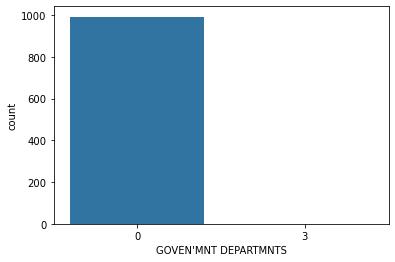

In [46]:
sns.countplot(x="GOVEN'MNT DEPARTMNTS",data=data2014)

In [47]:
pd.crosstab(index=data2014["GOVEN'MNT DEPARTMNTS"],columns='count')

col_0                 count
GOVEN'MNT DEPARTMNTS       
0                       992
3                         1

In [48]:
data2014.drop(["GOVEN'MNT DEPARTMNTS"],axis=1,inplace=True) 

In [49]:
data2014.shape

(993, 13)

We standardize the new numerical features

In [50]:
data2014_std = data2014.copy()
data2014_std = StandardScaler().fit_transform(data2014_std)
data2014_std = pd.DataFrame(data2014_std)
data2014_std.columns = data2014.columns
data2014_std = data2014_std.set_index(data2014.index)

We have 993 data points and 13 numerical features that we will need to reduce, even more, in order to understand our clustering process.

In [51]:
data2014_std

accumulated_gross_amt  Number_of_transactions  VR_number  \
CARD NUMBER                                                                  
************0007              -0.076364               -0.639547  -0.609646   
************0015              -0.078699               -0.807244  -0.703656   
************0040              -0.069002               -0.615590  -0.374621   
************0047               0.073380                1.444692   1.035532   
************0057              -0.068670               -0.639547  -0.656651   
...                                 ...                     ...        ...   
************9957              -0.018586                0.630162   1.975634   
************9963              -0.071055               -0.735374  -0.562641   
************9968              -0.070117               -0.567676  -0.468631   
************9971              -0.056846                0.031243  -0.468631   
************9989              -0.038510                1.444692   0.236446   

                  VZ_number  other_number  Vehicles  Personal needs  Services  \
CARD NUMBER                                                                     
************0007  -0.401025     -0.250210 -0.540526       -0.369930  0.571999   
************0015  -0.559450     -0.250210 -0.459606       -0.491849 -0.278718   
************0040  -0.527765     -0.250210  0.187754       -0.491849 -0.278718   
************0047   1.056487      1.153511 -0.378686        0.605419  1.139144   
************0057  -0.432710      0.217697  0.106834       -0.491849 -0.278718   
...                     ...           ...       ...             ...       ...   
************9957  -0.464395     -0.250210 -0.055006        0.686698 -0.278718   
************9963  -0.559450     -0.250210 -0.540526       -0.451209 -0.278718   
************9968  -0.401025     -0.250210  0.349594       -0.491849 -0.278718   
************9971   0.391101     -0.250210 -0.540526        0.605419 -0.278718   
************9989   0.898062      6.300488 -0.459606        1.905884 -0.278718   

                  Transport  Residence  Work related  Family&School     Legal  
CARD NUMBER                                                                    
************0007  -0.220214  -0.260819     -0.484121      -0.208617 -0.048902  
************0015  -0.220214  -0.260819     -0.577070      -0.208617 -0.048902  
************0040  -0.220214  -0.260819     -0.577070      -0.208617 -0.048902  
************0047  -0.220214   0.121177      2.164927       0.277666 -0.048902  
************0057  -0.220214  -0.260819     -0.577070      -0.208617 -0.048902  
...                     ...        ...           ...            ...       ...  
************9957   0.221996   0.121177      0.491844      -0.208617 -0.048902  
************9963  -0.220214  -0.260819     -0.437647      -0.208617 -0.048902  
************9968  -0.220214  -0.260819     -0.577070      -0.208617 -0.048902  
************9971   0.000891  -0.260819     -0.251749       0.277666 -0.048902  
************9989  -0.220214   1.267163      0.863640      -0.208617 -0.048902  

[993 rows x 13 columns]

## 4. Modelling

### 4.1 PCA

We are going to make a space projection of our principal components in order to better understand the data.

In [52]:
pca2014 = PCA()
data2014_std_projected = pca2014.fit_transform(data2014_std)

We save our PCA object.

In [53]:
df2014_pca_pkl_filename = '/Users/andresaristi/Documents/BirminghamCardTransactions/pickle_files/df2014_pca.pkl'
df2014_pca_pkl = open(df2014_pca_pkl_filename, 'wb')
pickle.dump(data2014_std_projected, df2014_pca_pkl)
df2014_pca_pkl.close()

After fitting the PCA object to the standardized dataset we will be able to see 13 principal components as a result of our tranformation. We will get a linear combination of the original variables and we will see the loadings that correspond to each of them.

In [54]:
pca2014.components_

array([[ 7.04239201e-02,  5.08224153e-01,  3.07332288e-01,
         4.37618513e-01,  2.02234753e-01,  2.65187760e-02,
         3.98717809e-01,  1.65424778e-01,  1.59219799e-01,
         1.65243030e-01,  3.95921485e-01,  8.57210591e-02,
         7.80004470e-02],
       [ 3.26989972e-02,  7.35445986e-02,  5.71397727e-01,
        -2.79325513e-01, -6.32836665e-02,  6.99087924e-01,
        -1.51833994e-01, -9.71993890e-02, -5.94059853e-02,
         7.25475994e-02,  5.88185144e-03, -1.88247324e-01,
        -1.39678044e-01],
       [ 5.15153104e-01,  4.74061413e-02,  1.93289905e-02,
         9.88608623e-02, -3.63213481e-01,  1.48214956e-01,
        -1.58416558e-01, -2.13383949e-02,  2.39156194e-01,
        -2.78680322e-01, -7.43619220e-02,  1.99245953e-01,
         6.02239957e-01],
       [ 4.70627773e-01, -3.74664784e-02,  4.01096436e-02,
        -1.08522992e-01,  2.35785679e-01, -2.06848646e-01,
        -1.04617032e-01, -1.34577780e-01, -5.85626760e-01,
         3.72539881e-01,  1.80288345e

In [55]:
data2014_std.columns

Index(['accumulated_gross_amt', 'Number_of_transactions', 'VR_number',
       'VZ_number', 'other_number', 'Vehicles', 'Personal needs', 'Services',
       'Transport', 'Residence', 'Work related', 'Family&School', 'Legal'],
      dtype='object')

We want to see the explained variance ratio of each PC.

In [56]:
exp_var=pca2014.explained_variance_ratio_ 
cum_exp_var = np.cumsum(exp_var) 
exp_var

array([2.89304643e-01, 1.10939433e-01, 8.95245750e-02, 8.18863371e-02,
       8.04666402e-02, 7.41262180e-02, 6.88510705e-02, 6.68901658e-02,
       5.85903585e-02, 4.86904913e-02, 3.07297481e-02, 3.19226661e-07,
       5.11252406e-33])

We can change the representation from the original dimensions (or features) to the new space made out by the principal componenents, by means of the transform method which belongs to the PCA object, we have already created.

In [57]:
dataPca2014 = pca2014.transform(data2014_std)

To better understand the amount of information belonging to each component we are going to show a graph which will tell us the most important PCs. These new features will help us to visualize when we try to profile the clusters of clients, transactions or merchants.

We can see that this plot shows too much information which is not needed. 

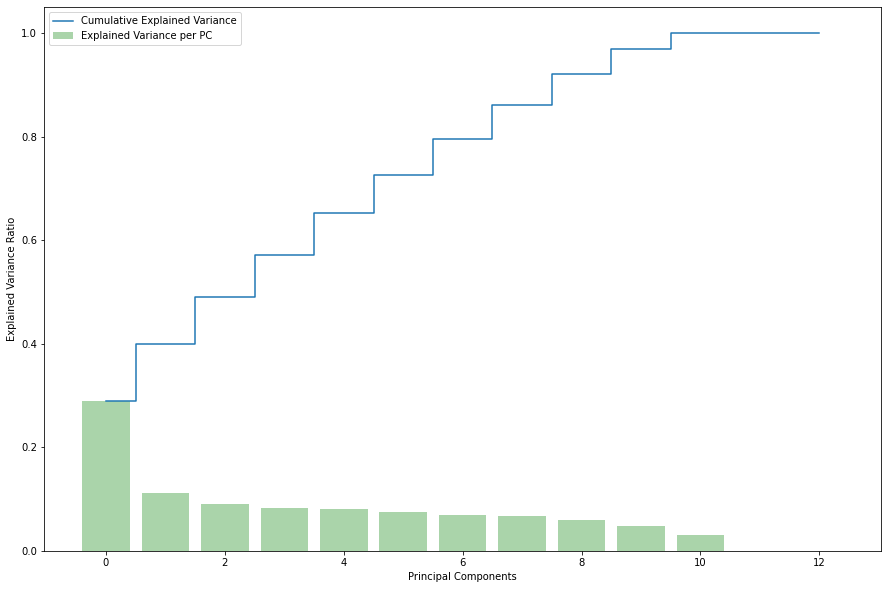

In [58]:
plt.figure(figsize=(15, 10))
plt.bar(range(len(exp_var)), exp_var, alpha=0.3333, align='center', label='Explained Variance per PC', color = 'g')
plt.step(range(len(cum_exp_var)), cum_exp_var, where='mid',label='Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.show()

We focus on just the 10 first principal components. That is why we just take out the first 8 elements in the array of explained variance and cumulative explained variance.

In [59]:
exp_var8 = exp_var[:8]
cum_exp_var8 = cum_exp_var[:8]

We focus on this bar plot and we are able to see the importance of the first principal component. We are also able to see that the next 7 PCs increase the cumulative variance much more than the following PCs (86.19%). 

That is why we will focus on these components in order to analize, understand and characterize their meaning so when applying a clustering technique, we will be able to interpret each segment and give an accurate profile of the clients.

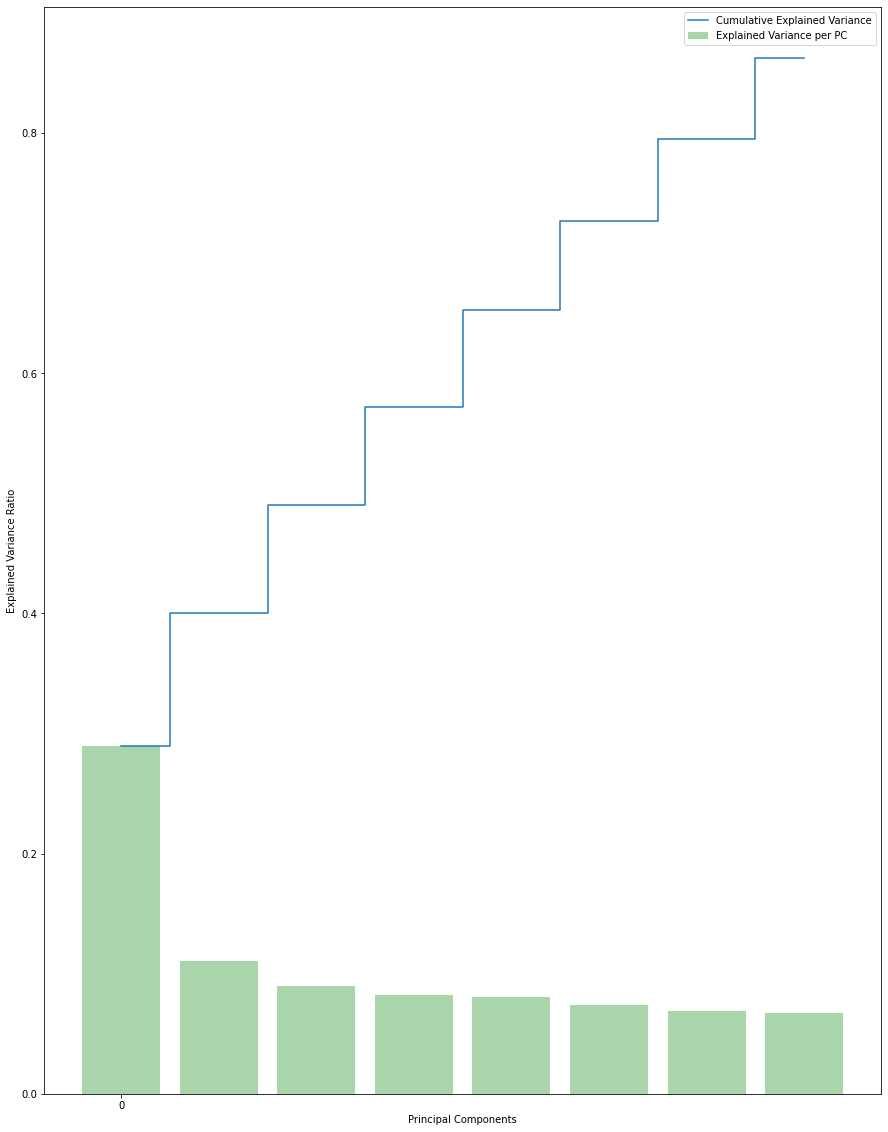

In [60]:
plt.figure(figsize=(15, 20))
plt.bar(range(len(exp_var8)), exp_var8, alpha=0.3333, align='center', label='Explained Variance per PC', color = 'g')
plt.step(range(len(cum_exp_var8)), cum_exp_var8, where='mid',label='Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.xticks(np.arange(0, 5, step=5))
plt.legend(loc='best')
plt.show()

Some criteria say that the total variance explained by the selected principal components should be between 70% to 80% in explained variance, which in this case would mean between 6 and 8 PCS.

Therefore, we will try using 6 PCS to understand the data in order to clusterize correctly.

In [61]:
print(cum_exp_var[5]*100,'%')
print(cum_exp_var[6]*100,'%')
print(cum_exp_var[7]*100,'%')

72.62478464753734 %
79.50989169556566 %
86.198908278766 %


We are able to distinguish the PC1 as the most important feature with 28.93% of the explained variance.

By sorting the PC1 we are able to understand that is a  balanced linear combination in which several original features contribute.

According to our analysis the five most important original features, taking into account their loads, are, 'Number_of_transactions', 'VZ_number', 'Personal needs', 'Work related' and 'VR_number' All with more than 0.30 of loadings.

This component describes clients that make several transactions (number of transactions) for personal needs but also related to their works. VR means standard rate, which coincides with the fact that they make purchases related to personal items. VZ means zero rated items which will include books belonging to the personal needs category. All original features have a positive relation with PC1.

<b>PC1:</b> High number of work/personal transactions

In [62]:
print(exp_var[0]*100,'%')

28.930464334029114 %


In [63]:
pc1 = [(pca2014.components_[0][i],i) for i in range(len(pca2014.components_[0]))]
pc1.sort(key=lambda x:abs(x[0]),reverse=True)
pc1

[(0.5082241526523965, 1),
 (0.437618513209619, 3),
 (0.39871780870876805, 6),
 (0.39592148479729905, 10),
 (0.3073322875733205, 2),
 (0.2022347529354581, 4),
 (0.165424777559905, 7),
 (0.16524302985817668, 9),
 (0.15921979936827713, 8),
 (0.08572105913629058, 11),
 (0.07800044701529958, 12),
 (0.07042392009228982, 0),
 (0.02651877595012873, 5)]

In [64]:
data2014_std.columns[[1,3,6,10,2]]

Index(['Number_of_transactions', 'VZ_number', 'Personal needs', 'Work related',
       'VR_number'],
      dtype='object')

The PC2 explains the 11.09% of the variance.

By sorting the PC2 we are able to understand that is a balanced linear combination in which several original features contribute. 

According to our analysis the three most important original features, taking into account their loads, are 'Vehicles', 'VR_number', 'VZ_number'. Their loadings are greater that 0.27.

This component describes clients that make card transactions related to their vehicles and, obviously, their tax-added value is VR, which is the standard one. VZ, which is zero added value tax has a negative relation, so it decreases in this group.

<b>PC2:</b> Vehicle and standard VAT card purchases

In [65]:
print(exp_var[1]*100,'%')

11.09394328166093 %


In [66]:
pc2 = [(pca2014.components_[1][i],i) for i in range(len(pca2014.components_[1]))]
pc2.sort(key=lambda x:abs(x[0]),reverse=True)
pc2

[(0.6990879235822429, 5),
 (0.5713977271792321, 2),
 (-0.2793255129376988, 3),
 (-0.18824732435531133, 11),
 (-0.15183399410393725, 6),
 (-0.13967804373663634, 12),
 (-0.09719938896620683, 7),
 (0.0735445986134687, 1),
 (0.07254759935427418, 9),
 (-0.06328366652304614, 4),
 (-0.05940598527916781, 8),
 (0.032698997213615834, 0),
 (0.005881851437448981, 10)]

In [67]:
data2014_std.columns[[5,2,3]]

Index(['Vehicles', 'VR_number', 'VZ_number'], dtype='object')

The amount of explained variance of PC3 is 8.95%.

When sorting the PC3, we find out the five most important original features are 'Legal', 'accumulated_gross_amt', 'other_number', 'Residence'and'Transport' which have more that 0.2 on their loadings.

This PC3 describes clients that make card purchases related mostly to legal expenses, they have a high accumulated gross amount, do not include many transctions with other TAV and do not spend much in residence (negative relation for the previous two features) but they do more transactions in transport.

<b>PC3:</b> High legal expenses and transport transactions

In [68]:
print(exp_var[2]*100,'%')

8.952457500448357 %


In [69]:
pc3 = [(pca2014.components_[2][i],i) for i in range(len(pca2014.components_[2]))]
pc3.sort(key=lambda x:abs(x[0]),reverse=True)
pc3

[(0.6022399571541859, 12),
 (0.515153104485849, 0),
 (-0.36321348098256906, 4),
 (-0.27868032195521214, 9),
 (0.23915619354672354, 8),
 (0.19924595287778463, 11),
 (-0.15841655767572563, 6),
 (0.1482149560280711, 5),
 (0.0988608623472649, 3),
 (-0.07436192195265208, 10),
 (0.04740614130512263, 1),
 (-0.021338394921974656, 7),
 (0.019328990532167304, 2)]

In [70]:
data2014_std.columns[[12,0,4,9,8]]

Index(['Legal', 'accumulated_gross_amt', 'other_number', 'Residence',
       'Transport'],
      dtype='object')

The PC4 explains the 8.19% of the variance.

By sorting the PC4 we are able to understand that is a balanced linear combination in which several original features contribute. 

According to our analysis the six most important original features, taking into account their loads, are 'Transport', 'accumulated_gross_amt', 'Residence', 'Legal', 'other_number' and 'Family&School'. Their loadings are greater that 0.21.

This component describes clients that do not make purchases related to transport (negative relation), the accumulated value of their transactions is high. Their transactions are mainly related to residence and legal aspects. Their purchases involve other VAT category. They do not make purchases related to Family&School (negative relation)

<b>PC4:</b> High expenses in residence and legal aspects

In [71]:
print(exp_var[3]*100,'%')

8.188633706200855 %


In [72]:
pc4 = [(pca2014.components_[3][i],i) for i in range(len(pca2014.components_[3]))]
pc4.sort(key=lambda x:abs(x[0]),reverse=True)
pc4

[(-0.5856267601900639, 8),
 (0.4706277728465184, 0),
 (0.3725398807866433, 9),
 (0.2758482865928485, 12),
 (0.2357856794253863, 4),
 (-0.2143402864035548, 11),
 (-0.20684864621694832, 5),
 (0.1802883445858389, 10),
 (-0.13457778007691718, 7),
 (-0.10852299223929002, 3),
 (-0.10461703159586065, 6),
 (0.040109643615652196, 2),
 (-0.03746647839388396, 1)]

In [73]:
data2014_std.columns[[8,0,9,12,4,11]]

Index(['Transport', 'accumulated_gross_amt', 'Residence', 'Legal',
       'other_number', 'Family&School'],
      dtype='object')

The amount of explained variance of PC5 is 8.05%.

When sorting the PC5, we find out the four most important original features 'Legal', 'VR_number', 'accumulated_gross_amt' and 'Residence' which have more than 0.31 on their loadings.

This PC5 describes clients that do not make card purchases related to legal expenses, but most of the transactions include a standard VAT. They do not have a high accumulated gross amount and do not include many transctions concerning elements for their residence.

<b>PC5:</b> Non expensive transactions not related to legal expenses nor residence

In [74]:
print(exp_var[4]*100,'%')

8.046664020469809 %


In [75]:
pc5 = [(pca2014.components_[4][i],i) for i in range(len(pca2014.components_[4]))]
pc5.sort(key=lambda x:abs(x[0]),reverse=True)
pc5

[(-0.6065642121135595, 11),
 (0.44490701227685275, 12),
 (-0.3335588400271833, 0),
 (-0.31750876273708, 9),
 (0.22957124869365136, 6),
 (-0.20795640138837326, 10),
 (-0.20152190453673513, 8),
 (0.1744233137920079, 3),
 (0.15988266832468684, 5),
 (0.10481476554730215, 4),
 (-0.10093063251133125, 2),
 (0.09117228580267787, 1),
 (-0.005737450861367007, 7)]

In [76]:
data2014_std.columns[[12,2,0,9]]

Index(['Legal', 'VR_number', 'accumulated_gross_amt', 'Residence'], dtype='object')

The amount of explained variance of PC6 is 7.41%.

When sorting the PC6, we find out the four most important original features 'Services', 'Residence', 'other_number', and 'Family&School' which have more than 0.24 on their loadings.

The PC6 describes clients that make card purchases related, mainly to services and residence, their transacions do not include other number VAT and do not make transactions related to family and shool.

<b>PC6:</b> Transactions related to services and residence

In [77]:
print(exp_var[5]*100,'%')

7.412621804728281 %


In [78]:
pc6 = [(pca2014.components_[5][i],i) for i in range(len(pca2014.components_[5]))]
pc6.sort(key=lambda x:abs(x[0]),reverse=True)
pc6

[(0.6283284681998537, 7),
 (0.5032373500287186, 9),
 (-0.4413665052478173, 4),
 (-0.24967756658381463, 11),
 (-0.16173608895780867, 0),
 (0.15589584205432222, 12),
 (-0.15226738514636756, 6),
 (-0.09339536409485272, 5),
 (0.08417436711810528, 8),
 (-0.050496292402217674, 10),
 (0.041570833807409294, 2),
 (-0.0313688539259491, 1),
 (-0.009734519747798822, 3)]

In [79]:
data2014_std.columns[[7,9,4,11]]

Index(['Services', 'Residence', 'other_number', 'Family&School'], dtype='object')

We visualize the projected data using the two first principal components in order to better understand the distribution of the data. 

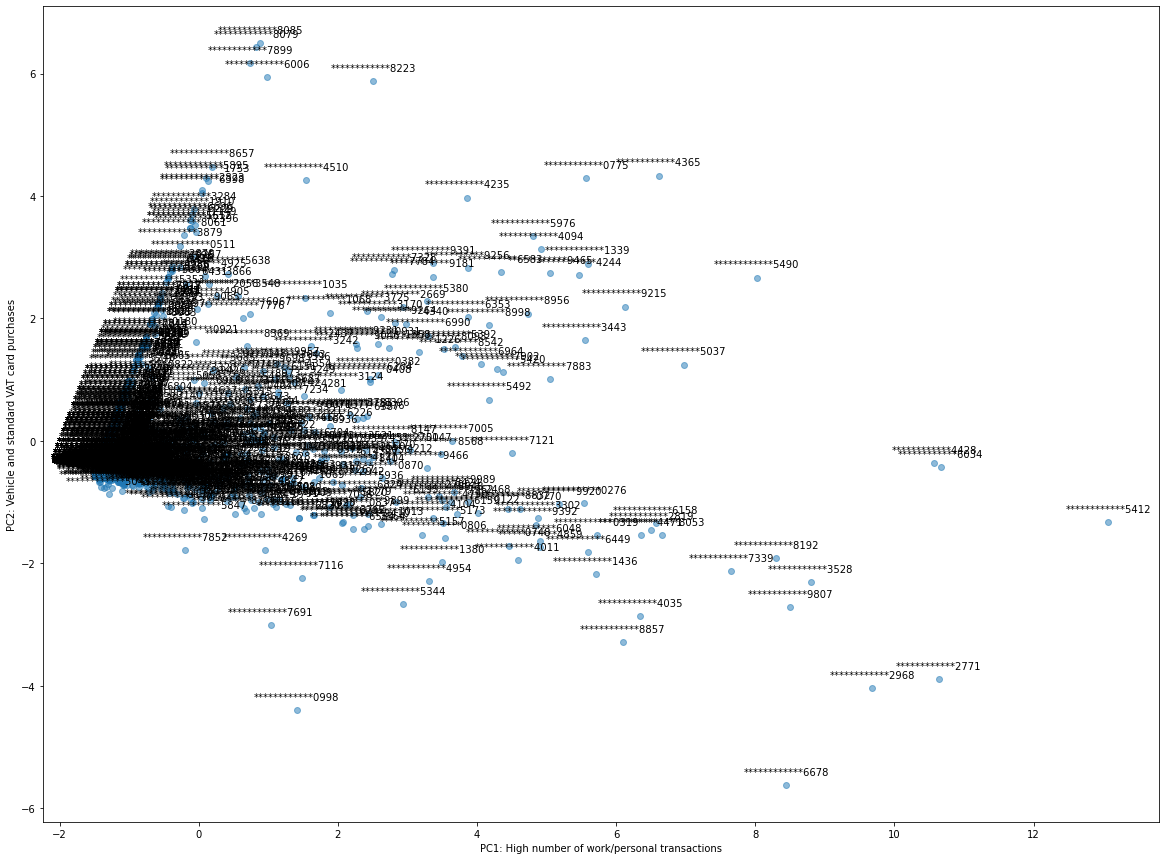

In [80]:
plt.figure(figsize=(20, 15))
plt.scatter(data2014_std_projected[:, 0], data2014_std_projected[:, 1], alpha=0.5)
plt.xlabel('PC1: High number of work/personal transactions')
plt.ylabel('PC2: Vehicle and standard VAT card purchases')
for x,y,label in zip(data2014_std_projected[:, 0], data2014_std_projected[:, 1], data2014_std.index):
    plt.annotate(label,
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center') 

We create the new dataframe with the 6 Principal Components that we will use to clusterize our clients.

In [81]:
data2014afterPCA = pd.DataFrame(data2014_std_projected)
data2014afterPCA = data2014afterPCA.loc[:,[0,1,2,3,4,5]]
data2014afterPCA.columns = ['High number of work/personal transactions', 'Vehicle and standard VAT card purchases', 'High legal expenses and transport transactions', 'High expenses in residence and legal aspects', 'Non expensive transactions not related to legal expenses nor residence', 'Transactions related to services and residence']
data2014afterPCA.set_index(data2014_std.index,inplace=True) 
data2014afterPCA

High number of work/personal transactions  \
CARD NUMBER                                                   
************0007                                  -1.102613   
************0015                                  -1.510223   
************0040                                  -1.279980   
************0047                                   3.035147   
************0057                                  -1.244730   
...                                                     ...   
************9957                                   1.126939   
************9963                                  -1.360561   
************9968                                  -1.224845   
************9971                                   0.046710   
************9989                                   3.667547   

                  Vehicle and standard VAT card purchases  \
CARD NUMBER                                                 
************0007                                -0.609923   
************0015                                -0.474573   
************0040                                 0.171561   
************0047                                -0.145967   
************0057                                -0.104075   
...                                                   ...   
************9957                                 1.249133   
************9963                                -0.450382   
************9968                                 0.199069   
************9971                                -0.869348   
************9989                                -0.836873   

                  High legal expenses and transport transactions  \
CARD NUMBER                                                        
************0007                                       -0.078921   
************0015                                       -0.049181   
************0040                                        0.070341   
************0047                                       -0.586113   
************0057                                       -0.108621   
...                                                          ...   
************9957                                       -0.095804   
************9963                                       -0.067909   
************9968                                        0.106738   
************9971                                        0.040100   
************9989                                       -3.051555   

                  High expenses in residence and legal aspects  \
CARD NUMBER                                                      
************0007                                     -0.002634   
************0015                                      0.109719   
************0040                                     -0.017045   
************0047                                      0.532373   
************0057                                      0.089445   
...                                                        ...   
************9957                                      0.050369   
************9963                                      0.153903   
************9968                                     -0.070366   
************9971                                     -0.278259   
************9989                                      2.046489   

                  Non expensive transactions not related to legal expenses nor residence  \
CARD NUMBER                                                                                
************0007                                           0.090542                        
************0015                                           0.067047                        
************0040                                           0.157104                        
************0047                                          -0.254677                        
************0057                                           0.235960                        
...             

We save the resulting dataframe from our PCA

In [82]:
df2014_after_pca_pkl_filename = '/Users/andresaristi/Documents/BirminghamCardTransactions/pickle_files/df2014_after_pca.pkl'
df2014_after_pca_pkl = open(df2014_after_pca_pkl_filename, 'wb')
pickle.dump(data2014afterPCA, df2014_after_pca_pkl)
df2014_after_pca_pkl.close()

### 4.2 Clustering

#### K-means

We are going to try first with k=3, adding a 'cluster' column with the corresponding segment.

In [83]:
kmeans2014 = KMeans(n_clusters=3, random_state=0, n_init=10)
kmeans2014.fit(data2014afterPCA)

KMeans(n_clusters=3, random_state=0)

In [84]:
print("It took K-means", kmeans2014.n_iter_, "iterations to converge, with a final WSS (Within Sum of Squares) of:",
      kmeans2014.inertia_, "and the following centroids:", kmeans2014.cluster_centers_)

It took K-means 9 iterations to converge, with a final WSS (Within Sum of Squares) of: 5867.0656223600945 and the following centroids: [[-6.62577522e-01  1.48022839e-03  1.51781172e-02 -1.97696484e-02
   1.39822263e-02 -1.40941235e-02]
 [ 3.81191507e+00  2.72299933e-02 -3.99908370e-01 -7.79427913e-02
  -1.37313764e-01  7.77915256e-02]
 [ 5.36643524e+00 -1.71588083e+00  1.47770105e+01  9.29690379e+00
   2.59764087e+00  2.71178143e-01]]


In [85]:
kmeans2014.labels_

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,

We can see the amount of observations per cluster, with unbalanced clusters, with most data points in cluster 0

In [86]:
counter = Counter(kmeans2014.labels_)
counter

Counter({0: 847, 1: 143, 2: 3})

We add a column to represent the cluster to which each row belongs.

In [106]:
data2014_kmeans = data2014afterPCA.copy()
data2014_kmeans['Cluster'] = kmeans2014.labels_
data2014_kmeans

High number of work/personal transactions  \
CARD NUMBER                                                   
************0007                                  -1.102613   
************0015                                  -1.510223   
************0040                                  -1.279980   
************0047                                   3.035147   
************0057                                  -1.244730   
...                                                     ...   
************9957                                   1.126939   
************9963                                  -1.360561   
************9968                                  -1.224845   
************9971                                   0.046710   
************9989                                   3.667547   

                  Vehicle and standard VAT card purchases  \
CARD NUMBER                                                 
************0007                                -0.609923   
************0015                                -0.474573   
************0040                                 0.171561   
************0047                                -0.145967   
************0057                                -0.104075   
...                                                   ...   
************9957                                 1.249133   
************9963                                -0.450382   
************9968                                 0.199069   
************9971                                -0.869348   
************9989                                -0.836873   

                  High legal expenses and transport transactions  \
CARD NUMBER                                                        
************0007                                       -0.078921   
************0015                                       -0.049181   
************0040                                        0.070341   
************0047                                       -0.586113   
************0057                                       -0.108621   
...                                                          ...   
************9957                                       -0.095804   
************9963                                       -0.067909   
************9968                                        0.106738   
************9971                                        0.040100   
************9989                                       -3.051555   

                  High expenses in residence and legal aspects  \
CARD NUMBER                                                      
************0007                                     -0.002634   
************0015                                      0.109719   
************0040                                     -0.017045   
************0047                                      0.532373   
************0057                                      0.089445   
...                                                        ...   
************9957                                      0.050369   
************9963                                      0.153903   
************9968                                     -0.070366   
************9971                                     -0.278259   
************9989                                      2.046489   

                  Non expensive transactions not related to legal expenses nor residence  \
CARD NUMBER                                                                                
************0007                                           0.090542                        
************0015                                           0.067047                        
************0040                                           0.157104                        
************0047                                          -0.254677                        
************0057                                           0.235960                        
...             

We save the resulting dataframe from our k-means with k = 3.

In [107]:
df2014_kmeans3_pkl_filename = '/Users/andresaristi/Documents/BirminghamCardTransactions/pickle_files/df2014_kmeans3.pkl'
df2014_kmeans3_pkl = open(df2014_kmeans3_pkl_filename, 'wb')
pickle.dump(data2014_kmeans, df2014_kmeans3_pkl)
df2014_kmeans3_pkl.close()

#### Interpretation of k-means using k=3

We, by using these density plots, are going to understand the different characteristics of each cluster according to the observations which belong to each of them.

By observing the plots we are able to understand the type and amount of card transactions' purchases of each group of clients.

<b>Cluster 0:</b> the most densely populated. 847 data points. The clients belonging to this segment do not make high number of card purchases related to work, personal needs, legal expenses nor affairs related to their residences. They have average transactions that are non expensive and not related to legal expenses nor residences. They have average transactions on services.

<b>Cluster 1:</b> 143 data points. These clients have less than average on high number of work and personal transactions. The purchases related to these clients increase when talking about vehicles and standard items (which have the added value tax VR). They do not expend much in legal aspects and transport. The have less than average transactions on services. On average make non expensive transactions. These clients make transactions, on average, on residence matters.

<b>Cluster 2:</b> the least densely populated cluster with only 3 data points. Since there are so few clientes the distribution is wider over all the new features.

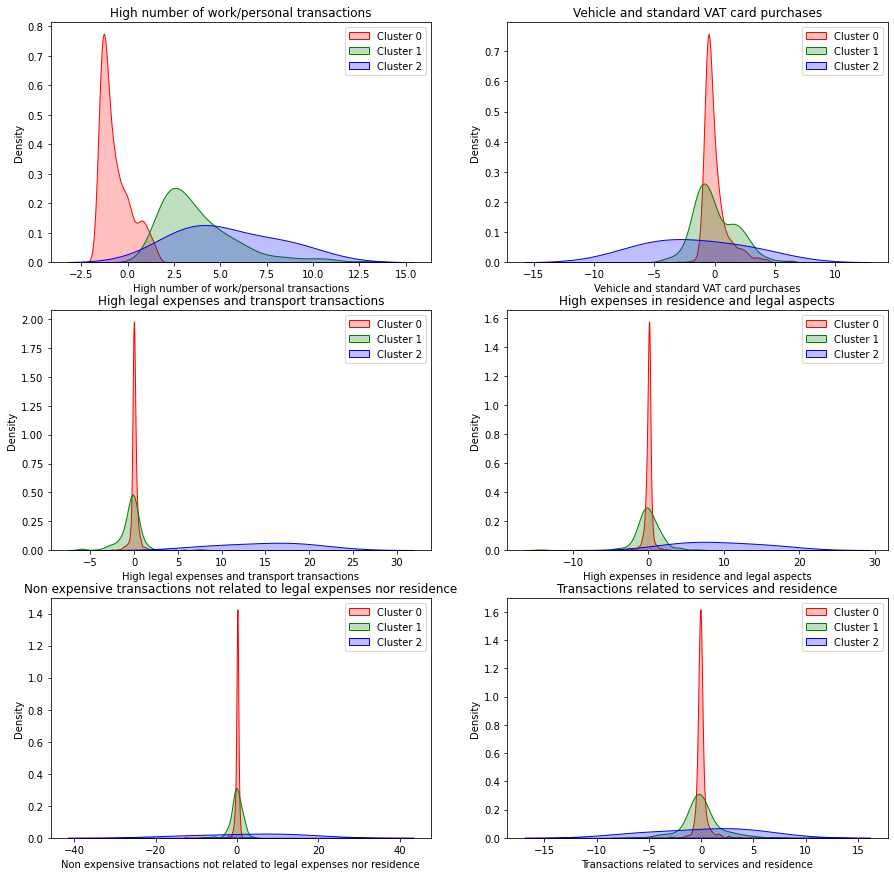

In [108]:
var_num = data2014_kmeans.columns[0:6]
fig = plt.figure(figsize=(15,15))
i=1
for var in var_num:
    ax = fig.add_subplot(math.ceil(len(var_num)/2), 2, i)
    sns.kdeplot(data2014_kmeans.loc[data2014_kmeans.Cluster==0][var], shade=True, color='r', ax=ax);
    sns.kdeplot(data2014_kmeans.loc[data2014_kmeans.Cluster==1][var], shade=True, color='g', ax=ax);
    sns.kdeplot(data2014_kmeans.loc[data2014_kmeans.Cluster==2][var], shade=True, color='b', ax=ax);
    plt.title(var)
    plt.legend(['Cluster 0', 'Cluster 1', 'Cluster 2'])
    i+=1

We will see the scatterplots to better understand the differences

The other elements observed in the scatter plots confirm our description of the two other clusters.

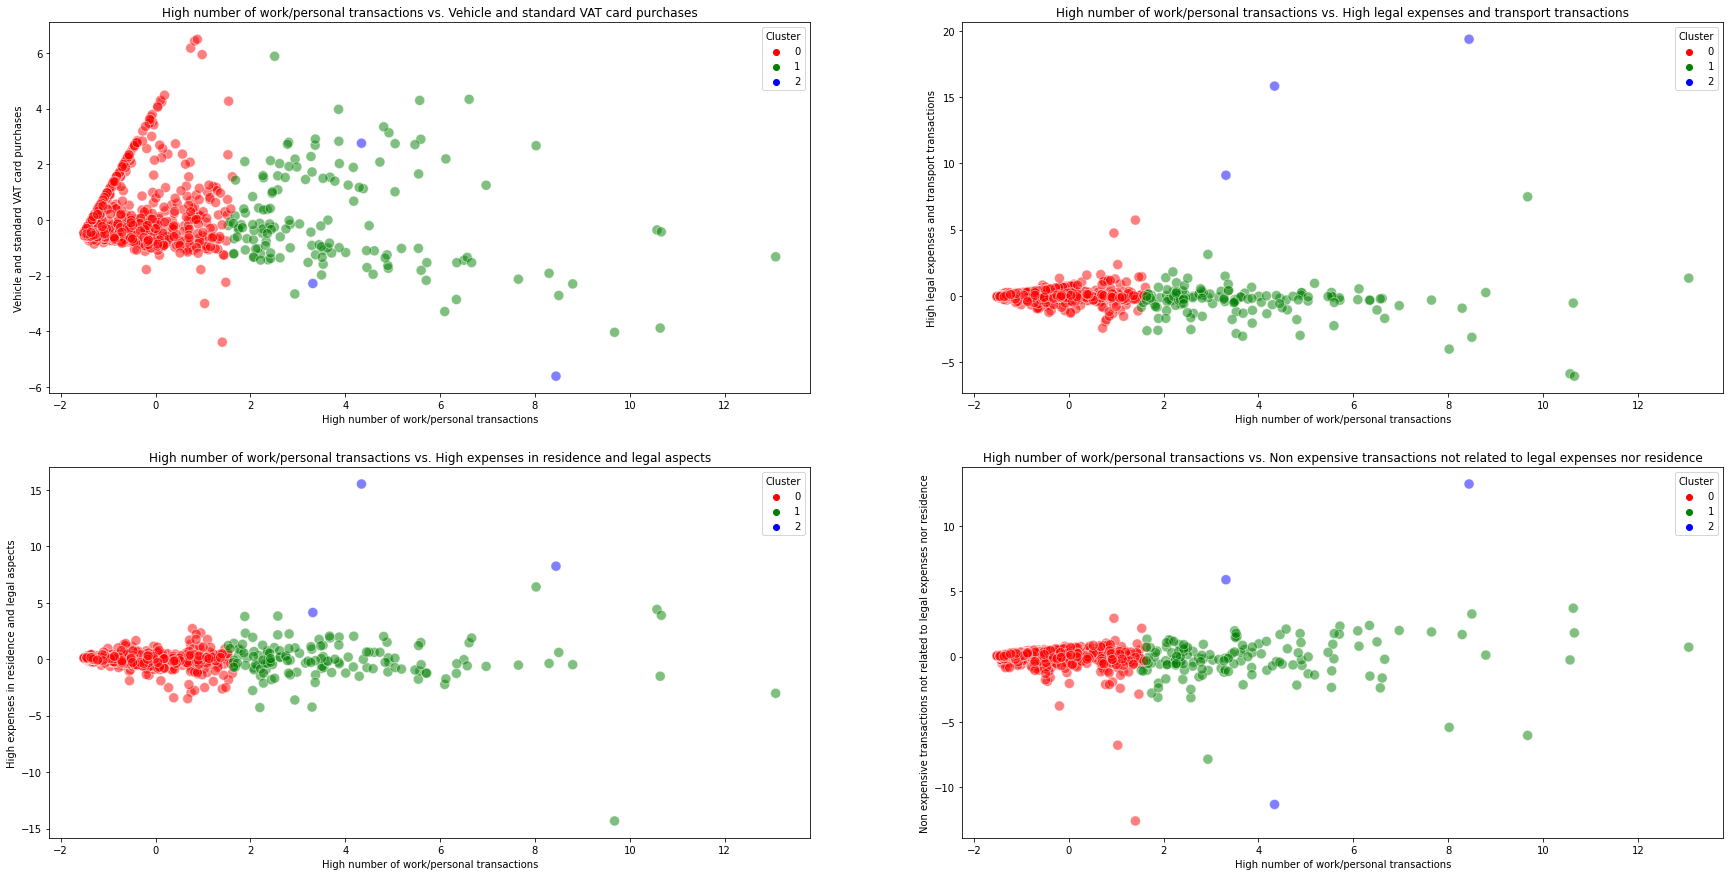

In [109]:
fig = plt.figure(figsize=(30,15))
colorPalette = ["r", "g", "b"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x='High number of work/personal transactions', y='Vehicle and standard VAT card purchases', hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High number of work/personal transactions vs. Vehicle and standard VAT card purchases")
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(x="High number of work/personal transactions", y="High legal expenses and transport transactions", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High number of work/personal transactions vs. High legal expenses and transport transactions")
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(x="High number of work/personal transactions", y="High expenses in residence and legal aspects", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High number of work/personal transactions vs. High expenses in residence and legal aspects")
ax = fig.add_subplot(2, 2, 4)
sns.scatterplot(x='High number of work/personal transactions', y='Non expensive transactions not related to legal expenses nor residence', hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High number of work/personal transactions vs. Non expensive transactions not related to legal expenses nor residence")
plt.show()

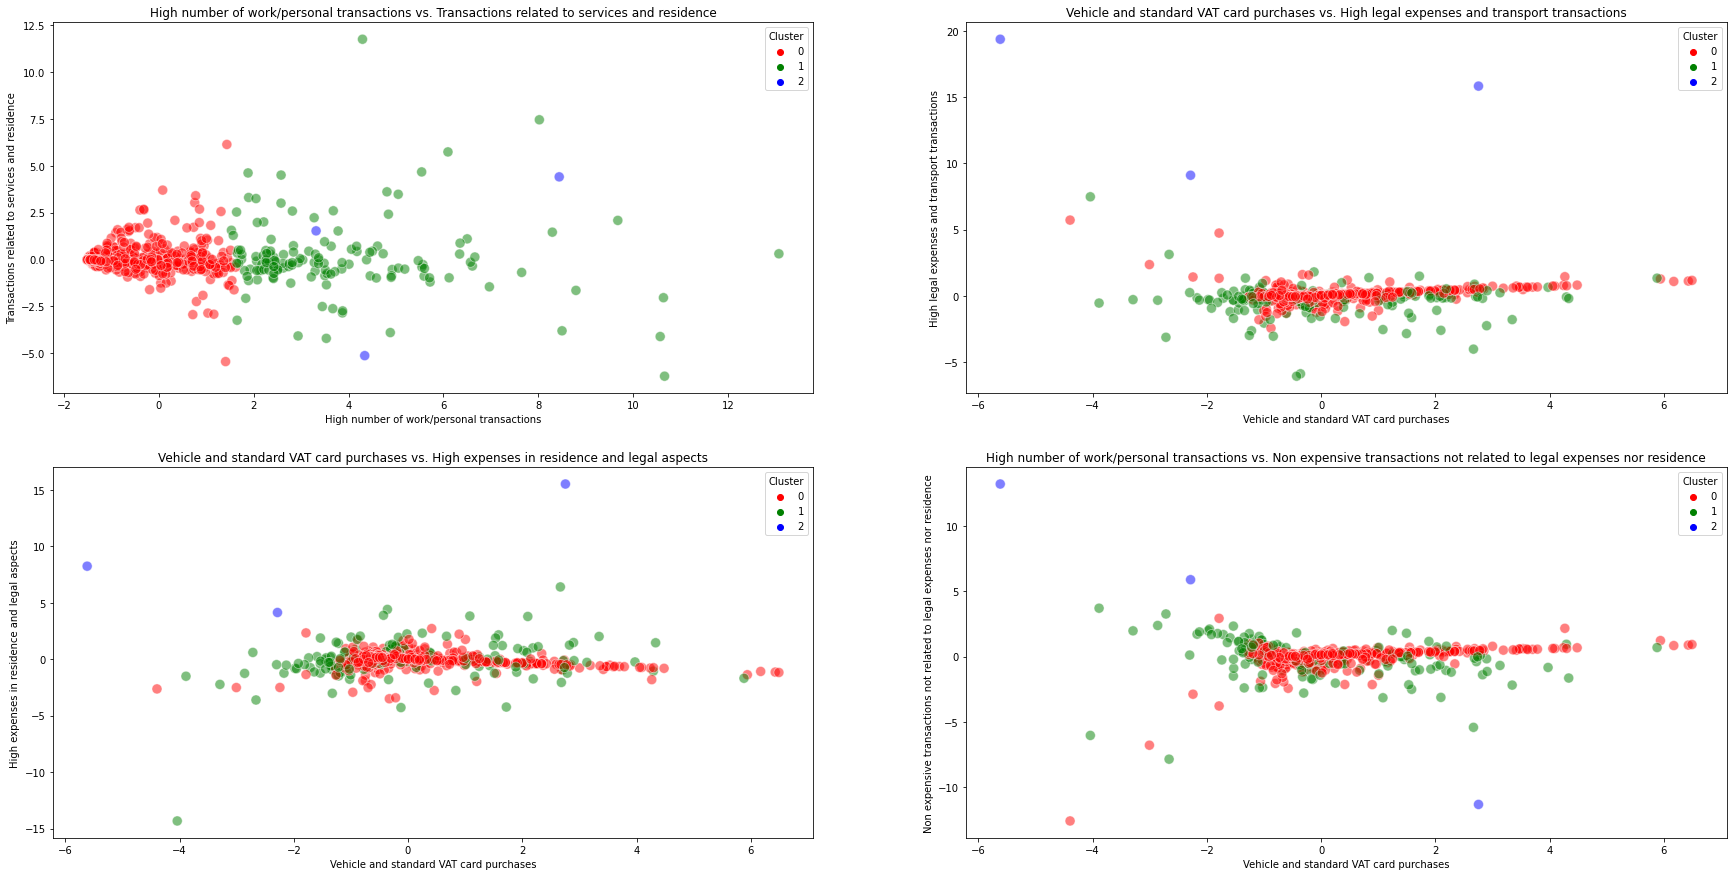

In [110]:
fig = plt.figure(figsize=(30,15))
colorPalette = ["r", "g", "b"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="High number of work/personal transactions", y="Transactions related to services and residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High number of work/personal transactions vs. Transactions related to services and residence")
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(x="Vehicle and standard VAT card purchases", y="High legal expenses and transport transactions", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("Vehicle and standard VAT card purchases vs. High legal expenses and transport transactions")
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(x='Vehicle and standard VAT card purchases', y='High expenses in residence and legal aspects', hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("Vehicle and standard VAT card purchases vs. High expenses in residence and legal aspects")
ax = fig.add_subplot(2, 2, 4)
sns.scatterplot(x="Vehicle and standard VAT card purchases", y="Non expensive transactions not related to legal expenses nor residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High number of work/personal transactions vs. Non expensive transactions not related to legal expenses nor residence")
plt.show()

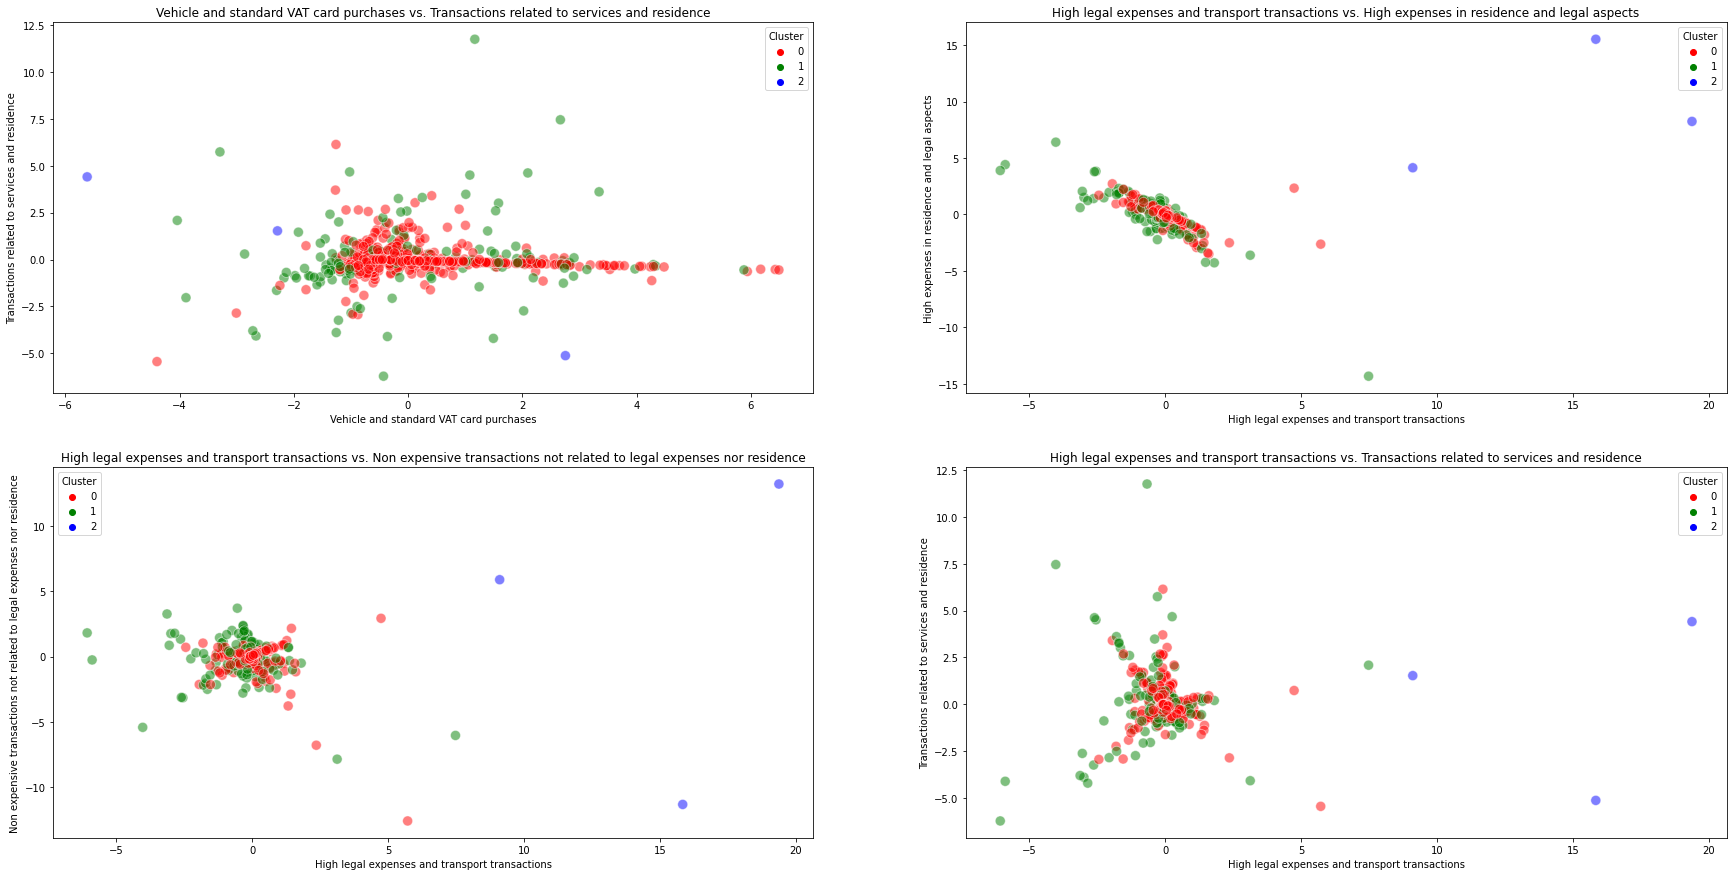

In [111]:
fig = plt.figure(figsize=(30,15))
colorPalette = ["r", "g", "b"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="Vehicle and standard VAT card purchases", y="Transactions related to services and residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("Vehicle and standard VAT card purchases vs. Transactions related to services and residence")
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(x='High legal expenses and transport transactions', y='High expenses in residence and legal aspects', hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High legal expenses and transport transactions vs. High expenses in residence and legal aspects")
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(x="High legal expenses and transport transactions", y="Non expensive transactions not related to legal expenses nor residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High legal expenses and transport transactions vs. Non expensive transactions not related to legal expenses nor residence")
ax = fig.add_subplot(2, 2, 4)
sns.scatterplot(x="High legal expenses and transport transactions", y="Transactions related to services and residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High legal expenses and transport transactions vs. Transactions related to services and residence")
plt.show()

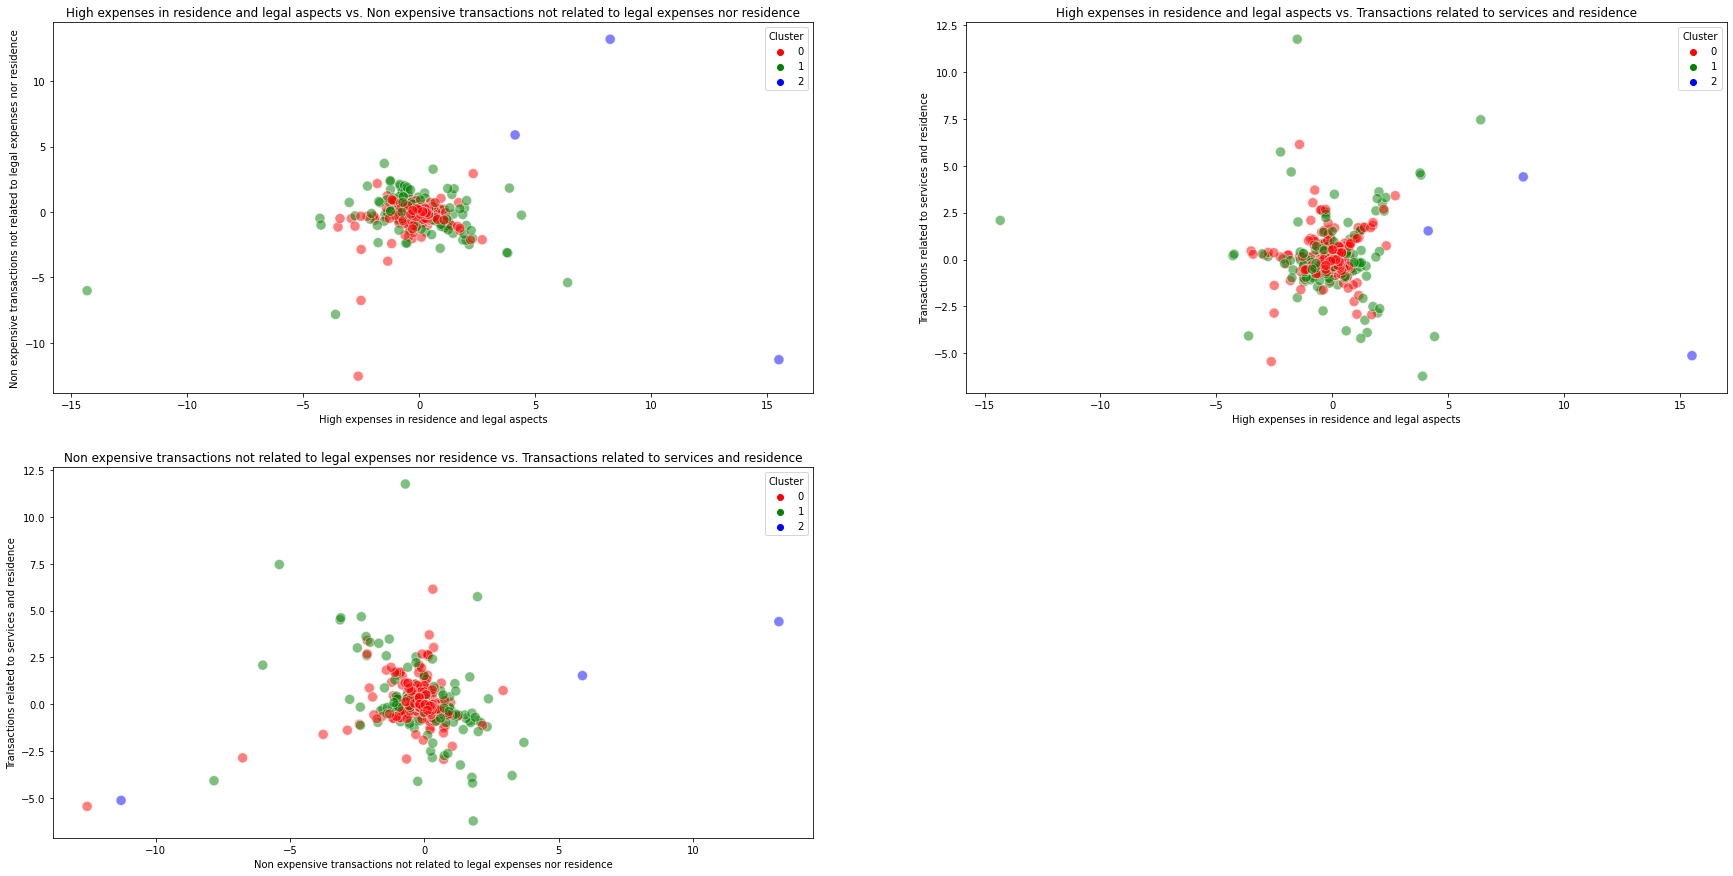

In [112]:
fig = plt.figure(figsize=(30,15))
colorPalette = ["r", "g", "b"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="High expenses in residence and legal aspects", y="Non expensive transactions not related to legal expenses nor residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High expenses in residence and legal aspects vs. Non expensive transactions not related to legal expenses nor residence")
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(x="High expenses in residence and legal aspects", y="Transactions related to services and residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High expenses in residence and legal aspects vs. Transactions related to services and residence")
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(x="Non expensive transactions not related to legal expenses nor residence", y="Transactions related to services and residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("Non expensive transactions not related to legal expenses nor residence vs. Transactions related to services and residence")
plt.show()

#### Determining the right k

#### Elbow method

By using the Within Sum of Squares (WSS) values we will create a plot by which we will apply the elbow method, and  cluster using different k values.

In [94]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(data2014_kmeans)
    WSSs.append(km.inertia_)
WSSs

[9507.775947632981,
 6843.184481678275,
 5867.0656223600945,
 5240.250303442649,
 4682.01763222187,
 4122.937874083134,
 3672.437991421091,
 3187.8810816845394,
 2857.6306860727555,
 2673.814534089913,
 2495.101837315456,
 2323.469936835077,
 2173.192451369397,
 2016.1816118789964]

We found out that with this technique the ideal k seems to be 2, 3, 8 or 9.

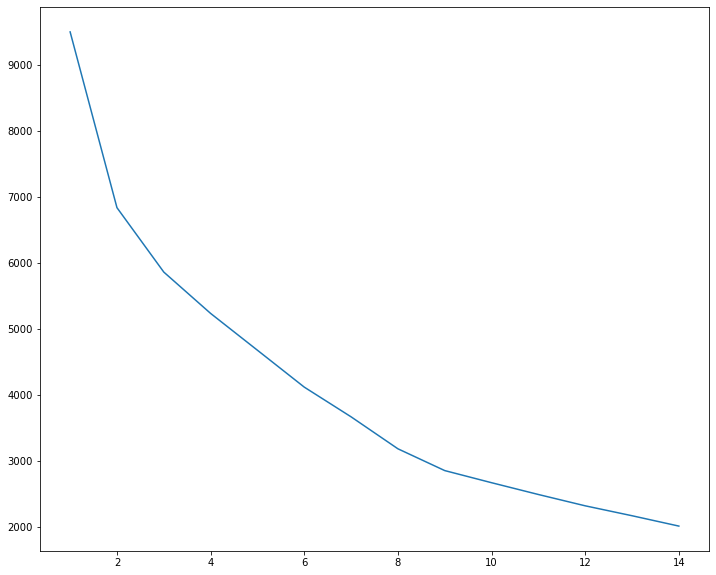

In [95]:
plt.figure(figsize=(12,10))
plt.plot(range(1, 15), WSSs)

#### Silhouette method

By using the silhoutte method we will try to find a different approach to the number of clusters that we will need for our dataset. 

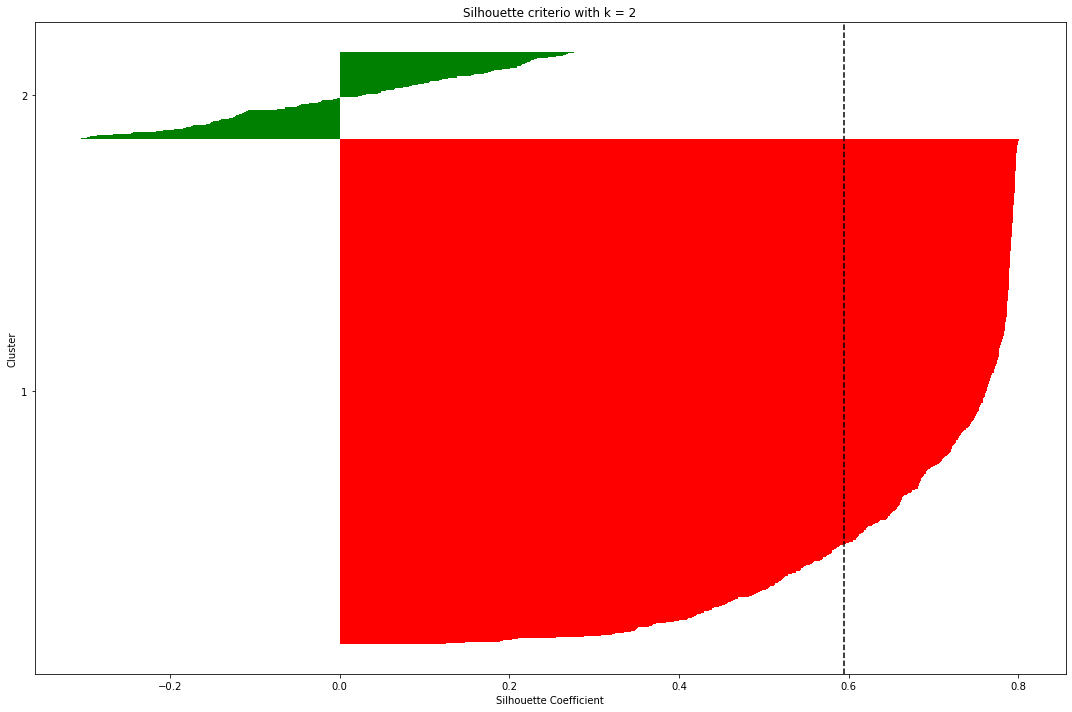

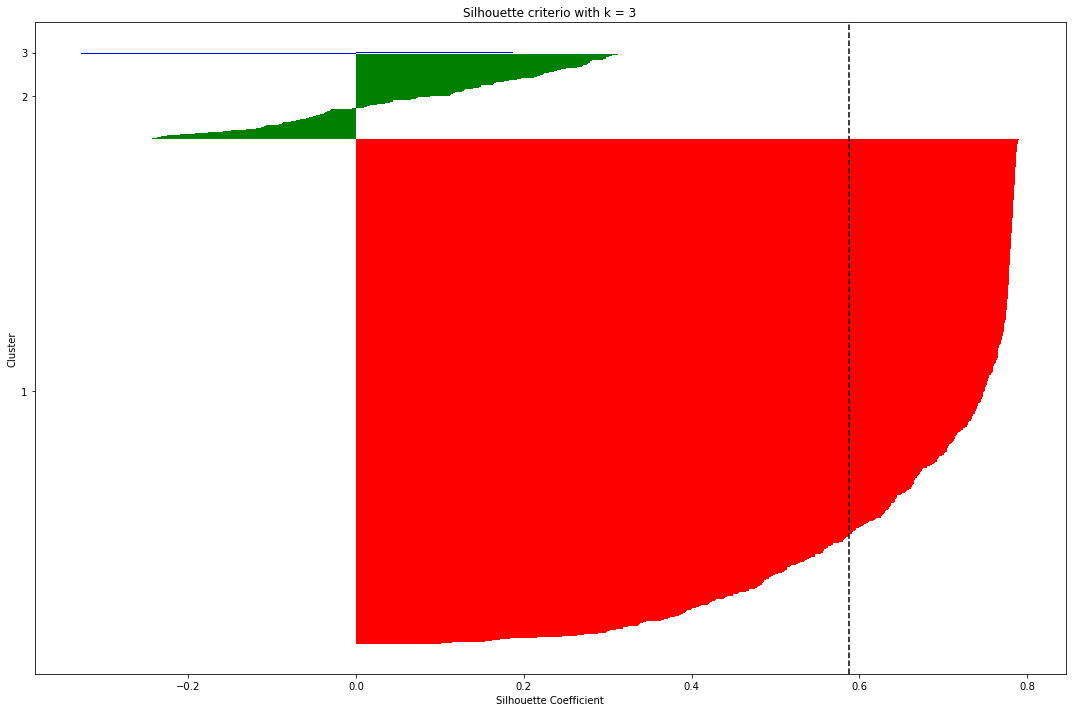

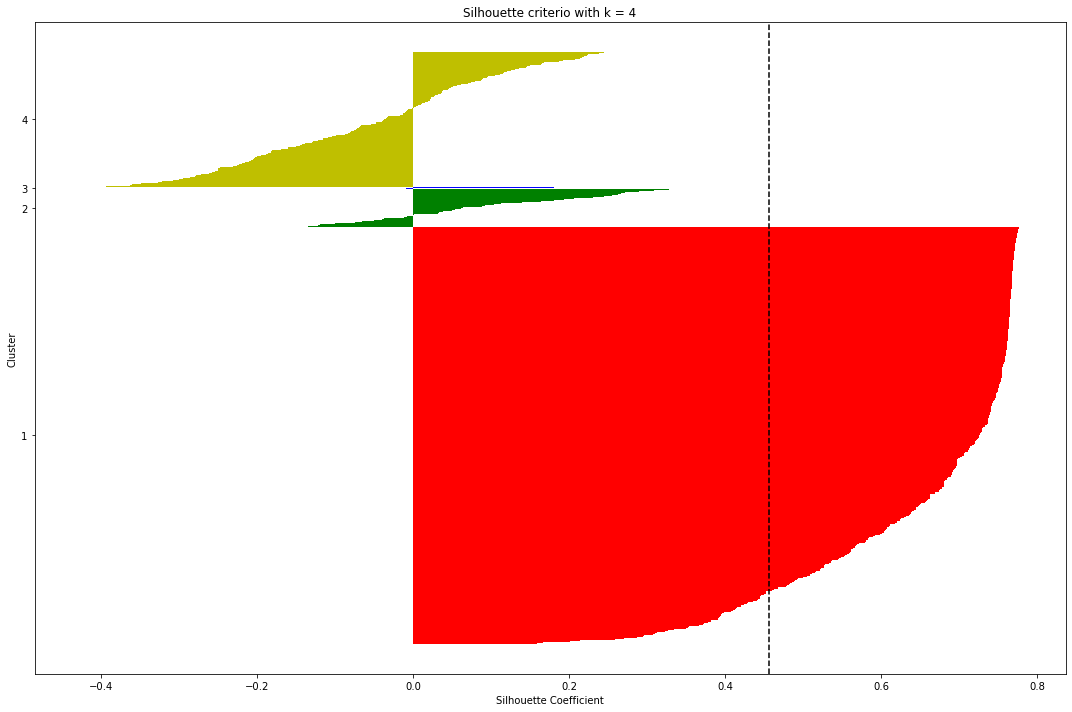

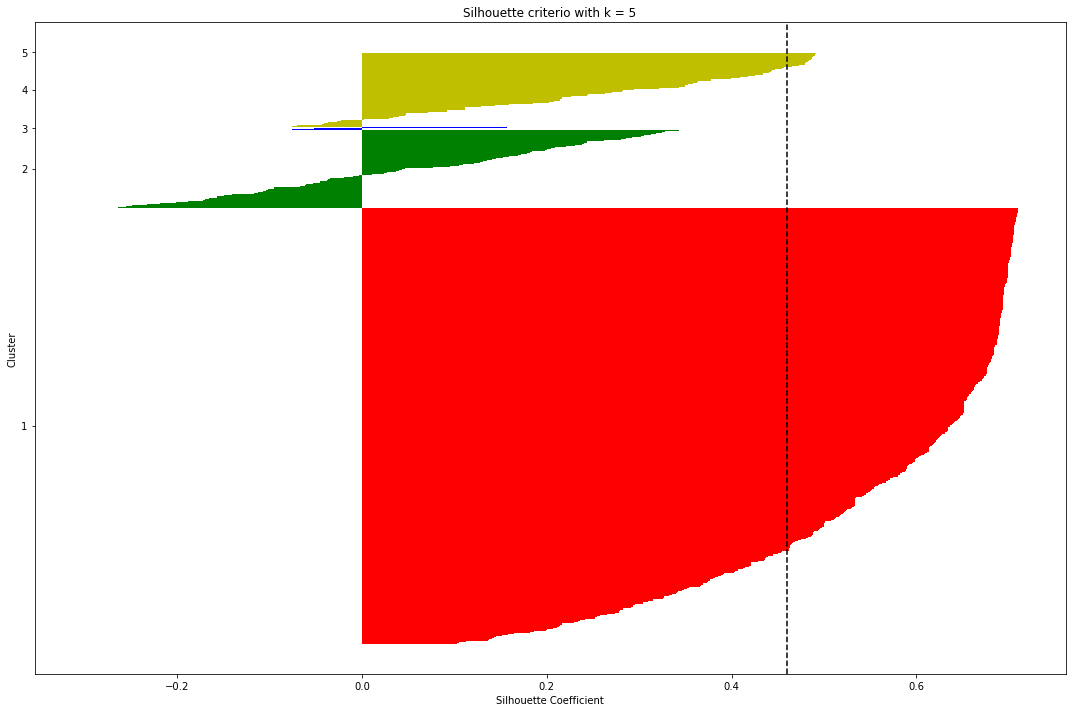

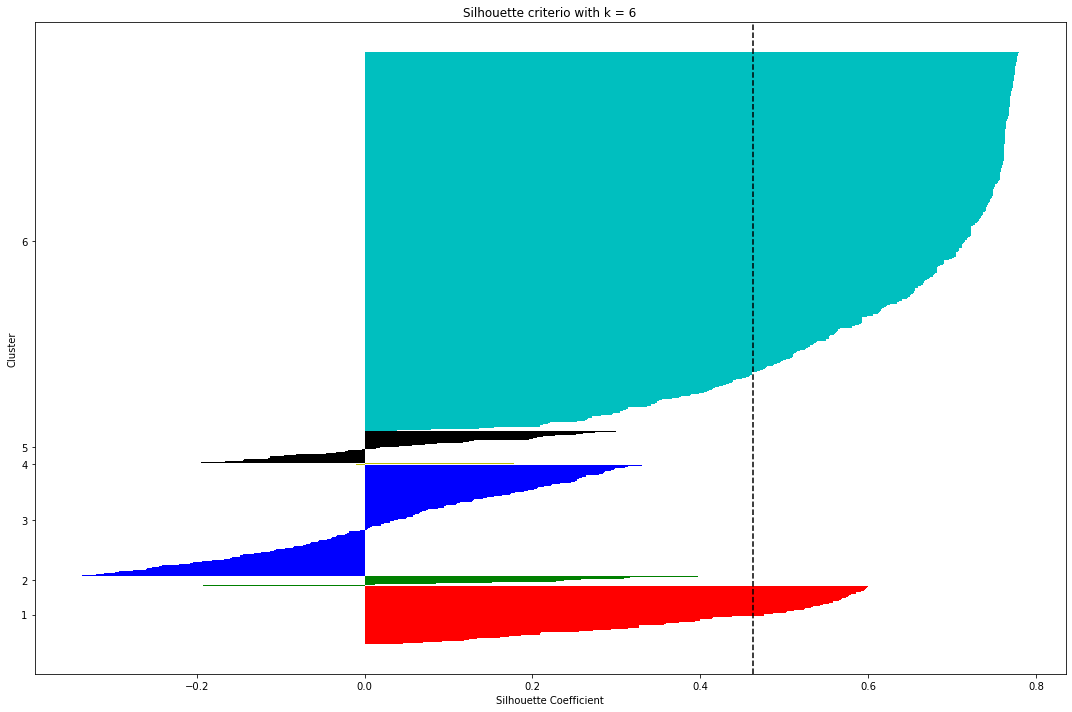

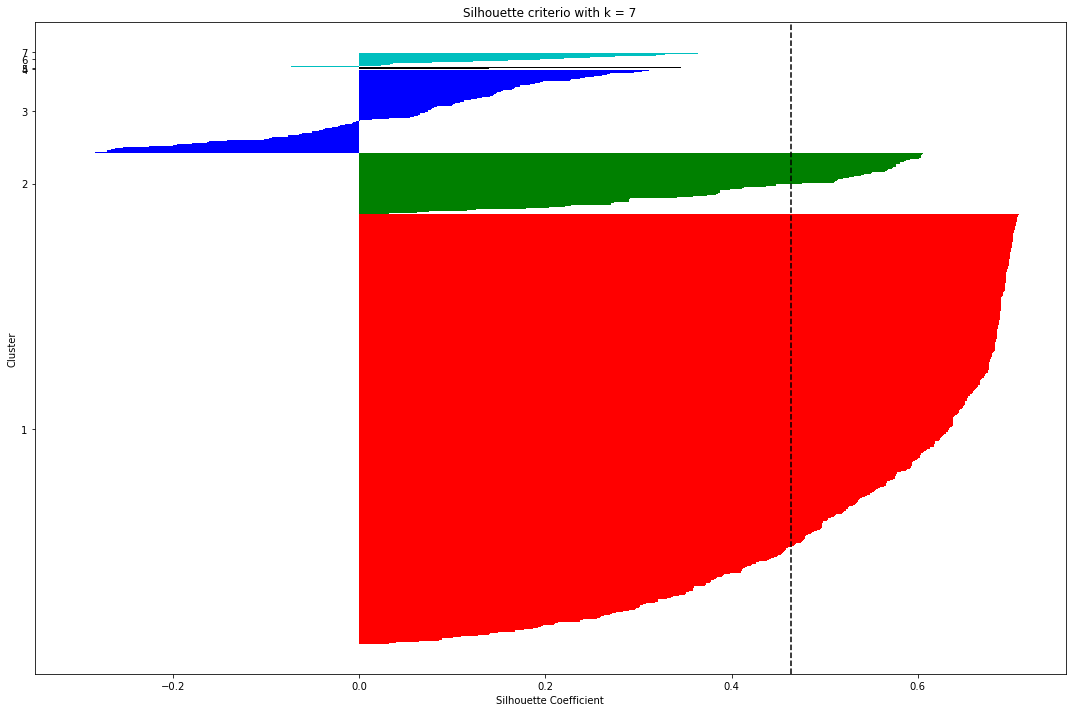

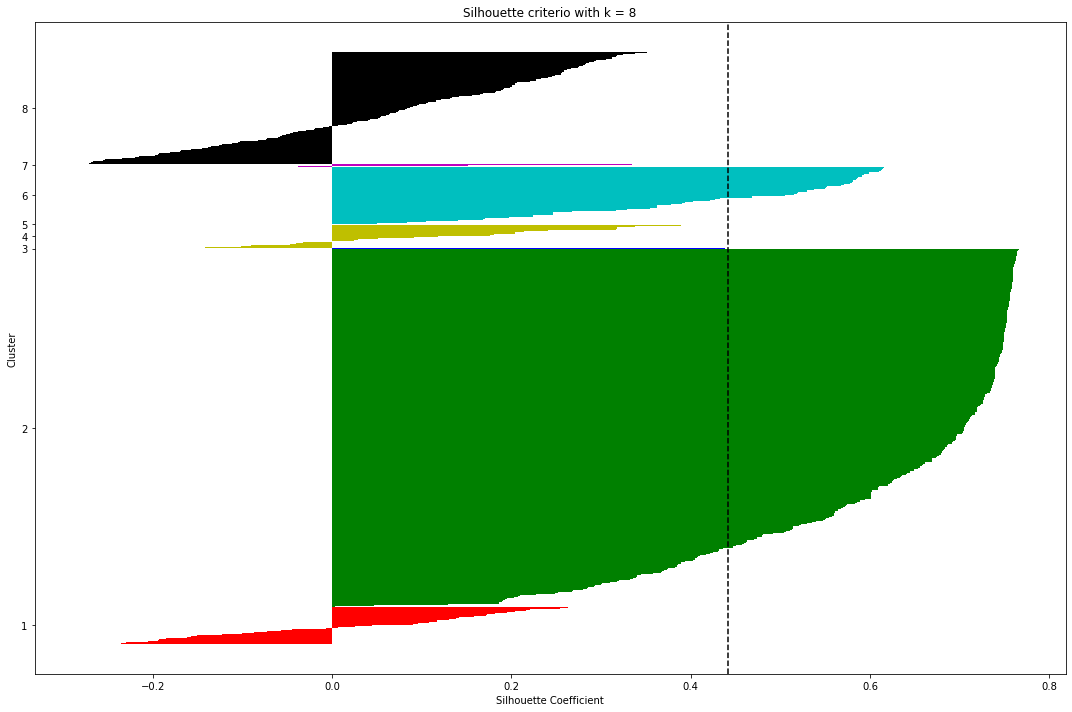

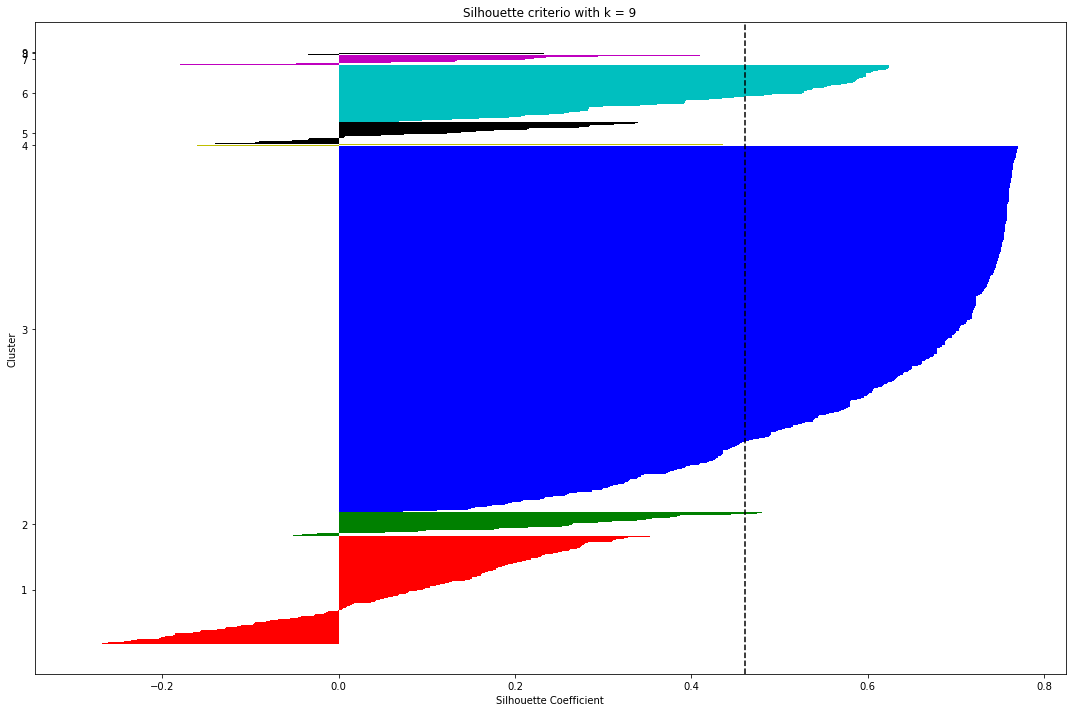

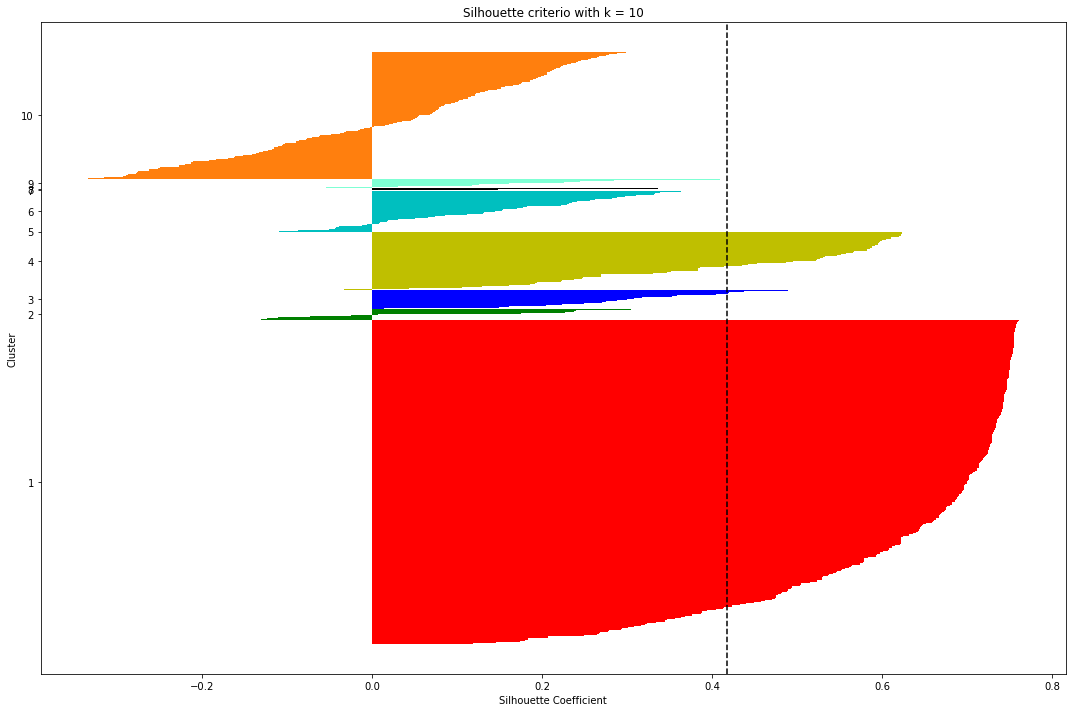

In [96]:

k_values = [2,3,4,5,6,7,8,9,10]
for k in k_values:
    
    plt.figure(figsize=(15,10))

    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(data2014_kmeans)
    y_clusters = kmeans.labels_
    cluster_labels = np.unique(y_clusters)

    silhouette_points= silhouette_samples(data2014_kmeans, y_clusters, metric='euclidean')

    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    colors = ['r', 'g', 'b', 'y', '0', 'c', 'm', 'k','aquamarine','tab:orange']
    for i, c in enumerate(cluster_labels):
        silhouette_points_c = silhouette_points[y_clusters == c]
        silhouette_points_c.sort()
        y_ax_upper += len(silhouette_points_c)
        color = colors[i]
        plt.barh(range(y_ax_lower, y_ax_upper), silhouette_points_c, height=1.0, 
                 edgecolor='none', color=color)

        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(silhouette_points_c)
    
    silhouette_mean = np.mean(silhouette_points)
    plt.axvline(silhouette_mean, color="black", linestyle="--") 

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette Coefficient')
    plt.title(f'Silhouette criterio with k = {k}')
    plt.tight_layout()
    plt.show()

After analyzing the results from the silhouette method we found out that in each possibility at least a cluster has a negative value for their Silhouette coefficients and not all of them surpass de average silhouette score.

Nevertheless the best one is k=9 where more clusters surpass the average silhuette coefficient. k=2 does not seem that bad using this method, by taking into account the business intelligence criterion it may not be the right approach. We will look at it later after analyzing the results of the next heuristic.

#### Calinski-Harabasz

Finally, in order to be thorough, we will apply the Calinski-Harabasz criterion to have a new tool in order to choose the right k.

In [97]:
CHs = []
for i in range(2,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(data2014_kmeans)
    CH = calinski_harabasz_score(data2014_kmeans, km.labels_) 
    CHs.append(CH)
CHs

[385.8744638305435,
 307.1640453690942,
 268.4720905622556,
 254.58304464797408,
 257.8193225494758,
 261.1182379963743,
 278.96256763172346,
 286.23988087699394,
 279.1603478524493,
 275.9985934578568,
 275.75543899236544,
 275.6272161495632,
 279.82742431653276]

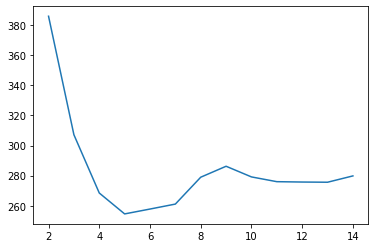

In [98]:
plt.plot(range(2, 15), CHs)

Accoring to de Calinski-Harabasz criterion we found out that the ideal k would be 2. 3 and even 9 seem like good candidates. 2 and 9 agree with the two previous heuristics.

We will use k = 9 and k = 2 (2 clusters seems to little to profile clients but we will see the results that it presents us)

From the business point it would be advisable to identify more clusters (i.e. 4) in order, for example, to profile clients and be able to establish specific marketing campaigns for each of these clients in order for them to increase their purchases (not only related to the amount of the transactions, but to the quantity paid for a product). It is important to find out different groups so the company or companies may offer special deals for products that they may want.

### K-means with k = 9

In [121]:
kmeans2014_k9 = KMeans(n_clusters=9, random_state=0, n_init=10)
kmeans2014_k9.fit(data2014_kmeans)

KMeans(n_clusters=9, random_state=0)

In [122]:
print("It took K-means", kmeans2014_k9.n_iter_, "iterations to converge, with a final WSS (Within Sum of Squares) of:",
      kmeans2014_k9.inertia_, "and the following centroids:", kmeans2014_k9.cluster_centers_)

It took K-means 13 iterations to converge, with a final WSS (Within Sum of Squares) of: 2857.6306860727555 and the following centroids: [[ 1.18346013e+00 -3.75628041e-01 -7.22358052e-02 -1.40538629e-01
  -1.30905455e-01 -4.75766606e-02  2.91208791e-01]
 [ 3.78139735e+00  2.08763926e+00 -1.09291610e-01 -1.03913968e-01
  -2.06301882e-01 -2.53664493e-01  1.00000000e+00]
 [-1.03169380e+00 -3.00195552e-01 -5.02387760e-02  7.07925146e-02
   1.79130070e-02  2.12711969e-02 -4.16333634e-16]
 [ 5.87904684e+00 -3.95120534e+00  1.42443921e+01  6.18770172e+00
   9.54445792e+00  2.97146617e+00  2.00000000e+00]
 [ 5.94488755e+00 -1.52360538e+00 -9.23368680e-01 -7.87202512e-02
   1.01344728e+00 -8.26816911e-01  1.00000000e+00]
 [-2.97341231e-01  2.39806088e+00  4.51899933e-01 -4.58148061e-01
   4.33690359e-01 -2.41249162e-01  5.55111512e-17]
 [ 3.08460750e+00  9.11092093e-01 -1.52391570e+00  1.78918718e+00
  -2.08271735e+00  4.30909709e+00  7.50000000e-01]
 [ 3.76392059e+00 -3.52542517e+00  4.67202596

In [123]:
kmeans2014_k9.labels_

array([2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 4, 2, 2, 2, 0, 0, 2, 2, 5, 2, 2,
       2, 2, 0, 0, 2, 6, 2, 2, 2, 2, 0, 4, 2, 2, 2, 2, 6, 0, 0, 2, 2, 2,
       0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 5, 2, 0, 2, 2, 2, 5, 2, 2,
       2, 2, 0, 2, 2, 2, 4, 0, 4, 2, 1, 0, 4, 2, 5, 0, 2, 2, 0, 5, 2, 0,
       5, 0, 2, 2, 2, 2, 5, 6, 2, 2, 0, 2, 2, 2, 7, 5, 2, 0, 2, 5, 0, 6,
       0, 2, 2, 5, 2, 2, 0, 5, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 0, 2, 1, 2, 1, 2, 2, 2, 4, 2, 0, 2, 0, 2, 2, 4, 2, 0, 2, 5, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 5, 0, 2, 2, 2, 0, 2, 2,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 5, 2, 0, 2, 2, 0, 2, 2,
       2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 5,
       2, 5, 2, 4, 2, 5, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 1, 2, 0, 0,
       2, 2, 0, 2, 0, 4, 2, 2, 0, 2, 4, 5, 2, 2, 2, 5, 2, 2, 2, 2, 0, 7,
       2, 2, 5, 2, 2, 0, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 6,
       1, 2, 2, 2, 2, 0, 2, 5, 4, 2, 5, 0, 2, 2, 2,

We can se by counting the labels resulting from the k-means, that there exist 3 clusters with not many observations, so it would be difficult to profile those clients. Later on we will compare the results 

In [124]:
counter = Counter(kmeans2014_k9.labels_)
counter

Counter({2: 615, 0: 182, 4: 37, 5: 97, 6: 16, 1: 39, 7: 4, 3: 2, 8: 1})

In [125]:
data2014_kmeans['Cluster'] = kmeans2014_k9.labels_
data2014_kmeans

High number of work/personal transactions  \
CARD NUMBER                                                   
************0007                                  -1.102613   
************0015                                  -1.510223   
************0040                                  -1.279980   
************0047                                   3.035147   
************0057                                  -1.244730   
...                                                     ...   
************9957                                   1.126939   
************9963                                  -1.360561   
************9968                                  -1.224845   
************9971                                   0.046710   
************9989                                   3.667547   

                  Vehicle and standard VAT card purchases  \
CARD NUMBER                                                 
************0007                                -0.609923   
************0015                                -0.474573   
************0040                                 0.171561   
************0047                                -0.145967   
************0057                                -0.104075   
...                                                   ...   
************9957                                 1.249133   
************9963                                -0.450382   
************9968                                 0.199069   
************9971                                -0.869348   
************9989                                -0.836873   

                  High legal expenses and transport transactions  \
CARD NUMBER                                                        
************0007                                       -0.078921   
************0015                                       -0.049181   
************0040                                        0.070341   
************0047                                       -0.586113   
************0057                                       -0.108621   
...                                                          ...   
************9957                                       -0.095804   
************9963                                       -0.067909   
************9968                                        0.106738   
************9971                                        0.040100   
************9989                                       -3.051555   

                  High expenses in residence and legal aspects  \
CARD NUMBER                                                      
************0007                                     -0.002634   
************0015                                      0.109719   
************0040                                     -0.017045   
************0047                                      0.532373   
************0057                                      0.089445   
...                                                        ...   
************9957                                      0.050369   
************9963                                      0.153903   
************9968                                     -0.070366   
************9971                                     -0.278259   
************9989                                      2.046489   

                  Non expensive transactions not related to legal expenses nor residence  \
CARD NUMBER                                                                                
************0007                                           0.090542                        
************0015                                           0.067047                        
************0040                                           0.157104                        
************0047                                          -0.254677                        
************0057                                           0.235960                        
...             

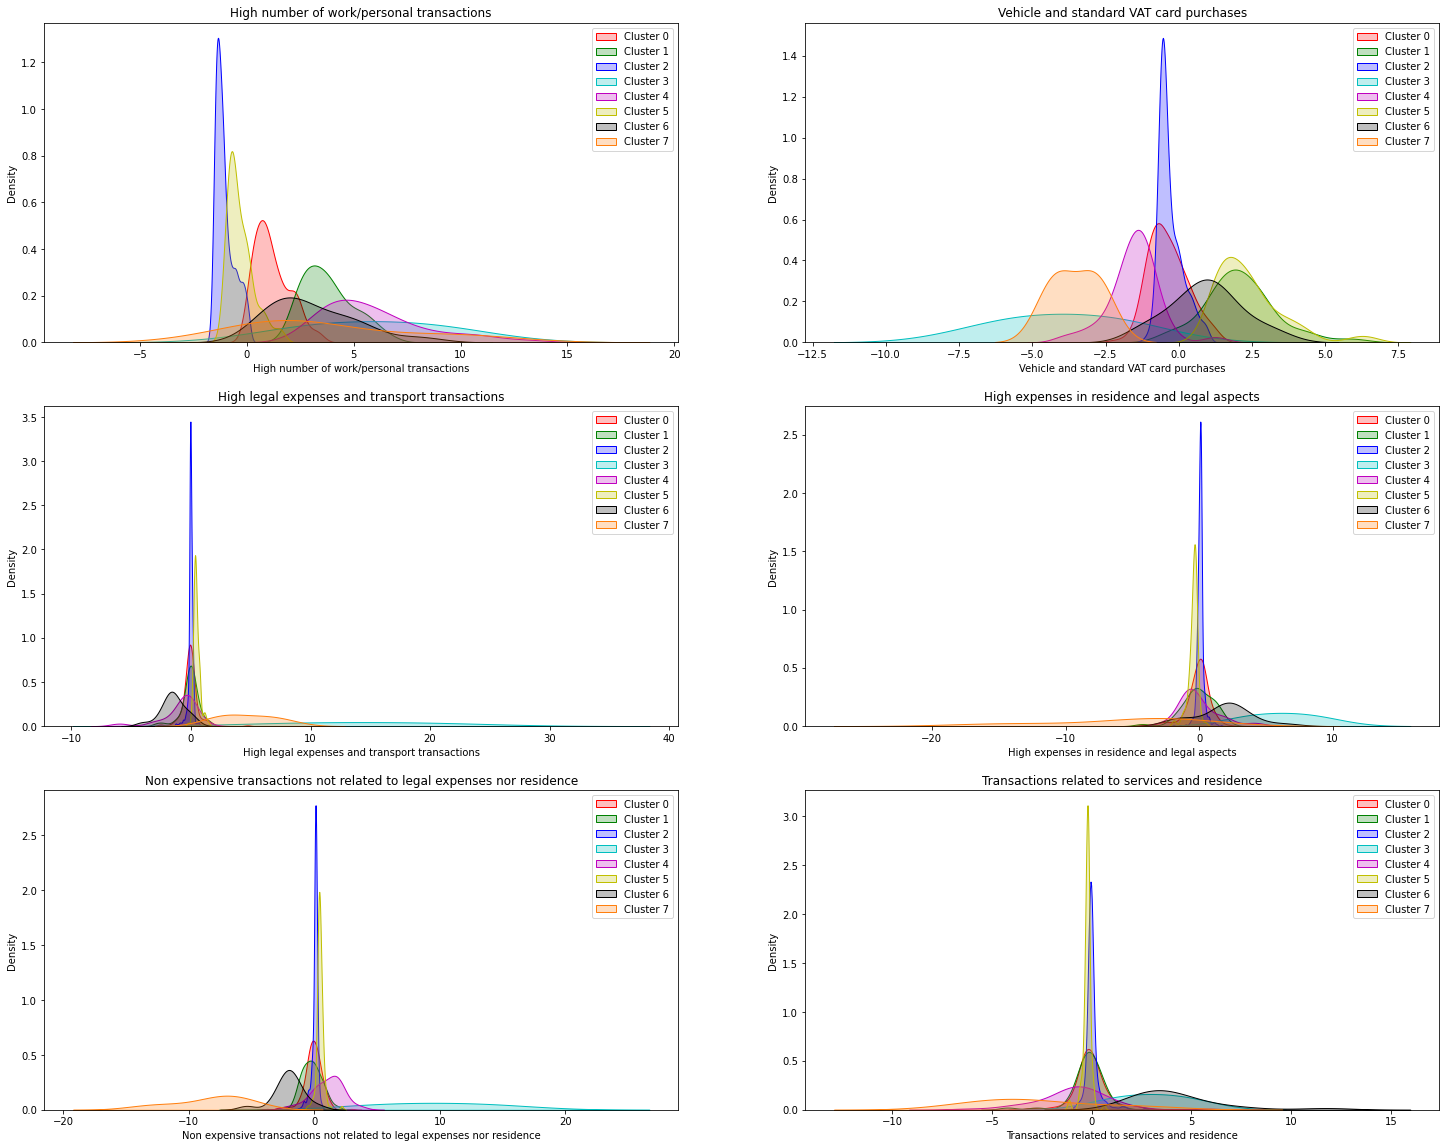

In [133]:
var_num = data2014_kmeans.columns[0:6]
fig = plt.figure(figsize=(25,20))
i=1
for var in var_num:
    ax = fig.add_subplot(math.ceil(len(var_num)/2), 2, i)
    sns.kdeplot(data2014_kmeans.loc[data2014_kmeans.Cluster==0][var], shade=True, color='r', ax=ax);
    sns.kdeplot(data2014_kmeans.loc[data2014_kmeans.Cluster==1][var], shade=True, color='g', ax=ax);
    sns.kdeplot(data2014_kmeans.loc[data2014_kmeans.Cluster==2][var], shade=True, color='b', ax=ax);
    sns.kdeplot(data2014_kmeans.loc[data2014_kmeans.Cluster==3][var], shade=True, color='c', ax=ax);
    sns.kdeplot(data2014_kmeans.loc[data2014_kmeans.Cluster==4][var], shade=True, color='m', ax=ax);
    sns.kdeplot(data2014_kmeans.loc[data2014_kmeans.Cluster==5][var], shade=True, color='y', ax=ax);
    sns.kdeplot(data2014_kmeans.loc[data2014_kmeans.Cluster==6][var], shade=True, color='k', ax=ax);
    sns.kdeplot(data2014_kmeans.loc[data2014_kmeans.Cluster==7][var], shade=True, color='tab:orange', ax=ax);
    sns.kdeplot(data2014_kmeans.loc[data2014_kmeans.Cluster==8][var], shade=True, color='tab:olive', ax=ax);
    plt.title(var)
    plt.legend(['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7','Cluster 8' ])
    i+=1

We will see the scatterplots to better understand the differences

The other elements observed in the scatter plots confirm our description of the two other clusters.

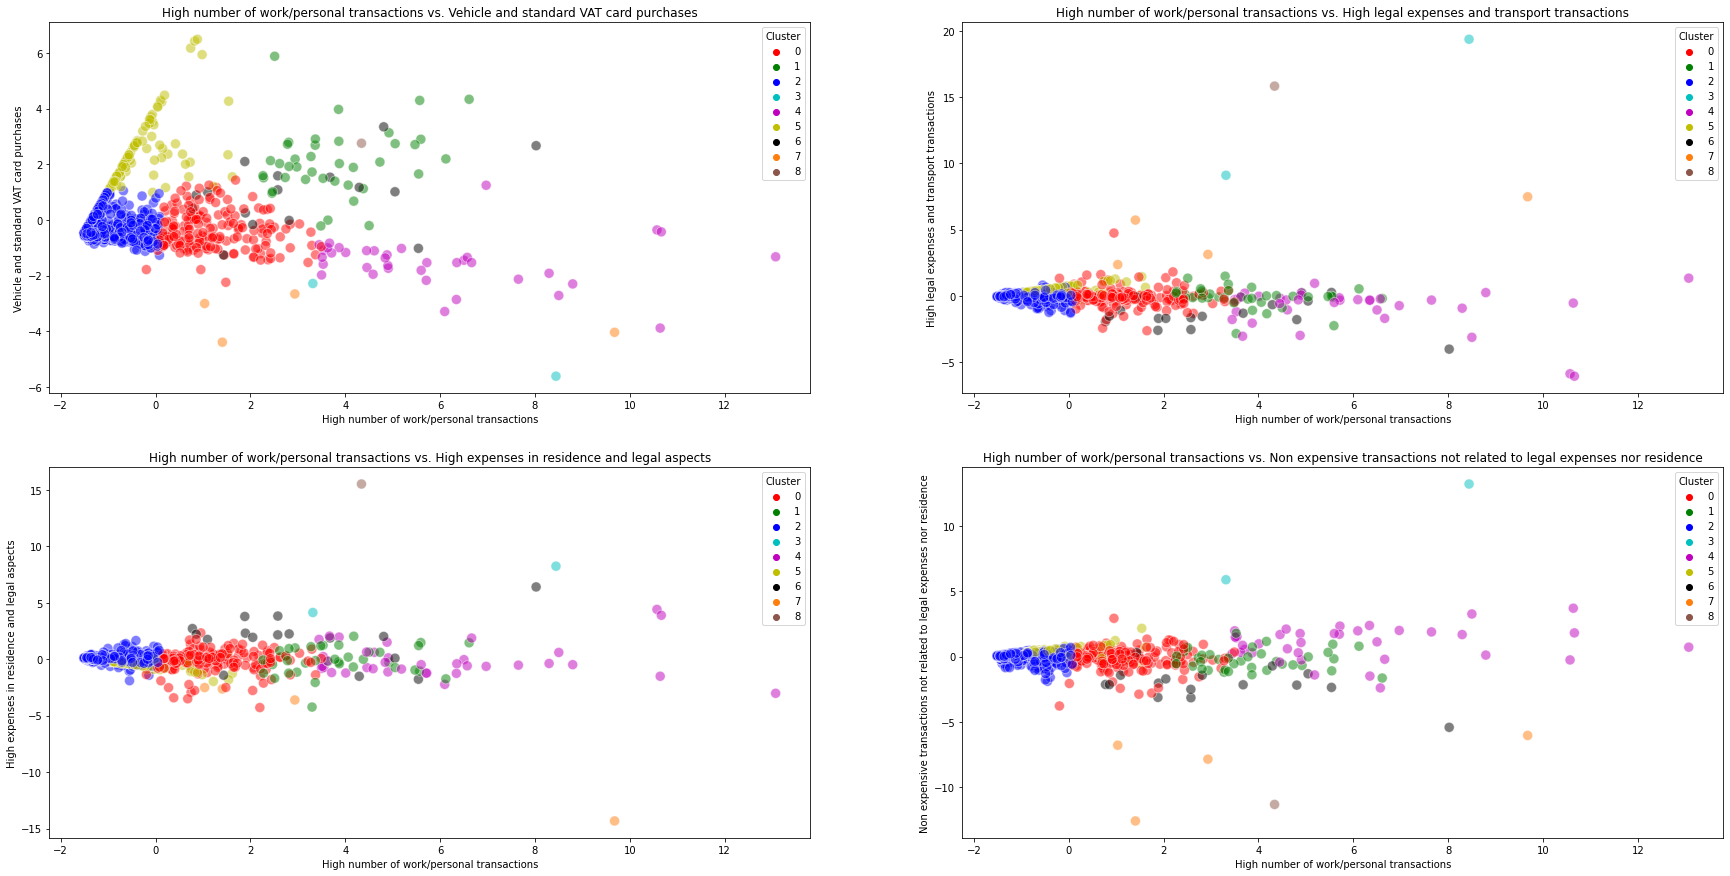

In [141]:
fig = plt.figure(figsize=(30,15))
colorPalette = ["r", "g", "b", "c", "m", "y", "k", "tab:orange","tab:brown"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x='High number of work/personal transactions', y='Vehicle and standard VAT card purchases', hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High number of work/personal transactions vs. Vehicle and standard VAT card purchases")
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(x="High number of work/personal transactions", y="High legal expenses and transport transactions", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High number of work/personal transactions vs. High legal expenses and transport transactions")
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(x="High number of work/personal transactions", y="High expenses in residence and legal aspects", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High number of work/personal transactions vs. High expenses in residence and legal aspects")
ax = fig.add_subplot(2, 2, 4)
sns.scatterplot(x='High number of work/personal transactions', y='Non expensive transactions not related to legal expenses nor residence', hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High number of work/personal transactions vs. Non expensive transactions not related to legal expenses nor residence")
plt.show()

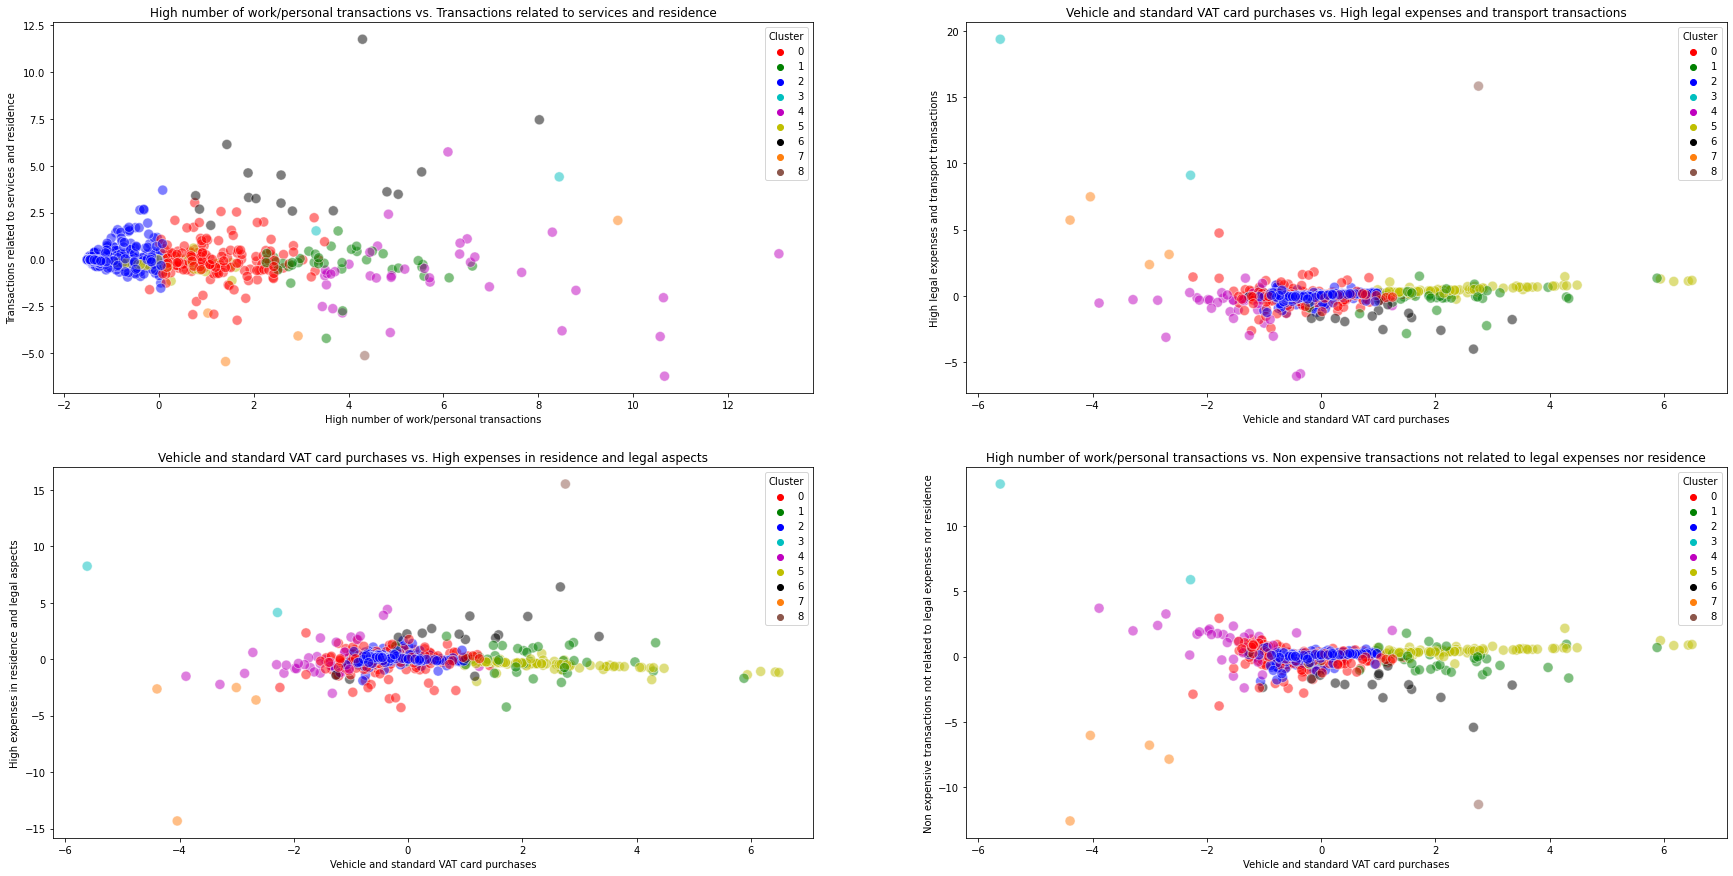

In [142]:
fig = plt.figure(figsize=(30,15))
colorPalette = ["r", "g", "b", "c", "m", "y", "k", "tab:orange","tab:brown"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="High number of work/personal transactions", y="Transactions related to services and residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High number of work/personal transactions vs. Transactions related to services and residence")
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(x="Vehicle and standard VAT card purchases", y="High legal expenses and transport transactions", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("Vehicle and standard VAT card purchases vs. High legal expenses and transport transactions")
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(x='Vehicle and standard VAT card purchases', y='High expenses in residence and legal aspects', hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("Vehicle and standard VAT card purchases vs. High expenses in residence and legal aspects")
ax = fig.add_subplot(2, 2, 4)
sns.scatterplot(x="Vehicle and standard VAT card purchases", y="Non expensive transactions not related to legal expenses nor residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High number of work/personal transactions vs. Non expensive transactions not related to legal expenses nor residence")
plt.show()

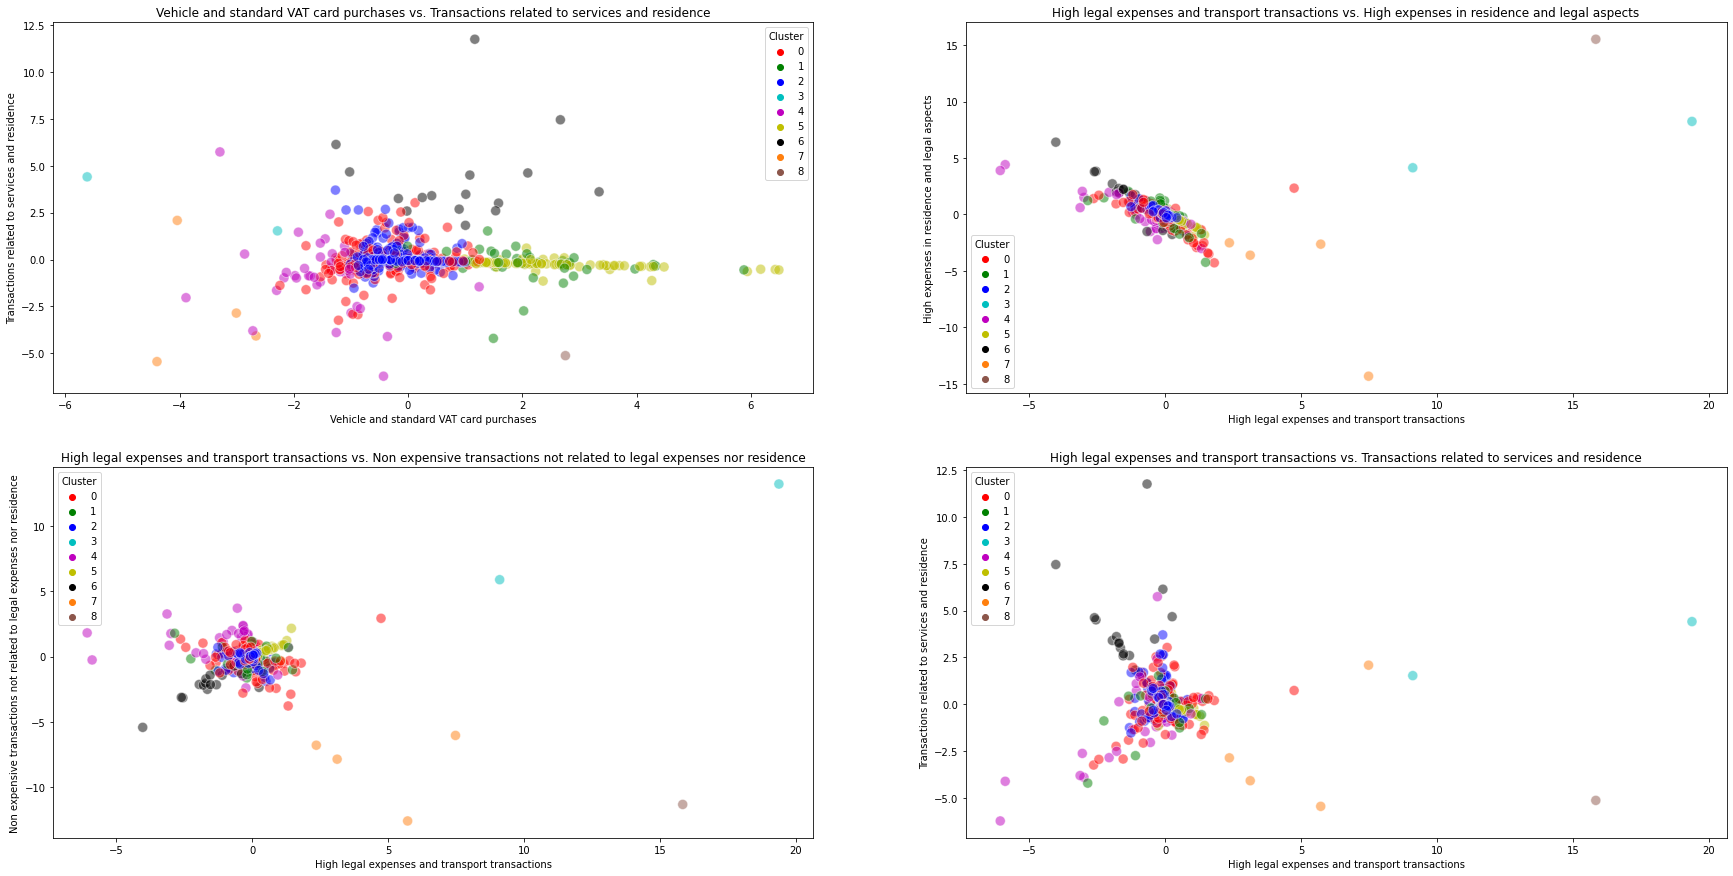

In [143]:
fig = plt.figure(figsize=(30,15))
colorPalette = ["r", "g", "b", "c", "m", "y", "k", "tab:orange","tab:brown"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="Vehicle and standard VAT card purchases", y="Transactions related to services and residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("Vehicle and standard VAT card purchases vs. Transactions related to services and residence")
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(x='High legal expenses and transport transactions', y='High expenses in residence and legal aspects', hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High legal expenses and transport transactions vs. High expenses in residence and legal aspects")
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(x="High legal expenses and transport transactions", y="Non expensive transactions not related to legal expenses nor residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High legal expenses and transport transactions vs. Non expensive transactions not related to legal expenses nor residence")
ax = fig.add_subplot(2, 2, 4)
sns.scatterplot(x="High legal expenses and transport transactions", y="Transactions related to services and residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High legal expenses and transport transactions vs. Transactions related to services and residence")
plt.show()

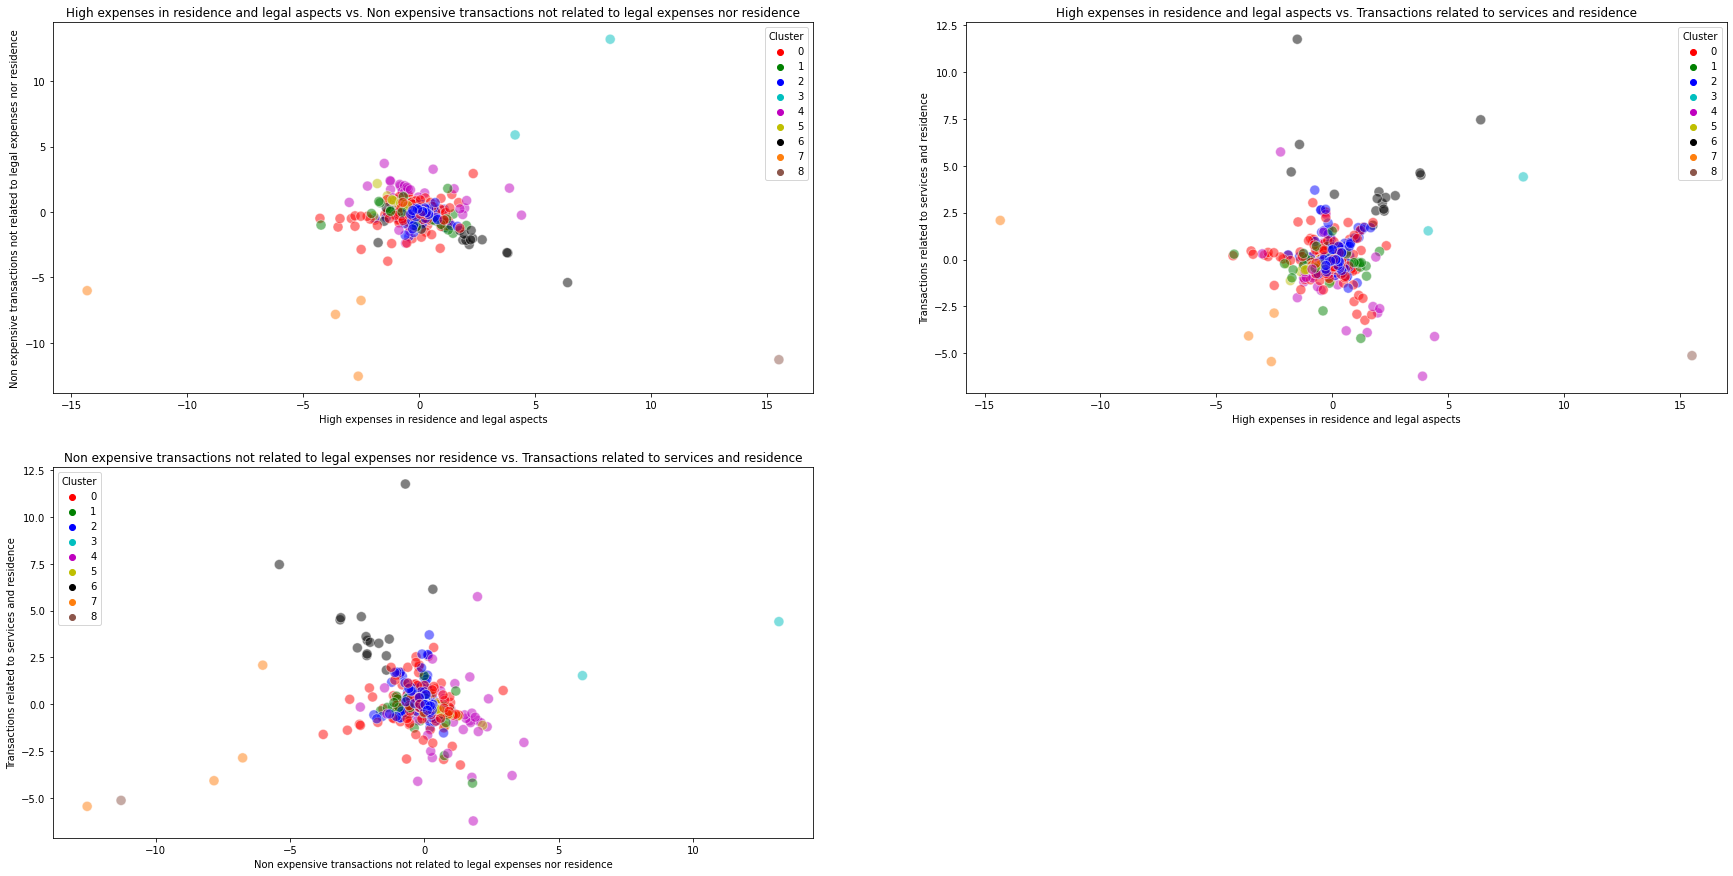

In [144]:
fig = plt.figure(figsize=(30,15))
colorPalette = ["r", "g", "b", "c", "m", "y", "k", "tab:orange","tab:brown"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="High expenses in residence and legal aspects", y="Non expensive transactions not related to legal expenses nor residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High expenses in residence and legal aspects vs. Non expensive transactions not related to legal expenses nor residence")
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(x="High expenses in residence and legal aspects", y="Transactions related to services and residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High expenses in residence and legal aspects vs. Transactions related to services and residence")
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(x="Non expensive transactions not related to legal expenses nor residence", y="Transactions related to services and residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("Non expensive transactions not related to legal expenses nor residence vs. Transactions related to services and residence")
plt.show()

#### Profiling clients with k-means using k=9

By observing the density plots and the scatter plots we will try to figure out the profile of clients, although some of the plots are not that clear.

<b>Cluster 0:</b> Clients with less than average of High number of work/personal transactions, high Vehicle and standard VAT card purchases, low High legal expenses and transport transactions, more than average in High expenses in residence and legal aspects, average in Non expensive transactions not related to legal expenses nor residence and average in Transactions related to services and residence.

<b>Cluster 1:</b> Clients with average High number of work/personal transactions, high Vehicle and standard VAT card purchases, low High legal expenses and transport transactions, more than average in High expenses in residence and legal aspects, average in Non expensive transactions not related to legal expenses nor residence and average in Transactions related to services and residence.

<b>Cluster 2:</b> Clients with the lowest High number of work/personal transactions, more than average of Vehicle and standard VAT card purchases, low High legal expenses and transport transactions, more than average in High expenses in residence and legal aspects, average in Non expensive transactions not related to legal expenses nor residence and average in Transactions related to services and residence.

<b>Cluster 3:</b> Clients with high High number of work/personal transactions, the lowest Vehicle and standard VAT card purchases, the highest High legal expenses and transport transactions, the highest in High expenses in residence and legal aspects, the highest in Non expensive transactions not related to legal expenses nor residence and the highest in Transactions related to services and residence.

<b>Cluster 4:</b> Clients with more than average of High number of work/personal transactions, less that average of Vehicle and standard VAT card purchases, low High legal expenses and transport transactions, more than average in High expenses in residence and legal aspects, average in Non expensive transactions not related to legal expenses nor residence and average in Transactions related to services and residence.

<b>Cluster 5:</b> Clients with low High number of work/personal transactions, the highest Vehicle and standard VAT card purchases, low High legal expenses and transport transactions, more than average in High expenses in residence and legal aspects, average in Non expensive transactions not related to legal expenses nor residence and average in Transactions related to services and residence.

<b>Cluster 6:</b> Clients with average High number of work/personal transactions, more than average Vehicle and standard VAT card purchases, the lowest High legal expenses and transport transactions, high in High expenses in residence and legal aspects, less than average in Non expensive transactions not related to legal expenses nor residence and high in Transactions related to services and residence.

<b>Cluster 7:</b> Clients with less average of High number of work/personal transactions, low Vehicle and standard VAT card purchases, less than average in High legal expenses and transport transactions, the highest in High expenses in residence and legal aspects, the highest in Non expensive transactions not related to legal expenses nor residence and the lowest on Transactions related to services and residence.

<b>Cluster 8:</b> just one data point. Not much to say.

### K-means with k = 2

In [319]:
kmeans2014_k2 = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans2014_k2.fit(data2014_kmeans)

KMeans(n_clusters=2, random_state=0)

In [321]:
counter = Counter(kmeans2014_k2.labels_)
counter

Counter({1: 797, 0: 196})

In [322]:
data2014_kmeans['Cluster'] = kmeans2014_k2.labels_
data2014_kmeans

High number of work/personal transactions  \
CARD NUMBER                                                   
************0007                                  -1.102613   
************0015                                  -1.510223   
************0040                                  -1.279980   
************0047                                   3.035147   
************0057                                  -1.244730   
...                                                     ...   
************9957                                   1.126939   
************9963                                  -1.360561   
************9968                                  -1.224845   
************9971                                   0.046710   
************9989                                   3.667547   

                  Vehicle and standard VAT card purchases  \
CARD NUMBER                                                 
************0007                                -0.609923   
************0015                                -0.474573   
************0040                                 0.171561   
************0047                                -0.145967   
************0057                                -0.104075   
...                                                   ...   
************9957                                 1.249133   
************9963                                -0.450382   
************9968                                 0.199069   
************9971                                -0.869348   
************9989                                -0.836873   

                  High legal expenses and transport transactions  \
CARD NUMBER                                                        
************0007                                       -0.078921   
************0015                                       -0.049181   
************0040                                        0.070341   
************0047                                       -0.586113   
************0057                                       -0.108621   
...                                                          ...   
************9957                                       -0.095804   
************9963                                       -0.067909   
************9968                                        0.106738   
************9971                                        0.040100   
************9989                                       -3.051555   

                  High expenses in residence and legal aspects  \
CARD NUMBER                                                      
************0007                                     -0.002634   
************0015                                      0.109719   
************0040                                     -0.017045   
************0047                                      0.532373   
************0057                                      0.089445   
...                                                        ...   
************9957                                      0.050369   
************9963                                      0.153903   
************9968                                     -0.070366   
************9971                                     -0.278259   
************9989                                      2.046489   

                  Non expensive transactions not related to legal expenses nor residence  \
CARD NUMBER                                                                                
************0007                                           0.090542                        
************0015                                           0.067047                        
************0040                                           0.157104                        
************0047                                          -0.254677                        
************0057                                           0.235960                        
...             

Save the dataframe with k-means where k = 2.

In [328]:
df2014_kmeans2_pkl_filename = '/Users/andresaristi/Documents/BirminghamCardTransactions/pickle_files/df2014_kmeans2.pkl'
df2014_kmeans2_pkl = open(df2014_kmeans2_pkl_filename, 'wb')
pickle.dump(data2014_kmeans, df2014_kmeans2_pkl)
df2014_kmeans2_pkl.close()

Densitity plots to help understand the clusters.

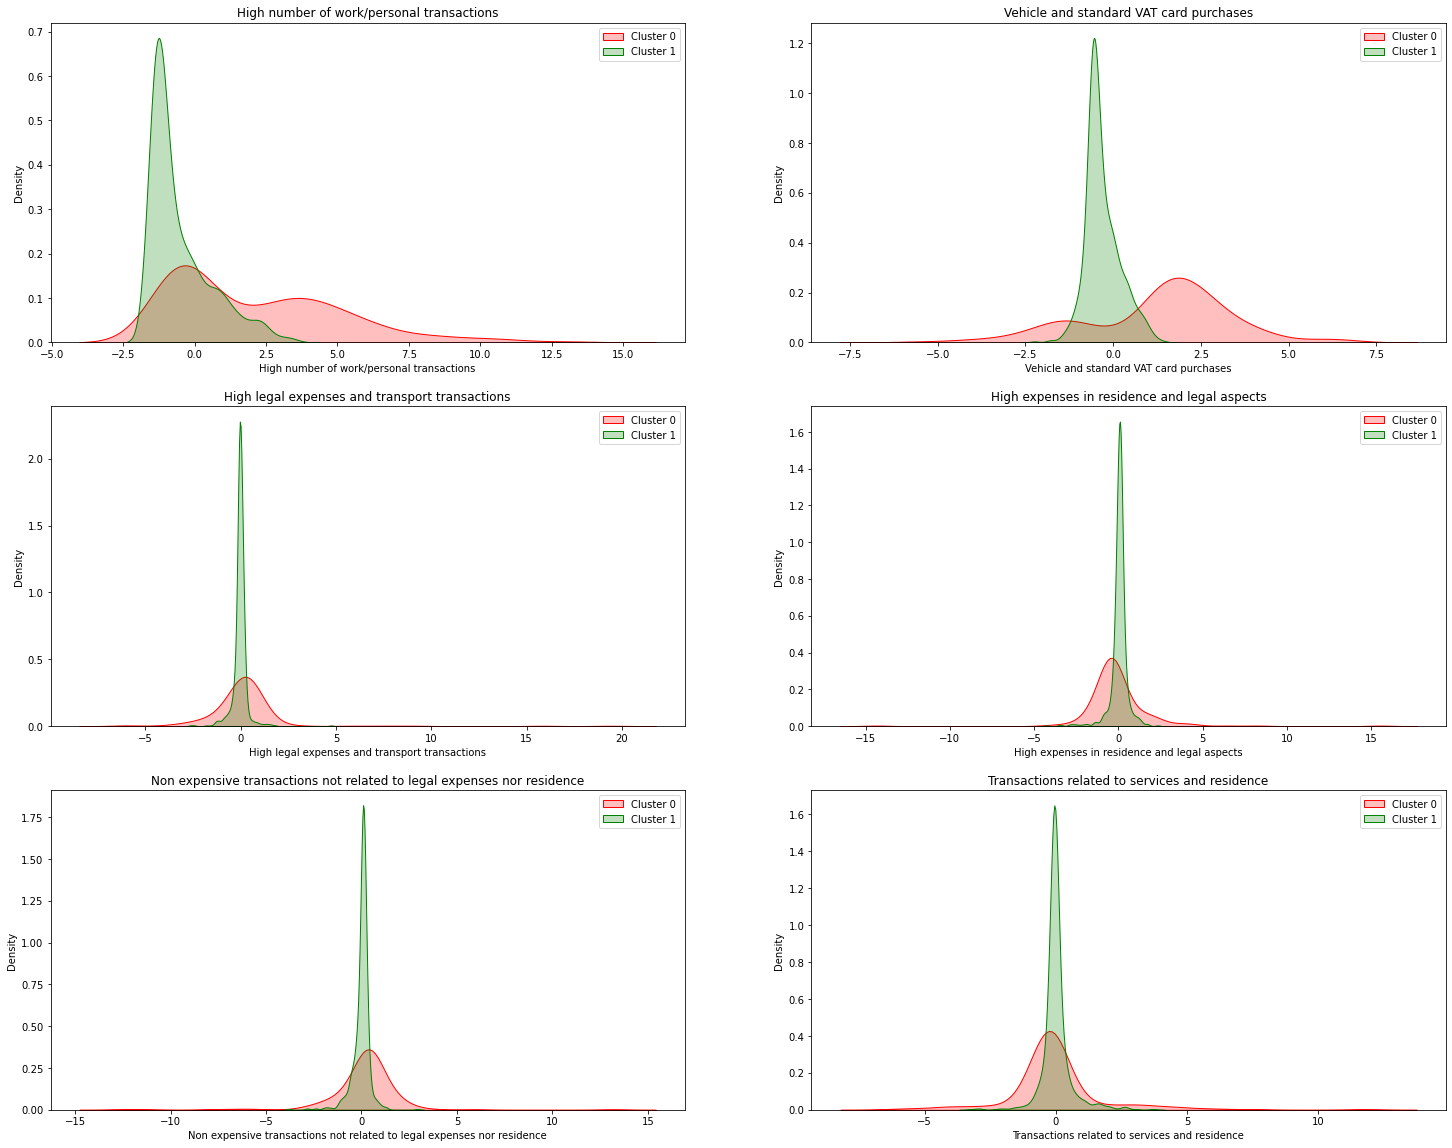

In [323]:
var_num = data2014_kmeans.columns[0:6]
fig = plt.figure(figsize=(25,20))
i=1
for var in var_num:
    ax = fig.add_subplot(math.ceil(len(var_num)/2), 2, i)
    sns.kdeplot(data2014_kmeans.loc[data2014_kmeans.Cluster==0][var], shade=True, color='r', ax=ax);
    sns.kdeplot(data2014_kmeans.loc[data2014_kmeans.Cluster==1][var], shade=True, color='g', ax=ax);
    plt.title(var)
    plt.legend(['Cluster 0', 'Cluster 1' ])
    i+=1

Scatter plots to help understand the clusters.

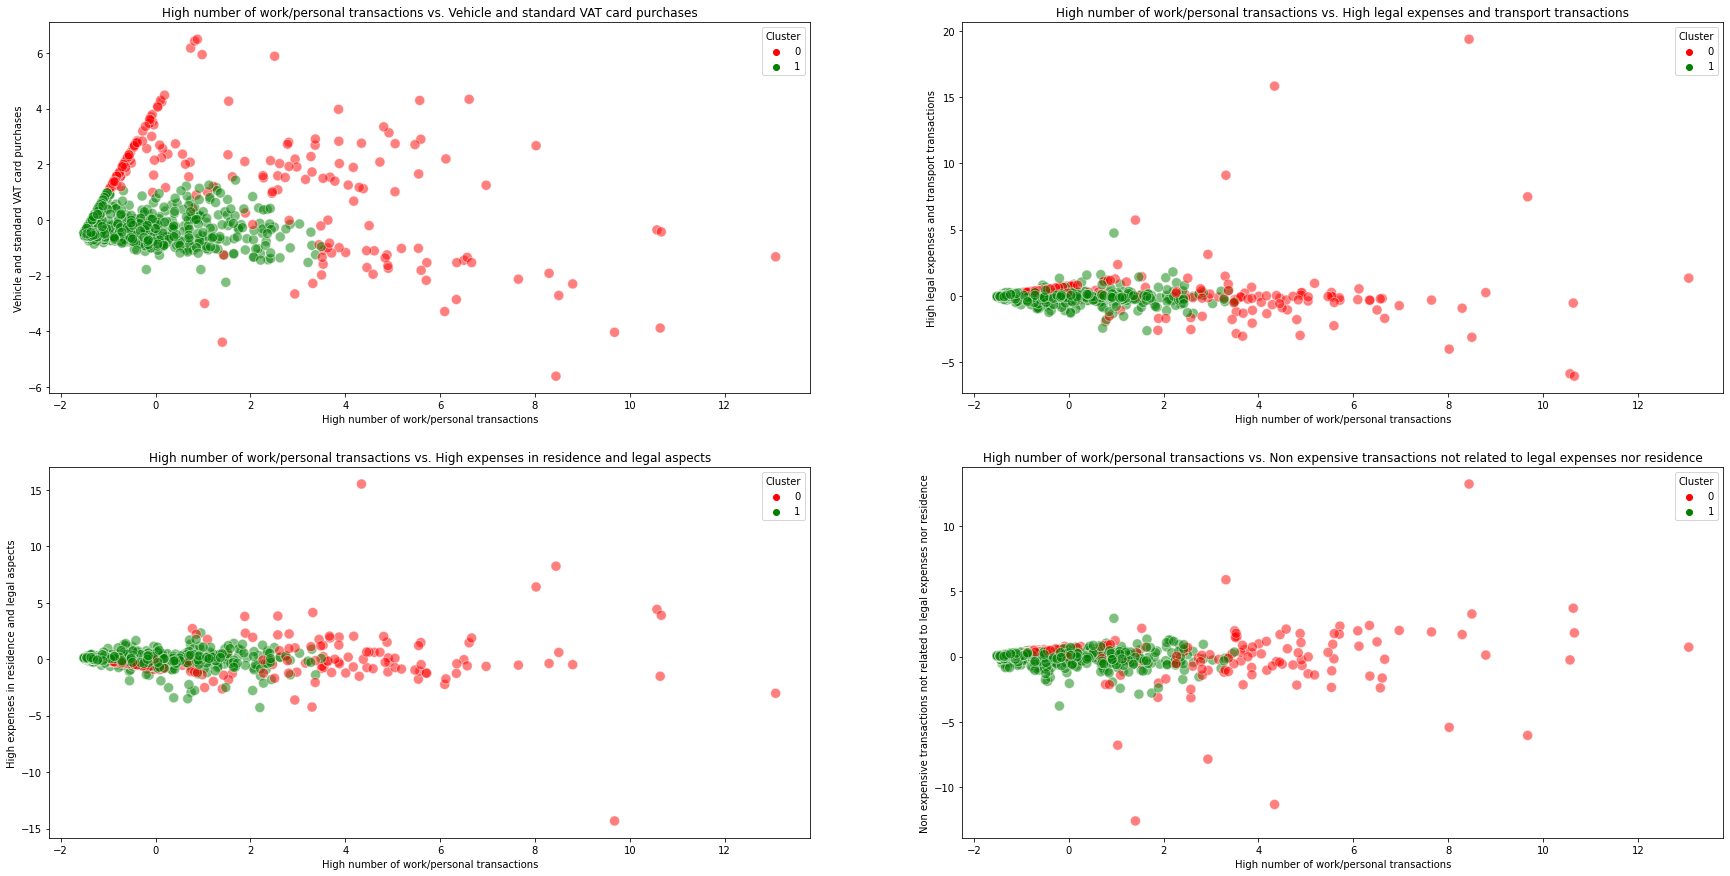

In [324]:
fig = plt.figure(figsize=(30,15))
colorPalette = ["r", "g"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x='High number of work/personal transactions', y='Vehicle and standard VAT card purchases', hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High number of work/personal transactions vs. Vehicle and standard VAT card purchases")
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(x="High number of work/personal transactions", y="High legal expenses and transport transactions", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High number of work/personal transactions vs. High legal expenses and transport transactions")
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(x="High number of work/personal transactions", y="High expenses in residence and legal aspects", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High number of work/personal transactions vs. High expenses in residence and legal aspects")
ax = fig.add_subplot(2, 2, 4)
sns.scatterplot(x='High number of work/personal transactions', y='Non expensive transactions not related to legal expenses nor residence', hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High number of work/personal transactions vs. Non expensive transactions not related to legal expenses nor residence")
plt.show()

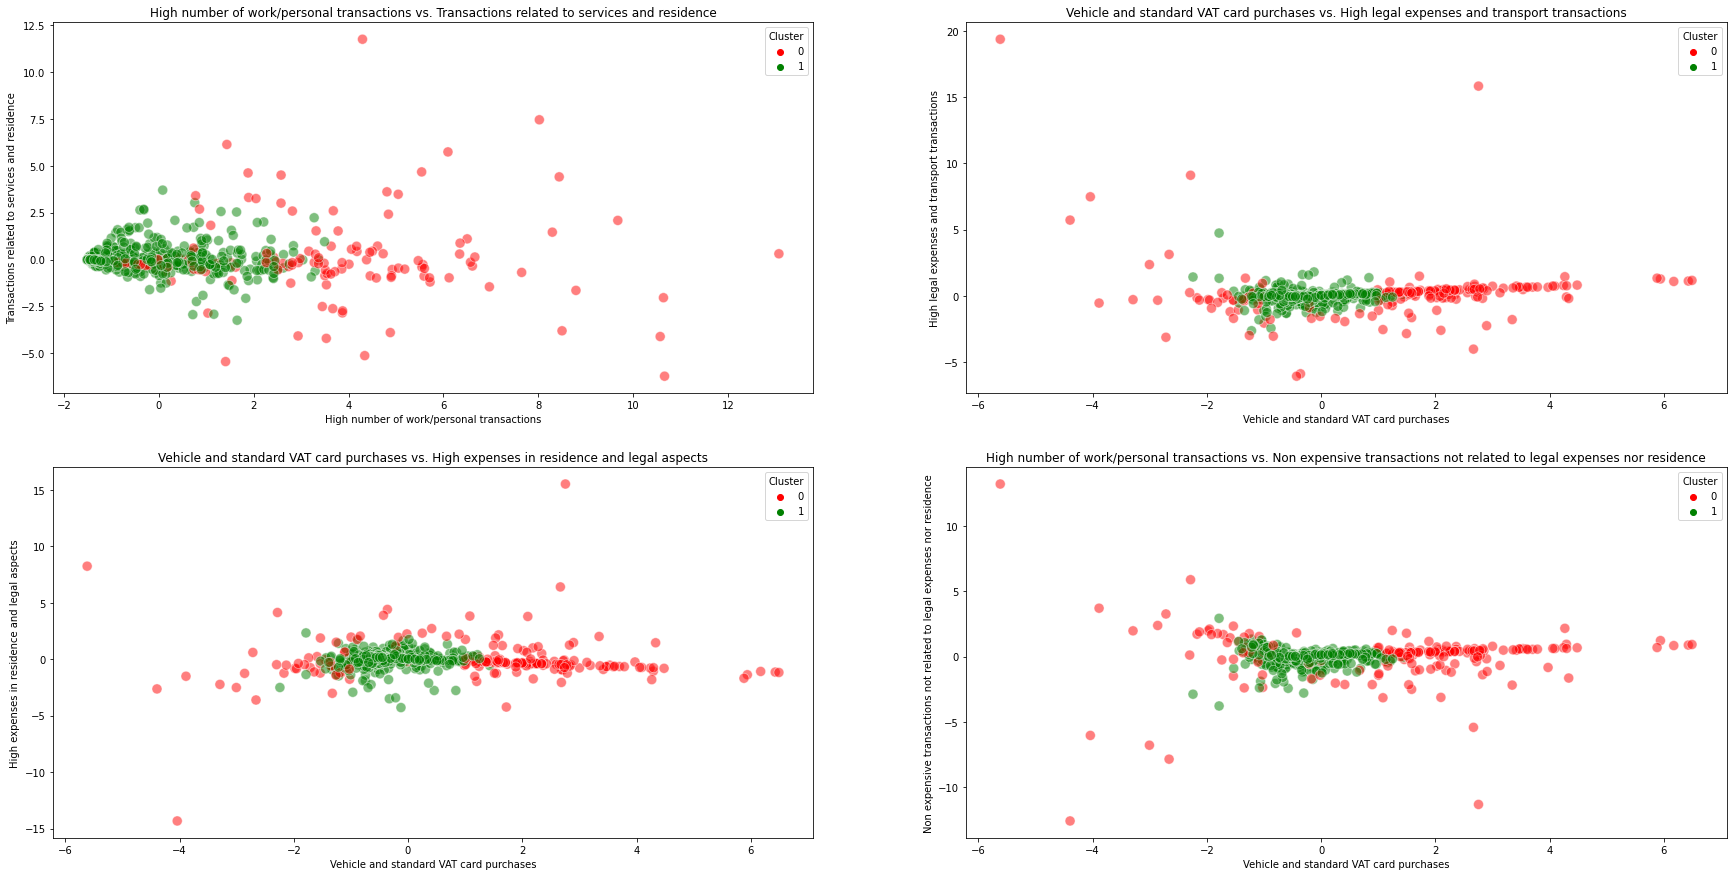

In [325]:
fig = plt.figure(figsize=(30,15))
colorPalette = ["r", "g",]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="High number of work/personal transactions", y="Transactions related to services and residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High number of work/personal transactions vs. Transactions related to services and residence")
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(x="Vehicle and standard VAT card purchases", y="High legal expenses and transport transactions", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("Vehicle and standard VAT card purchases vs. High legal expenses and transport transactions")
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(x='Vehicle and standard VAT card purchases', y='High expenses in residence and legal aspects', hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("Vehicle and standard VAT card purchases vs. High expenses in residence and legal aspects")
ax = fig.add_subplot(2, 2, 4)
sns.scatterplot(x="Vehicle and standard VAT card purchases", y="Non expensive transactions not related to legal expenses nor residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High number of work/personal transactions vs. Non expensive transactions not related to legal expenses nor residence")
plt.show()

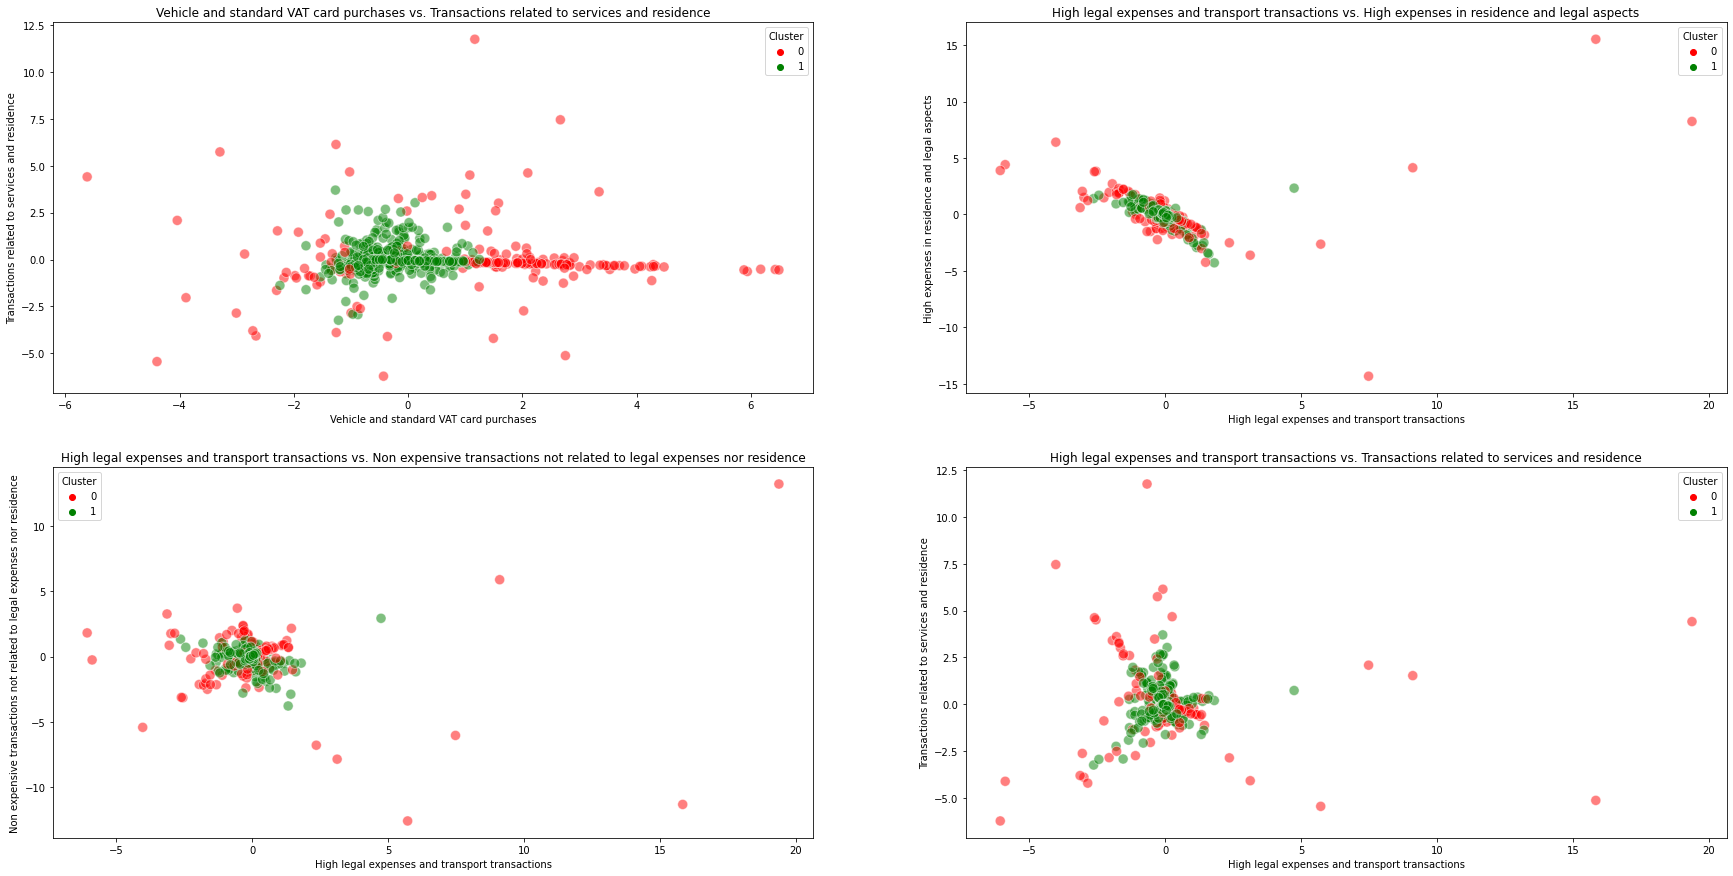

In [326]:
fig = plt.figure(figsize=(30,15))
colorPalette = ["r", "g",]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="Vehicle and standard VAT card purchases", y="Transactions related to services and residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("Vehicle and standard VAT card purchases vs. Transactions related to services and residence")
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(x='High legal expenses and transport transactions', y='High expenses in residence and legal aspects', hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High legal expenses and transport transactions vs. High expenses in residence and legal aspects")
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(x="High legal expenses and transport transactions", y="Non expensive transactions not related to legal expenses nor residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High legal expenses and transport transactions vs. Non expensive transactions not related to legal expenses nor residence")
ax = fig.add_subplot(2, 2, 4)
sns.scatterplot(x="High legal expenses and transport transactions", y="Transactions related to services and residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High legal expenses and transport transactions vs. Transactions related to services and residence")
plt.show()

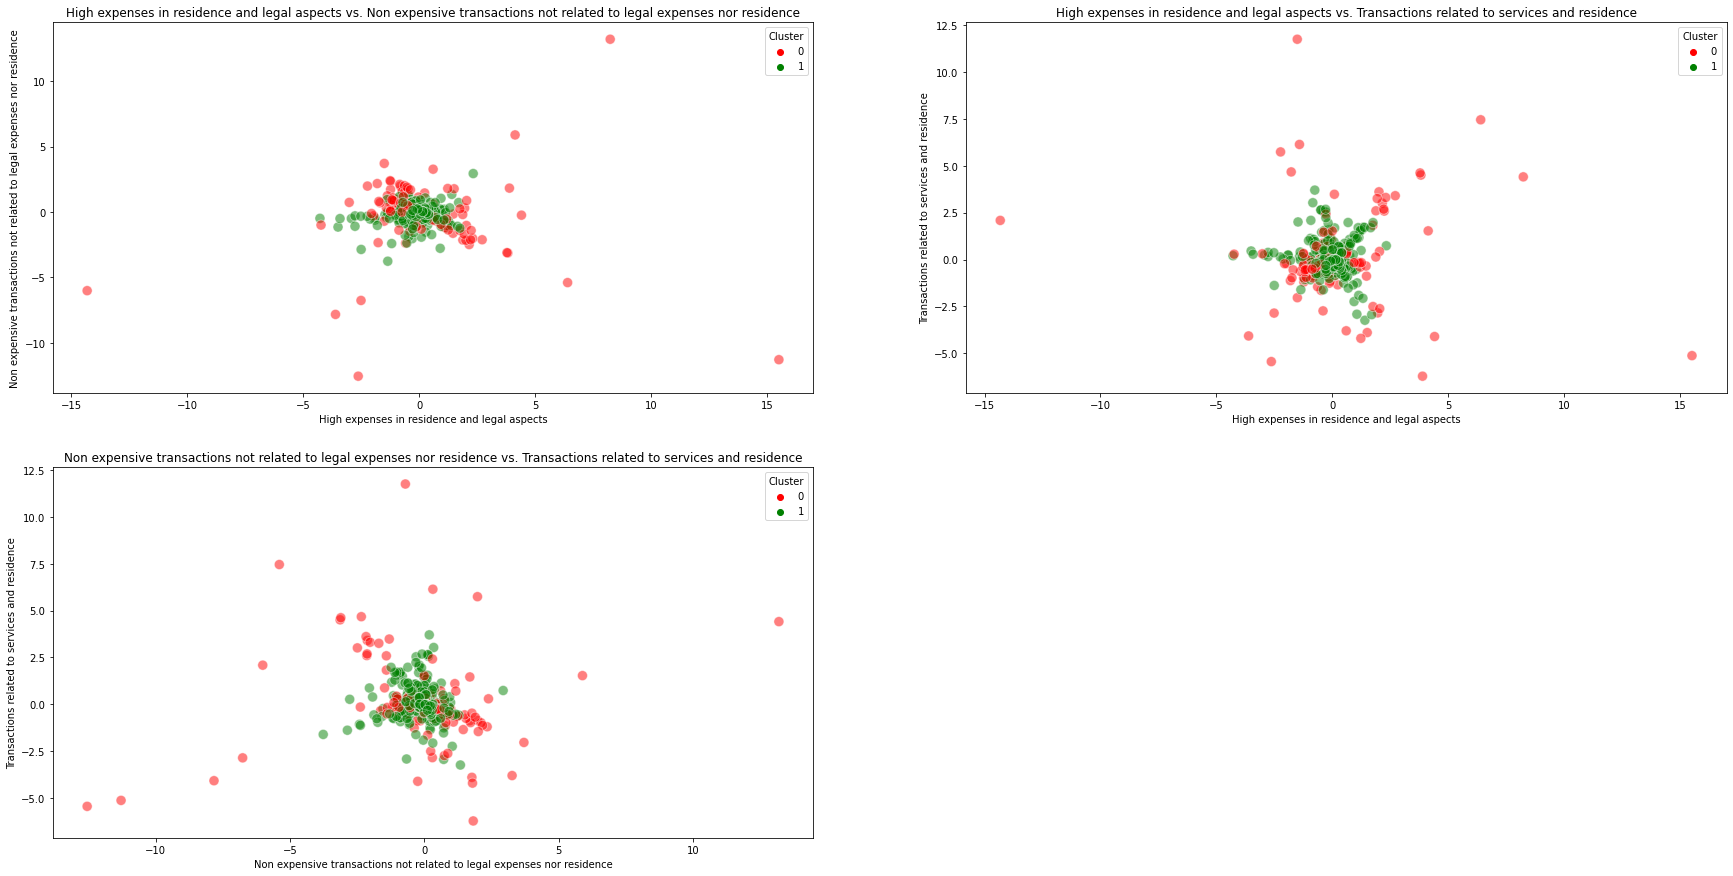

In [327]:
fig = plt.figure(figsize=(30,15))
colorPalette = ["r", "g"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="High expenses in residence and legal aspects", y="Non expensive transactions not related to legal expenses nor residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High expenses in residence and legal aspects vs. Non expensive transactions not related to legal expenses nor residence")
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(x="High expenses in residence and legal aspects", y="Transactions related to services and residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("High expenses in residence and legal aspects vs. Transactions related to services and residence")
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(x="Non expensive transactions not related to legal expenses nor residence", y="Transactions related to services and residence", hue="Cluster", data=data2014_kmeans, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("Non expensive transactions not related to legal expenses nor residence vs. Transactions related to services and residence")
plt.show()

#### Profiling clients with k-means using k=2

Even though k=2 seems like a not so good idea form the business point, the data is teling us something. Therefore, by observing the density plots and the scatter plots we will try to figure out the profile of clients.

<b>Cluster 0:</b> Scattered group. Clients with really to really high of High number of work/personal transactions (data spread up), very low to very high Vehicle and standard VAT card purchases, mainly the lowest High legal expenses and transport transactions (with a few high values), average in High expenses in residence and legal aspects, average in Non expensive transactions not related to legal expenses nor residence (although a few quite highs and quite lows) and a spread up data from really low to quite high in Transactions related to services and residence.

<b>Cluster 1:</b> Dense group. Clients with average High number of work/personal transactions, the lowest Vehicle and standard VAT card purchases, the lowest High legal expenses and transport transactions, average in High expenses in residence and legal aspects, average in Non expensive transactions not related to legal expenses nor residence and less than average in Transactions related to services and residence.


### Hierarchichal clustering

We will summarize the different linkages by means of Scipy.

In [261]:
data2014_hc = data2014_kmeans.copy()
X = data2014_hc.iloc[:,[0,1,2,3,4,5]].values

#### Dendogram

We borrow a function from https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/ that allows the returned data from the dendogram function in orther to improve them.

In [262]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')

#### Ward linkage

We plot the dendogram from Scipy using ward linkage.

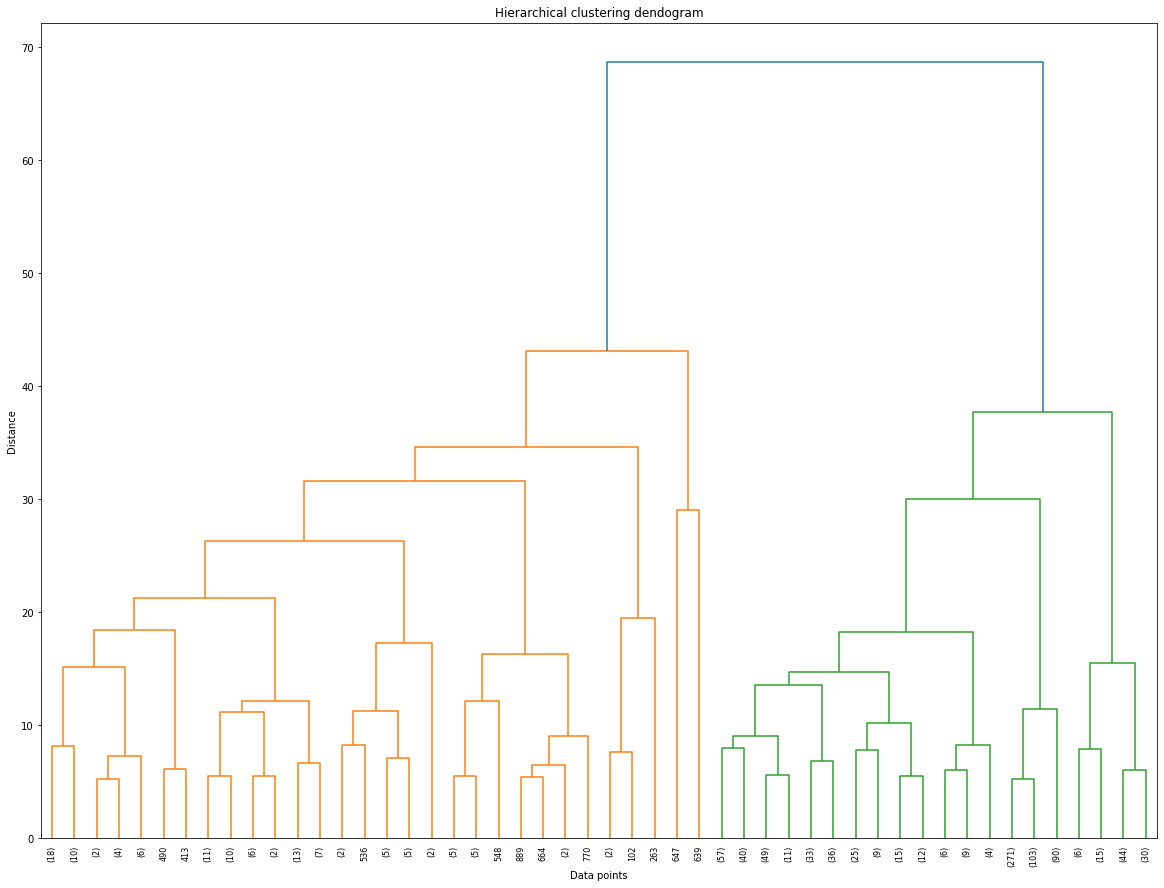

In [263]:
fusions = linkage(X, 'ward')
plt.figure(figsize=(20, 15))  
plt.title('Hierarchical clustering dendogram')
plt.xlabel('Data points')
plt.ylabel('Distance')
dendrogram(fusions,  
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
            p=50,
          truncate_mode = 'lastp')
plt.show()

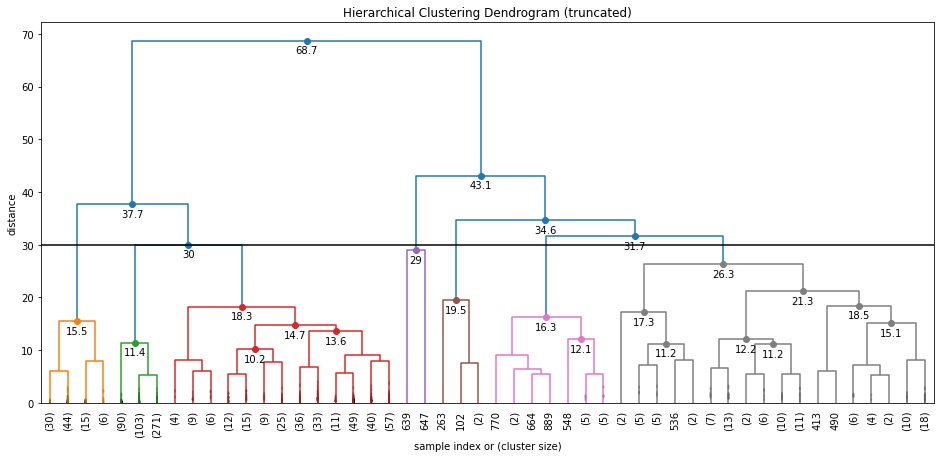

In [264]:
plt.figure(figsize=(16, 7))  
fancy_dendrogram(
    fusions,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=10,
    max_d=30,  # plot a horizontal cut-off line
)

It seems that, using ward, k = 7 seems good

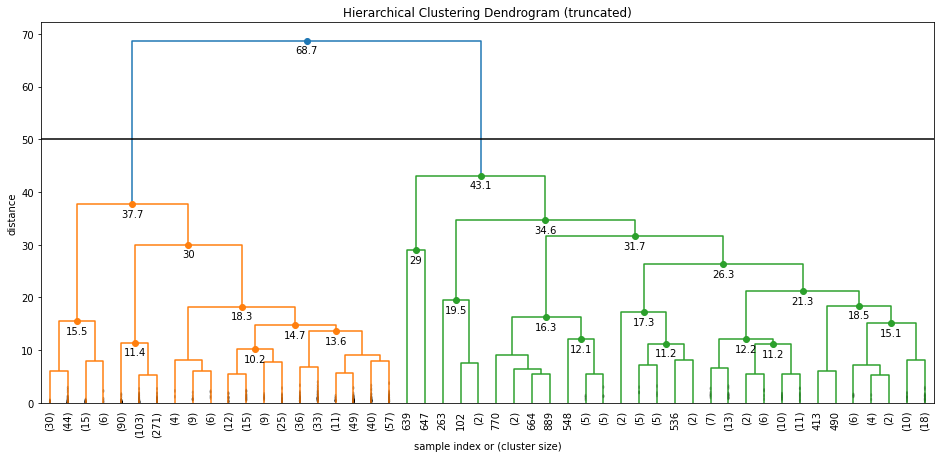

In [265]:
plt.figure(figsize=(16, 7))  
fancy_dendrogram(
    fusions,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=10,
    max_d=50,  # plot a horizontal cut-off line
)

#### Complete linkage

We plot the dendogram from Scipy using complete linkage

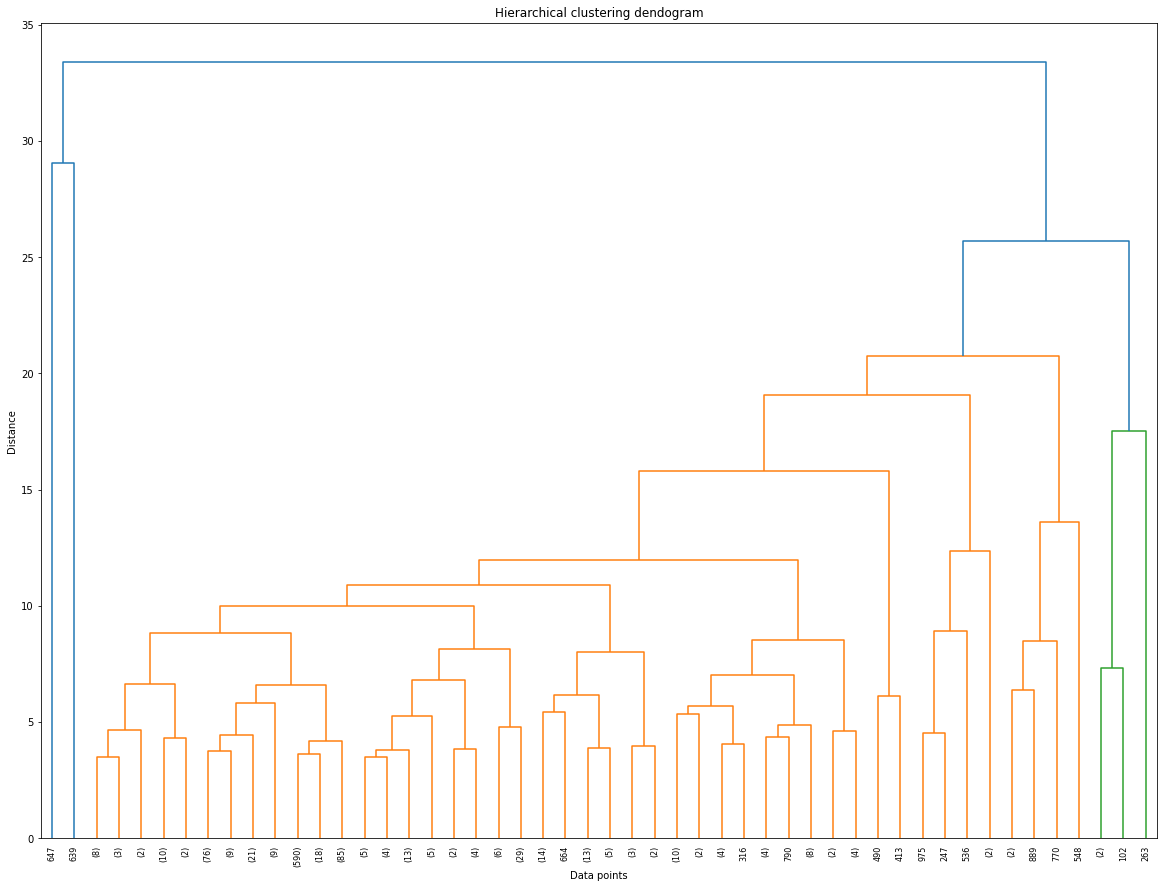

In [215]:
fusions = linkage(X, 'complete')
plt.figure(figsize=(20, 15))  
plt.title('Hierarchical clustering dendogram')
plt.xlabel('Data points')
plt.ylabel('Distance')
dendrogram(fusions,  
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
            p=50,
          truncate_mode = 'lastp')
plt.show()

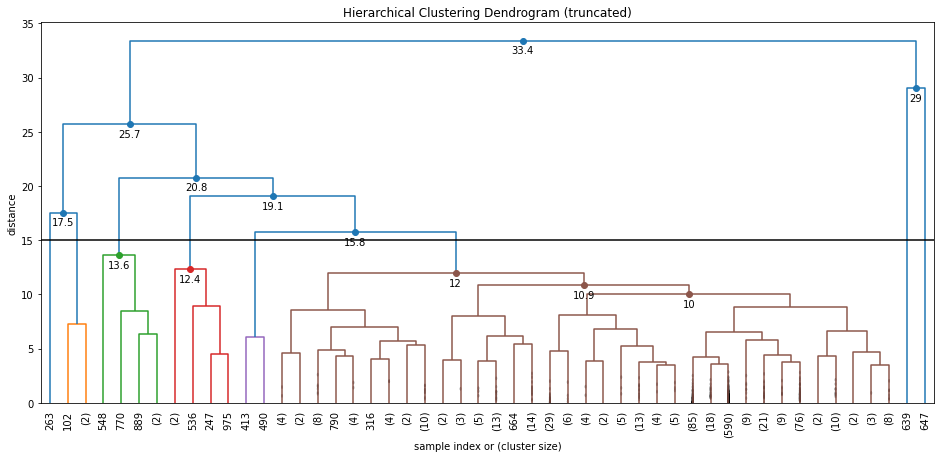

In [219]:
plt.figure(figsize=(16, 7))  
fancy_dendrogram(
    fusions,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=10,
    max_d=15,  # plot a horizontal cut-off line
)

It seems that, using complete, the ideal k = 8, but does not look that good.

#### Average linkage

We plot the dendogram from Scipy using average linkage.

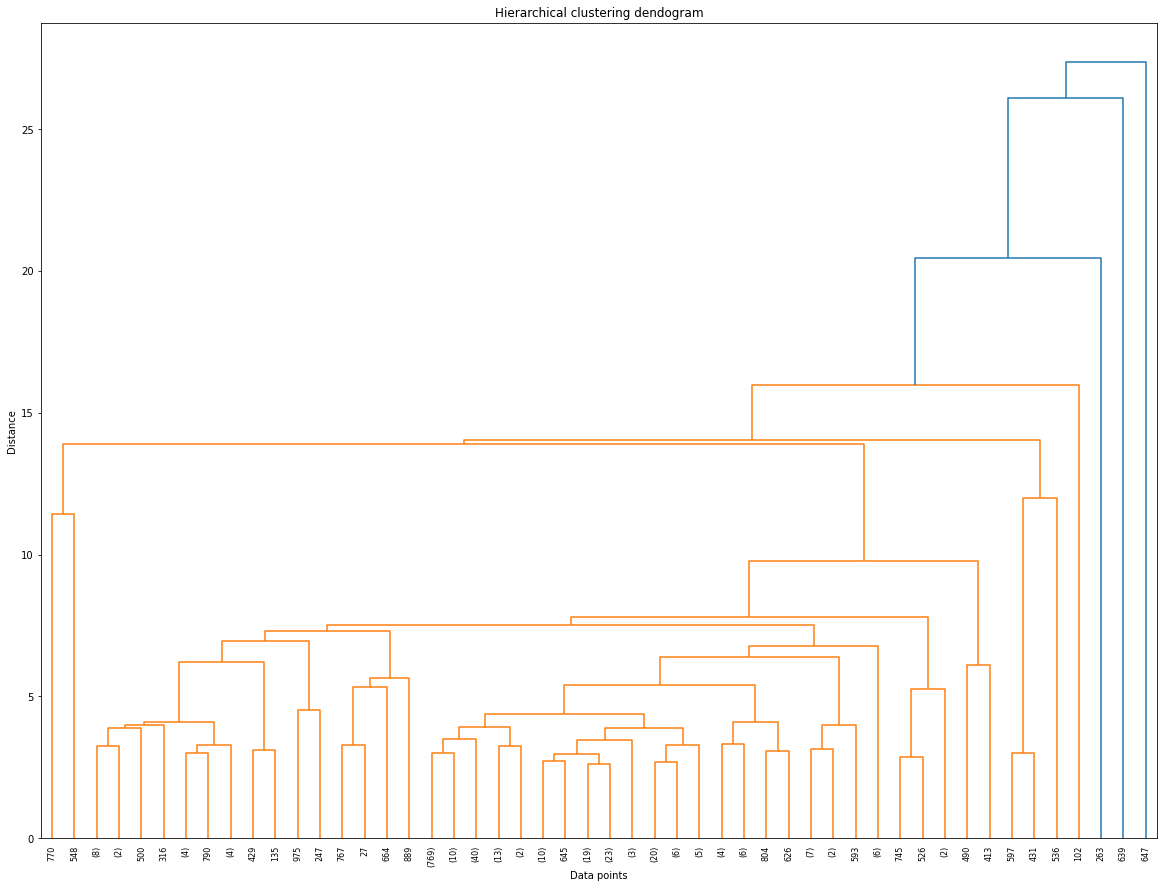

In [220]:
fusions = linkage(X, 'average')
plt.figure(figsize=(20, 15))  
plt.title('Hierarchical clustering dendogram')
plt.xlabel('Data points')
plt.ylabel('Distance')
dendrogram(fusions,  
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
            p=50,
          truncate_mode = 'lastp')
plt.show()

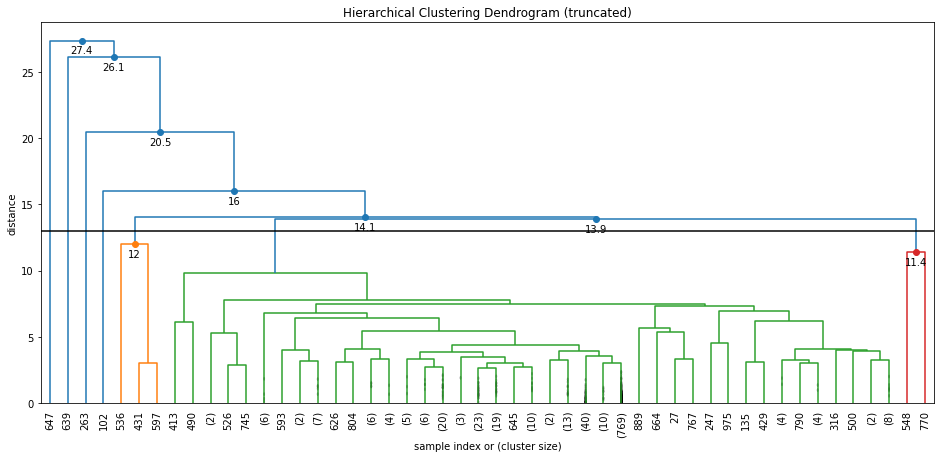

In [223]:
plt.figure(figsize=(16, 7))  
fancy_dendrogram(
    fusions,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=10,
    max_d=13,  # plot a horizontal cut-off line
)

It seems that, using average, the ideal k = 7, but does not look that good.

#### Single linkage

We plot the dendogram from Scipy using single linkage.

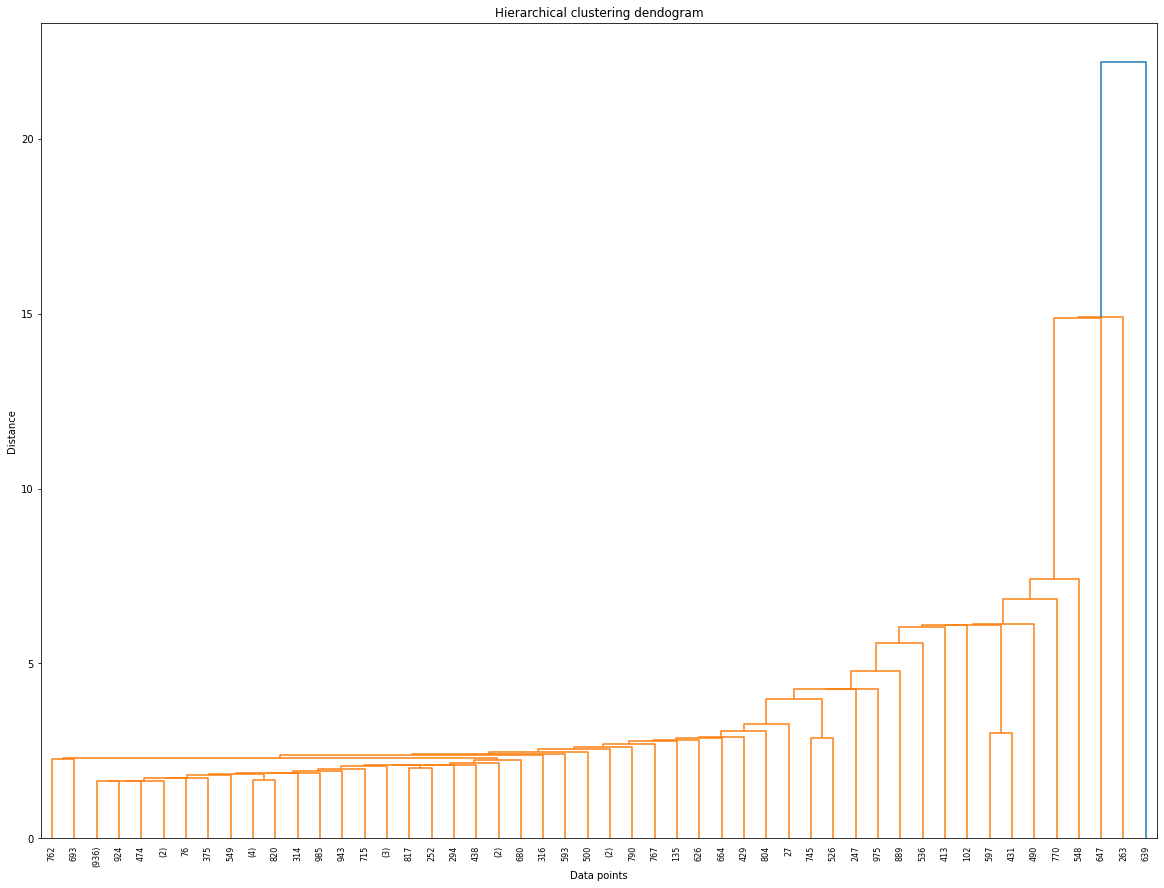

In [224]:
fusions = linkage(X, 'single')
plt.figure(figsize=(20, 15))  
plt.title('Hierarchical clustering dendogram')
plt.xlabel('Data points')
plt.ylabel('Distance')
dendrogram(fusions,  
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
            p=50,
          truncate_mode = 'lastp')
plt.show()

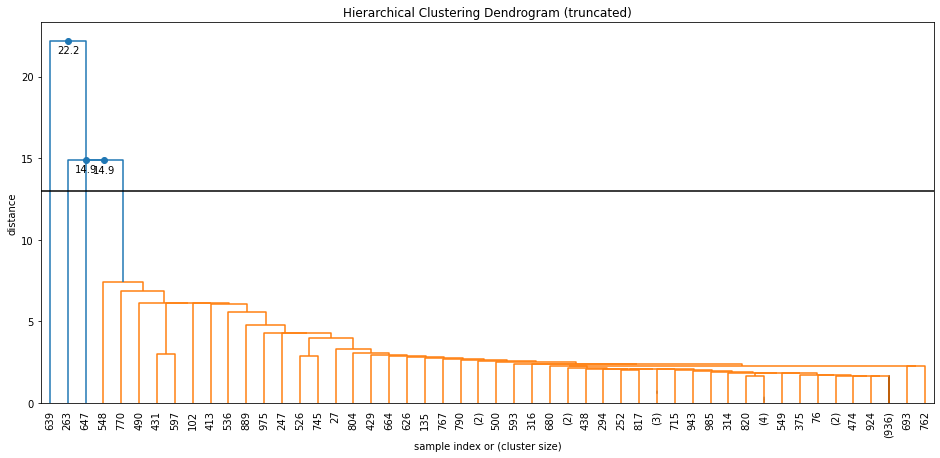

In [225]:
plt.figure(figsize=(16, 7))  
fancy_dendrogram(
    fusions,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=10,
    max_d=13,  # plot a horizontal cut-off line
)

The results do not seem that good even with k=4

#### Clustering using ward linkage with 2 clusters

Since the resulting tree seems balanced we chose the cutting point so we get 2 clusters.

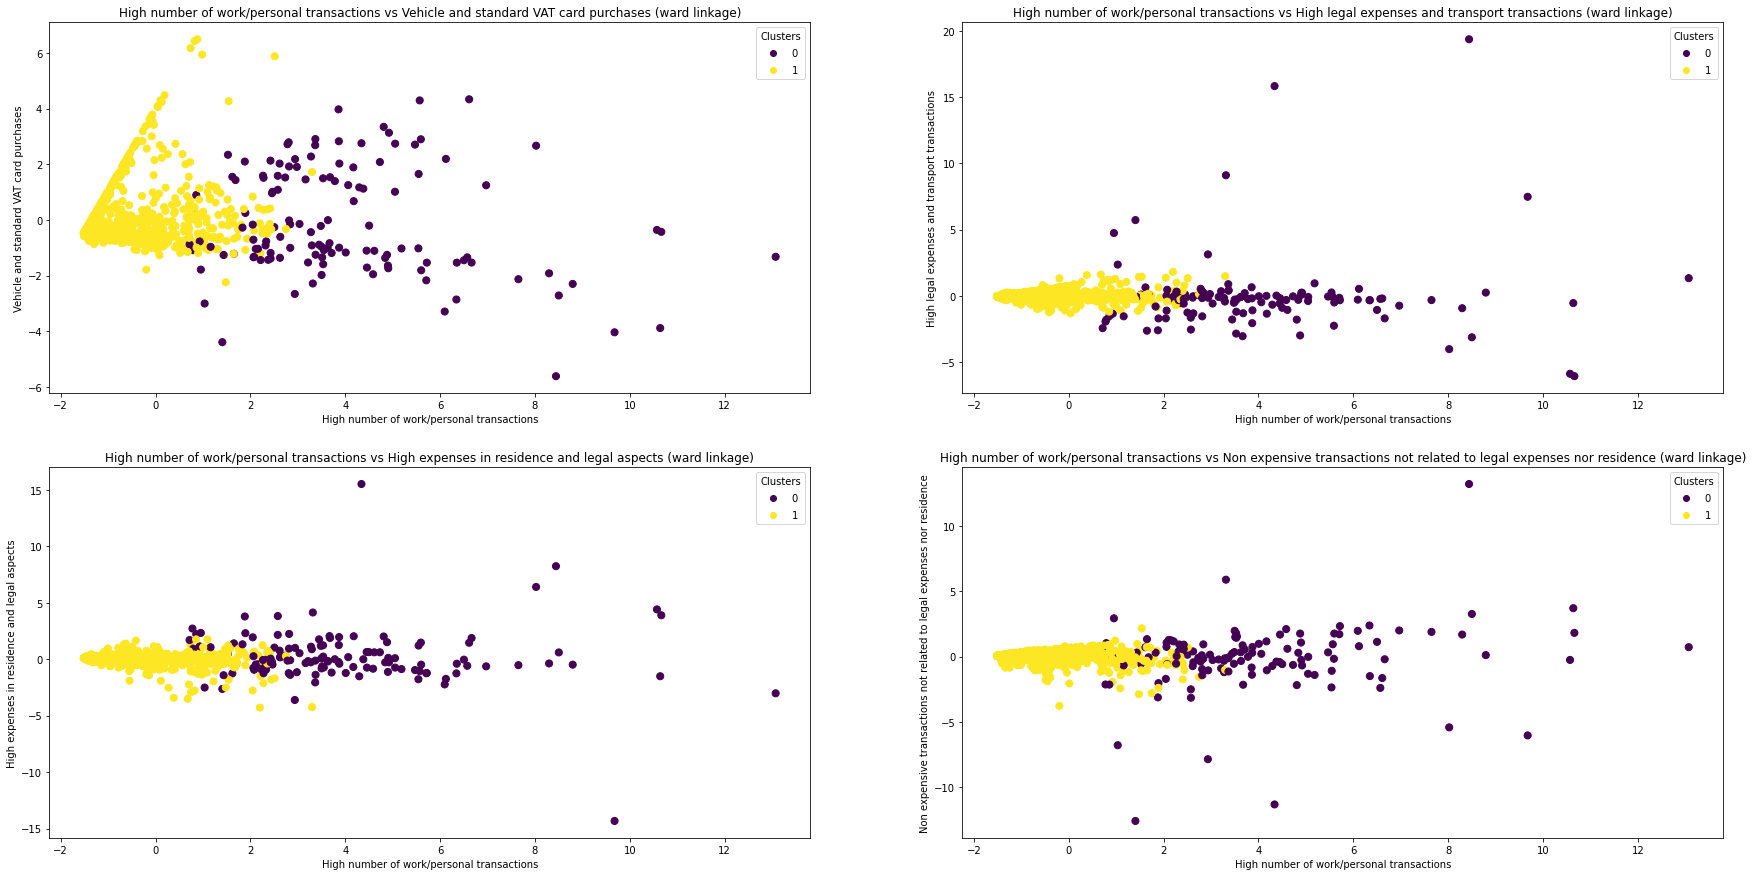

In [267]:
fig, axes = plt.subplots(2,2,figsize=(30,15))

link = 'ward'
clustering = AgglomerativeClustering(linkage=link, n_clusters=2)
clustering.fit(X)
points=axes[0][0].scatter(X[:, 0], X[:, 1], c=clustering.labels_, s=50, cmap='viridis')
axes[0][0].set_title("High number of work/personal transactions vs Vehicle and standard VAT card purchases (%s linkage)" % link)
axes[0][0].set_xlabel('High number of work/personal transactions')
axes[0][0].set_ylabel('Vehicle and standard VAT card purchases')
axes[0][0].legend(*points.legend_elements(), title="Clusters")

points=axes[0][1].scatter(X[:, 0], X[:, 2], c=clustering.labels_, s=50, cmap='viridis')
axes[0][1].set_title("High number of work/personal transactions vs High legal expenses and transport transactions (%s linkage)" % link)
axes[0][1].set_xlabel('High number of work/personal transactions')
axes[0][1].set_ylabel('High legal expenses and transport transactions')
axes[0][1].legend(*points.legend_elements(), title="Clusters")

points=axes[1][0].scatter(X[:, 0], X[:, 3], c=clustering.labels_, s=50, cmap='viridis')
axes[1][0].set_title("High number of work/personal transactions vs High expenses in residence and legal aspects (%s linkage)" % link)
axes[1][0].set_xlabel('High number of work/personal transactions')
axes[1][0].set_ylabel('High expenses in residence and legal aspects')
axes[1][0].legend(*points.legend_elements(), title="Clusters")

points=axes[1][1].scatter(X[:, 0], X[:, 4], c=clustering.labels_, s=50, cmap='viridis')
axes[1][1].set_title("High number of work/personal transactions vs Non expensive transactions not related to legal expenses nor residence (%s linkage)" % link)
axes[1][1].set_xlabel('High number of work/personal transactions')
axes[1][1].set_ylabel('Non expensive transactions not related to legal expenses nor residence')
axes[1][1].legend(*points.legend_elements(), title="Clusters")

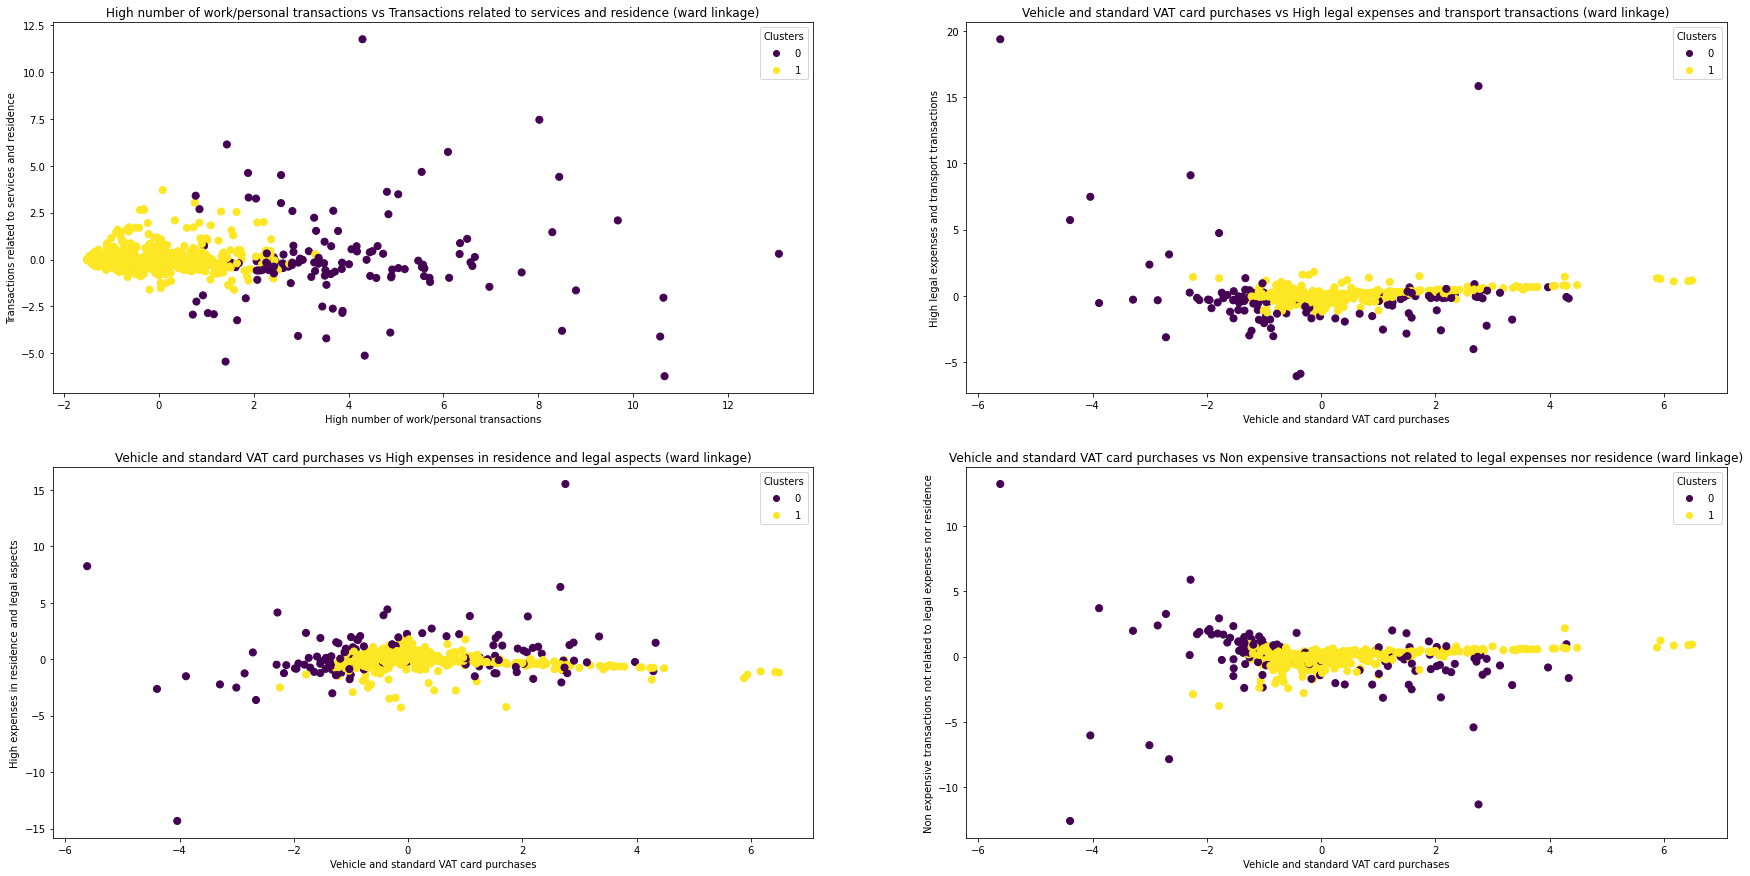

In [268]:
fig, axes = plt.subplots(2,2,figsize=(30,15))

points=axes[0][0].scatter(X[:, 0], X[:, 5], c=clustering.labels_, s=50, cmap='viridis')
axes[0][0].set_title("High number of work/personal transactions vs Transactions related to services and residence (%s linkage)" % link)
axes[0][0].set_xlabel('High number of work/personal transactions')
axes[0][0].set_ylabel('Transactions related to services and residence')
axes[0][0].legend(*points.legend_elements(), title="Clusters")


points=axes[0][1].scatter(X[:, 1], X[:, 2], c=clustering.labels_, s=50, cmap='viridis')
axes[0][1].set_title("Vehicle and standard VAT card purchases vs High legal expenses and transport transactions (%s linkage)" % link)
axes[0][1].set_xlabel('Vehicle and standard VAT card purchases')
axes[0][1].set_ylabel('High legal expenses and transport transactions')
axes[0][1].legend(*points.legend_elements(), title="Clusters")

points=axes[1][0].scatter(X[:, 1], X[:, 3], c=clustering.labels_, s=50, cmap='viridis')
axes[1][0].set_title("Vehicle and standard VAT card purchases vs High expenses in residence and legal aspects (%s linkage)" % link)
axes[1][0].set_xlabel('Vehicle and standard VAT card purchases')
axes[1][0].set_ylabel('High expenses in residence and legal aspects')
axes[1][0].legend(*points.legend_elements(), title="Clusters")

points=axes[1][1].scatter(X[:, 1], X[:, 4], c=clustering.labels_, s=50, cmap='viridis')
axes[1][1].set_title("Vehicle and standard VAT card purchases vs Non expensive transactions not related to legal expenses nor residence (%s linkage)" % link)
axes[1][1].set_xlabel('Vehicle and standard VAT card purchases')
axes[1][1].set_ylabel('Non expensive transactions not related to legal expenses nor residence')
axes[1][1].legend(*points.legend_elements(), title="Clusters")

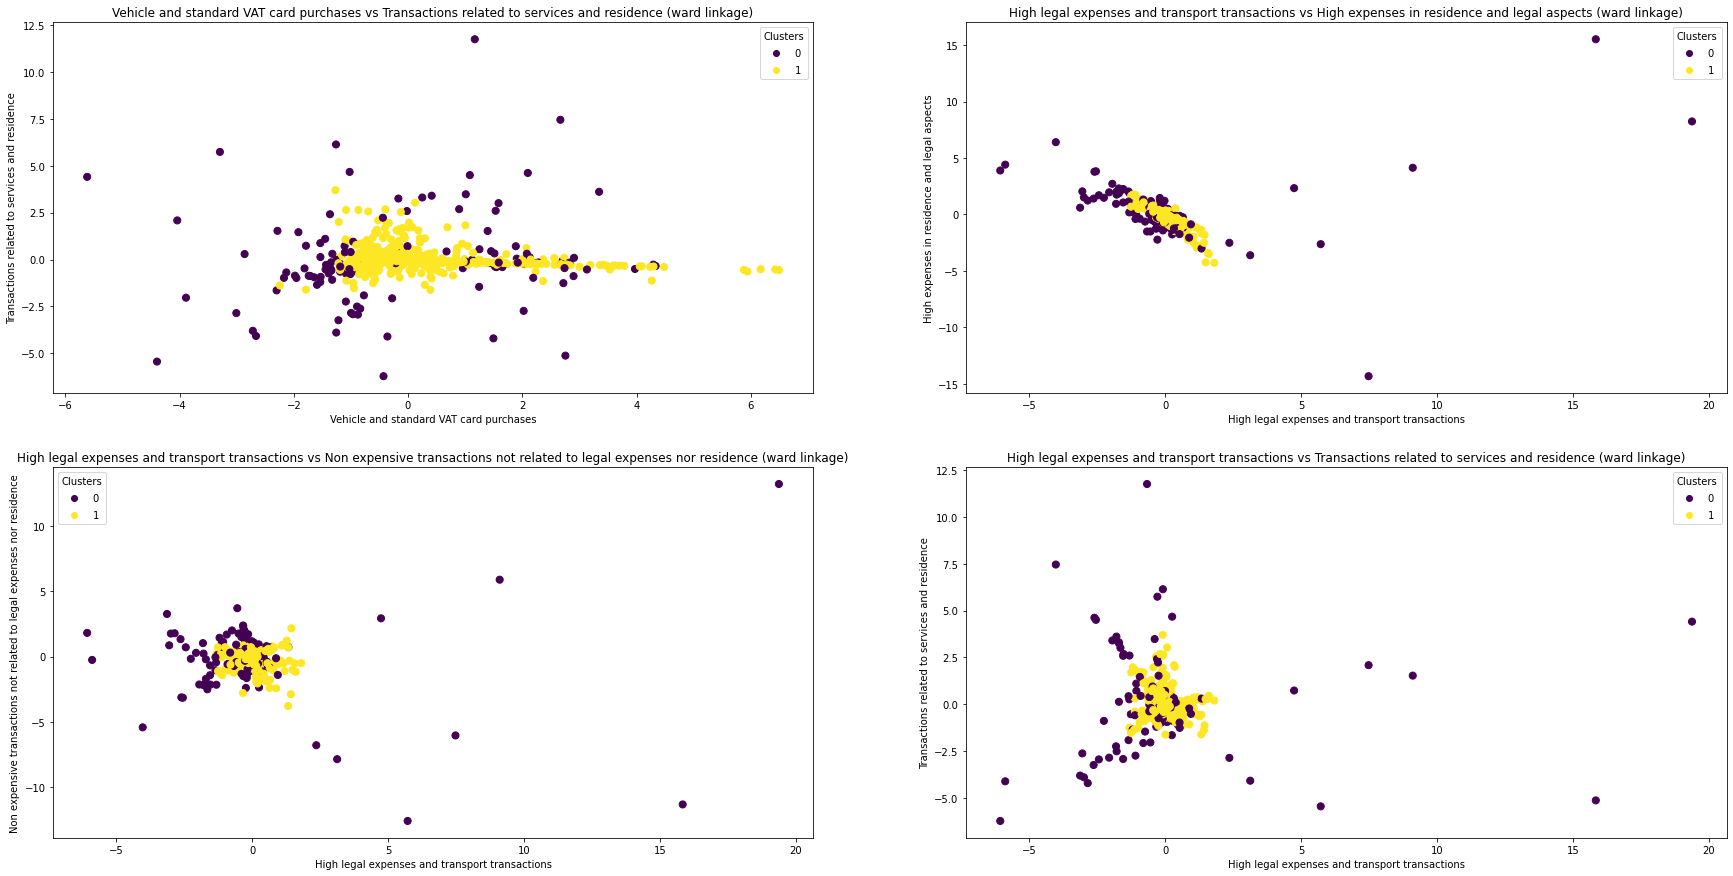

In [269]:
fig, axes = plt.subplots(2,2,figsize=(30,15))

points=axes[0][0].scatter(X[:, 1], X[:, 5], c=clustering.labels_, s=50, cmap='viridis')
axes[0][0].set_title("Vehicle and standard VAT card purchases vs Transactions related to services and residence (%s linkage)" % link)
axes[0][0].set_xlabel('Vehicle and standard VAT card purchases')
axes[0][0].set_ylabel('Transactions related to services and residence')
axes[0][0].legend(*points.legend_elements(), title="Clusters")

points=axes[0][1].scatter(X[:, 2], X[:, 3], c=clustering.labels_, s=50, cmap='viridis')
axes[0][1].set_title("High legal expenses and transport transactions vs High expenses in residence and legal aspects (%s linkage)" % link)
axes[0][1].set_xlabel('High legal expenses and transport transactions')
axes[0][1].set_ylabel('High expenses in residence and legal aspects')
axes[0][1].legend(*points.legend_elements(), title="Clusters")

points=axes[1][0].scatter(X[:, 2], X[:, 4], c=clustering.labels_, s=50, cmap='viridis')
axes[1][0].set_title("High legal expenses and transport transactions vs Non expensive transactions not related to legal expenses nor residence (%s linkage)" % link)
axes[1][0].set_xlabel('High legal expenses and transport transactions')
axes[1][0].set_ylabel('Non expensive transactions not related to legal expenses nor residence')
axes[1][0].legend(*points.legend_elements(), title="Clusters")

points=axes[1][1].scatter(X[:, 2], X[:, 5], c=clustering.labels_, s=50, cmap='viridis')
axes[1][1].set_title("High legal expenses and transport transactions vs Transactions related to services and residence (%s linkage)" % link)
axes[1][1].set_xlabel('High legal expenses and transport transactions')
axes[1][1].set_ylabel('Transactions related to services and residence')
axes[1][1].legend(*points.legend_elements(), title="Clusters")

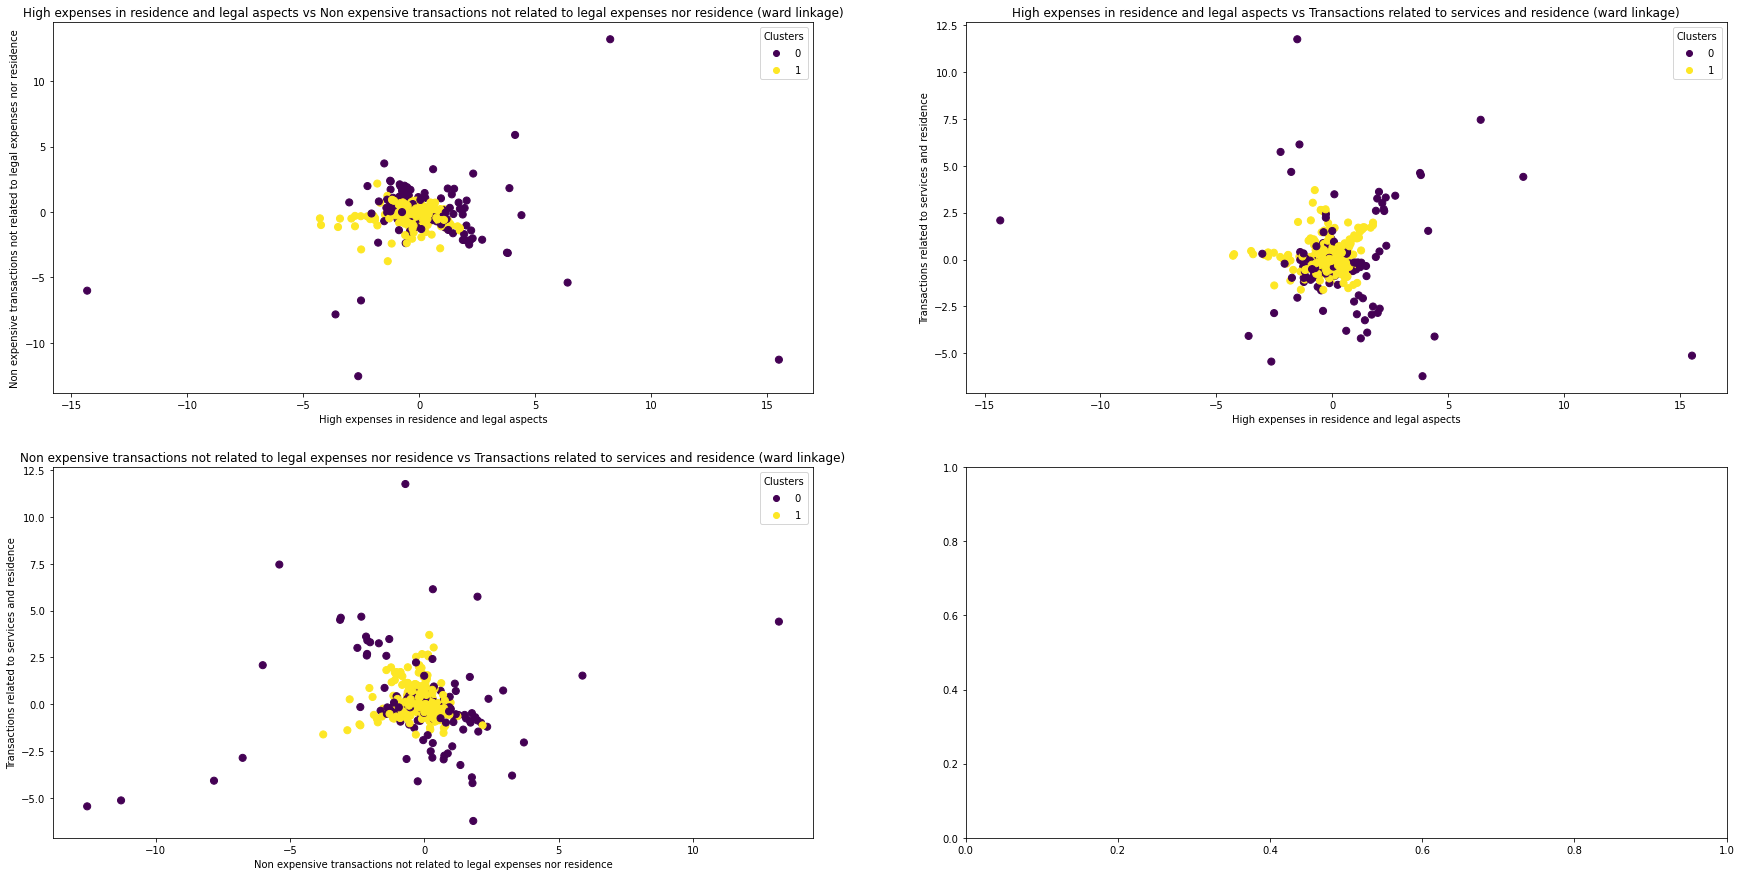

In [270]:
fig, axes = plt.subplots(2,2,figsize=(30,15))

points=axes[0][0].scatter(X[:, 3], X[:, 4], c=clustering.labels_, s=50, cmap='viridis')
axes[0][0].set_title("High expenses in residence and legal aspects vs Non expensive transactions not related to legal expenses nor residence (%s linkage)" % link)
axes[0][0].set_xlabel('High expenses in residence and legal aspects')
axes[0][0].set_ylabel('Non expensive transactions not related to legal expenses nor residence')
axes[0][0].legend(*points.legend_elements(), title="Clusters")

points=axes[0][1].scatter(X[:, 3], X[:, 5], c=clustering.labels_, s=50, cmap='viridis')
axes[0][1].set_title("High expenses in residence and legal aspects vs Transactions related to services and residence (%s linkage)" % link)
axes[0][1].set_xlabel('High expenses in residence and legal aspects')
axes[0][1].set_ylabel('Transactions related to services and residence')
axes[0][1].legend(*points.legend_elements(), title="Clusters")

points=axes[1][0].scatter(X[:, 4], X[:, 5], c=clustering.labels_, s=50, cmap='viridis')
axes[1][0].set_title("Non expensive transactions not related to legal expenses nor residence vs Transactions related to services and residence (%s linkage)" % link)
axes[1][0].set_xlabel('Non expensive transactions not related to legal expenses nor residence')
axes[1][0].set_ylabel('Transactions related to services and residence')
axes[1][0].legend(*points.legend_elements(), title="Clusters")

We save the clustering object.

In [331]:
df2014_hc2_pkl_filename = '/Users/andresaristi/Documents/BirminghamCardTransactions/pickle_files/df2014_hc2.pkl'
df2014_hc2_pkl = open(df2014_hc2_pkl_filename, 'wb')
pickle.dump(clustering, df2014_hc2_pkl)
df2014_hc2_pkl.close()

Population per cluster: 

In [272]:
counter = Counter(clustering.labels_)
counter

Counter({1: 865, 0: 128})

#### Profiling clients with hierarchical clustering with 2 clusters

By observing the scatter plots we will try to profile the clients, although 2 clusters seem too little.

<b>Cluster 0:</b> Scattered or spread out cluster. Clients from low up to high High number of work/personal transactions (scattered area), low to more than average Vehicle and standard VAT card purchases (scattered area), low High legal expenses and transport transactions (few of the clients have high values), average in High expenses in residence and legal aspects, average in Non expensive transactions not related to legal expenses nor residence and low to high in Transactions related to services and residence (scattered area).

<b>Cluster 1:</b> Dense cluster. Clients with the lowest High number of work/personal transactions, average to high Vehicle and standard VAT card purchases, low High legal expenses and transport transactions, average in High expenses in residence and legal aspects, average in Non expensive transactions not related to legal expenses nor residence and less than average in Transactions related to services and residence.



#### Clustering using ward linkage with k = 7

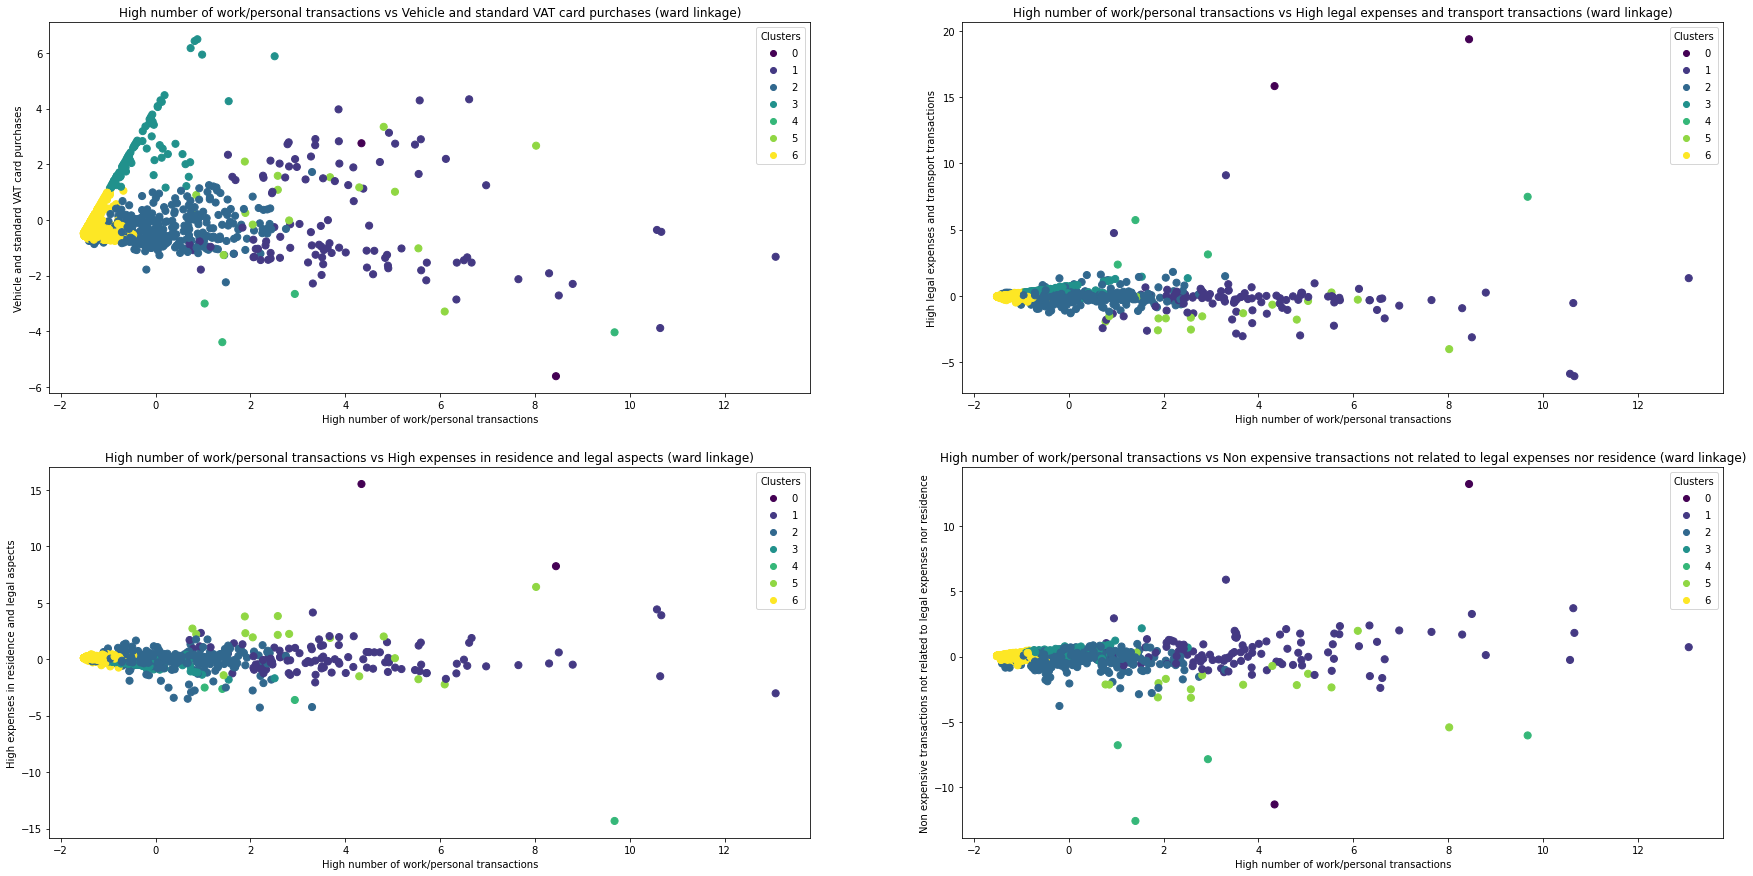

In [243]:
fig, axes = plt.subplots(2,2,figsize=(30,15))

link = 'ward'
clustering = AgglomerativeClustering(linkage=link, n_clusters=7)
clustering.fit(X)
points=axes[0][0].scatter(X[:, 0], X[:, 1], c=clustering.labels_, s=50, cmap='viridis')
axes[0][0].set_title("High number of work/personal transactions vs Vehicle and standard VAT card purchases (%s linkage)" % link)
axes[0][0].set_xlabel('High number of work/personal transactions')
axes[0][0].set_ylabel('Vehicle and standard VAT card purchases')
axes[0][0].legend(*points.legend_elements(), title="Clusters")

points=axes[0][1].scatter(X[:, 0], X[:, 2], c=clustering.labels_, s=50, cmap='viridis')
axes[0][1].set_title("High number of work/personal transactions vs High legal expenses and transport transactions (%s linkage)" % link)
axes[0][1].set_xlabel('High number of work/personal transactions')
axes[0][1].set_ylabel('High legal expenses and transport transactions')
axes[0][1].legend(*points.legend_elements(), title="Clusters")

points=axes[1][0].scatter(X[:, 0], X[:, 3], c=clustering.labels_, s=50, cmap='viridis')
axes[1][0].set_title("High number of work/personal transactions vs High expenses in residence and legal aspects (%s linkage)" % link)
axes[1][0].set_xlabel('High number of work/personal transactions')
axes[1][0].set_ylabel('High expenses in residence and legal aspects')
axes[1][0].legend(*points.legend_elements(), title="Clusters")

points=axes[1][1].scatter(X[:, 0], X[:, 4], c=clustering.labels_, s=50, cmap='viridis')
axes[1][1].set_title("High number of work/personal transactions vs Non expensive transactions not related to legal expenses nor residence (%s linkage)" % link)
axes[1][1].set_xlabel('High number of work/personal transactions')
axes[1][1].set_ylabel('Non expensive transactions not related to legal expenses nor residence')
axes[1][1].legend(*points.legend_elements(), title="Clusters")


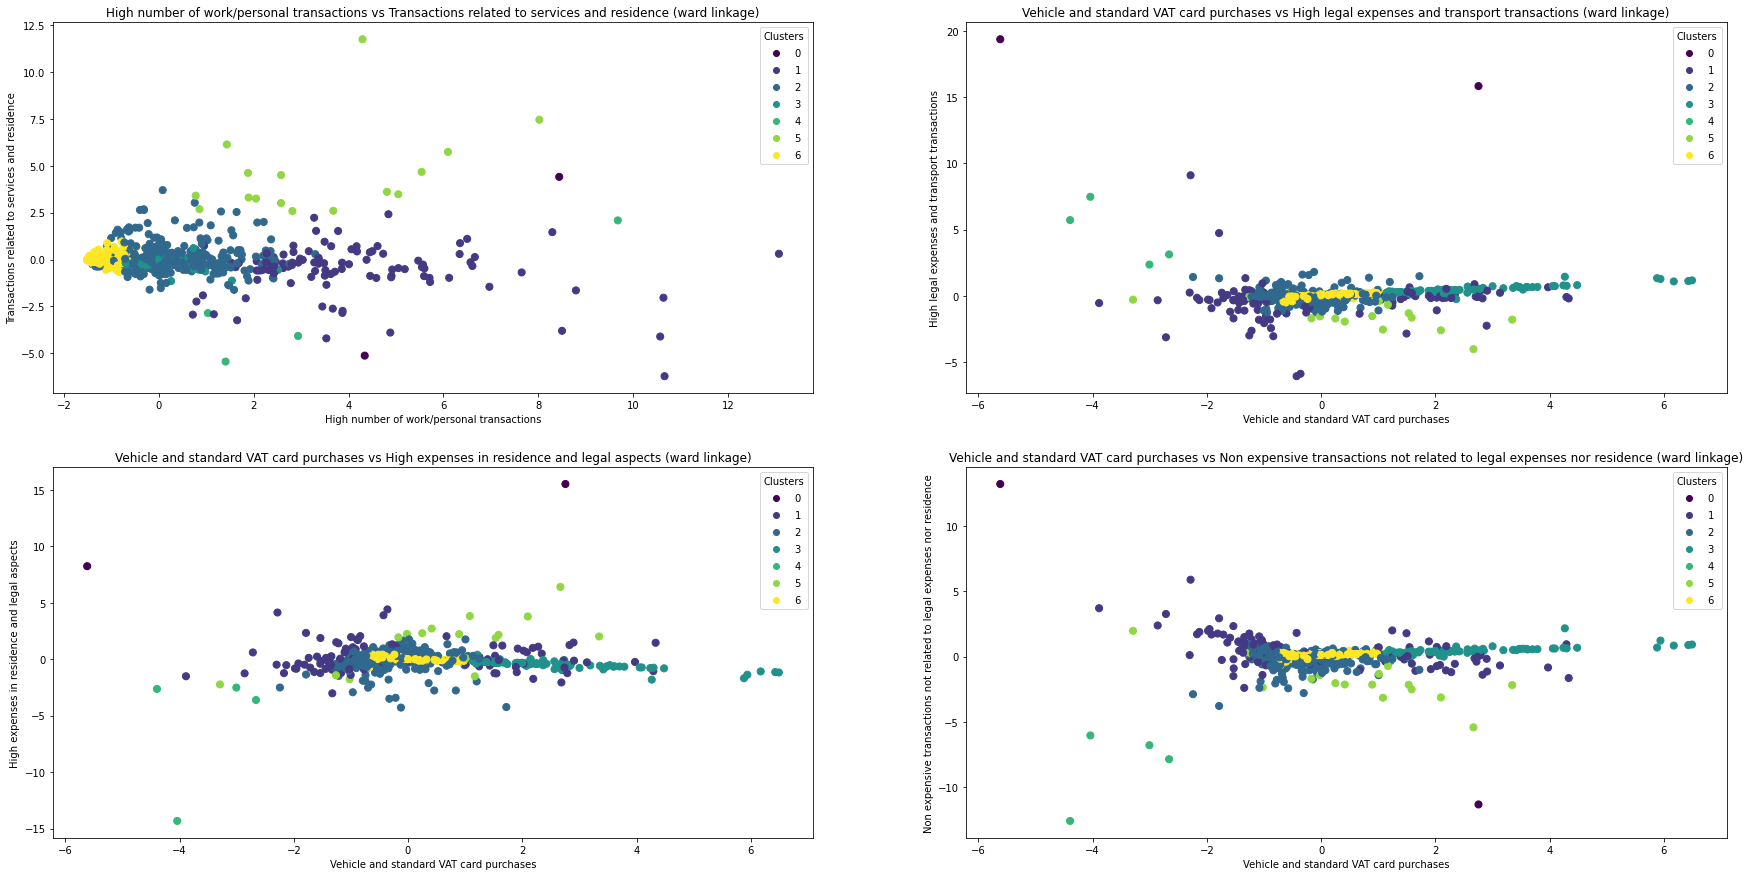

In [232]:
fig, axes = plt.subplots(2,2,figsize=(30,15))

points=axes[0][0].scatter(X[:, 0], X[:, 5], c=clustering.labels_, s=50, cmap='viridis')
axes[0][0].set_title("High number of work/personal transactions vs Transactions related to services and residence (%s linkage)" % link)
axes[0][0].set_xlabel('High number of work/personal transactions')
axes[0][0].set_ylabel('Transactions related to services and residence')
axes[0][0].legend(*points.legend_elements(), title="Clusters")

points=axes[0][1].scatter(X[:, 1], X[:, 2], c=clustering.labels_, s=50, cmap='viridis')
axes[0][1].set_title("Vehicle and standard VAT card purchases vs High legal expenses and transport transactions (%s linkage)" % link)
axes[0][1].set_xlabel('Vehicle and standard VAT card purchases')
axes[0][1].set_ylabel('High legal expenses and transport transactions')
axes[0][1].legend(*points.legend_elements(), title="Clusters")

points=axes[1][0].scatter(X[:, 1], X[:, 3], c=clustering.labels_, s=50, cmap='viridis')
axes[1][0].set_title("Vehicle and standard VAT card purchases vs High expenses in residence and legal aspects (%s linkage)" % link)
axes[1][0].set_xlabel('Vehicle and standard VAT card purchases')
axes[1][0].set_ylabel('High expenses in residence and legal aspects')
axes[1][0].legend(*points.legend_elements(), title="Clusters")

points=axes[1][1].scatter(X[:, 1], X[:, 4], c=clustering.labels_, s=50, cmap='viridis')
axes[1][1].set_title("Vehicle and standard VAT card purchases vs Non expensive transactions not related to legal expenses nor residence (%s linkage)" % link)
axes[1][1].set_xlabel('Vehicle and standard VAT card purchases')
axes[1][1].set_ylabel('Non expensive transactions not related to legal expenses nor residence')
axes[1][1].legend(*points.legend_elements(), title="Clusters")

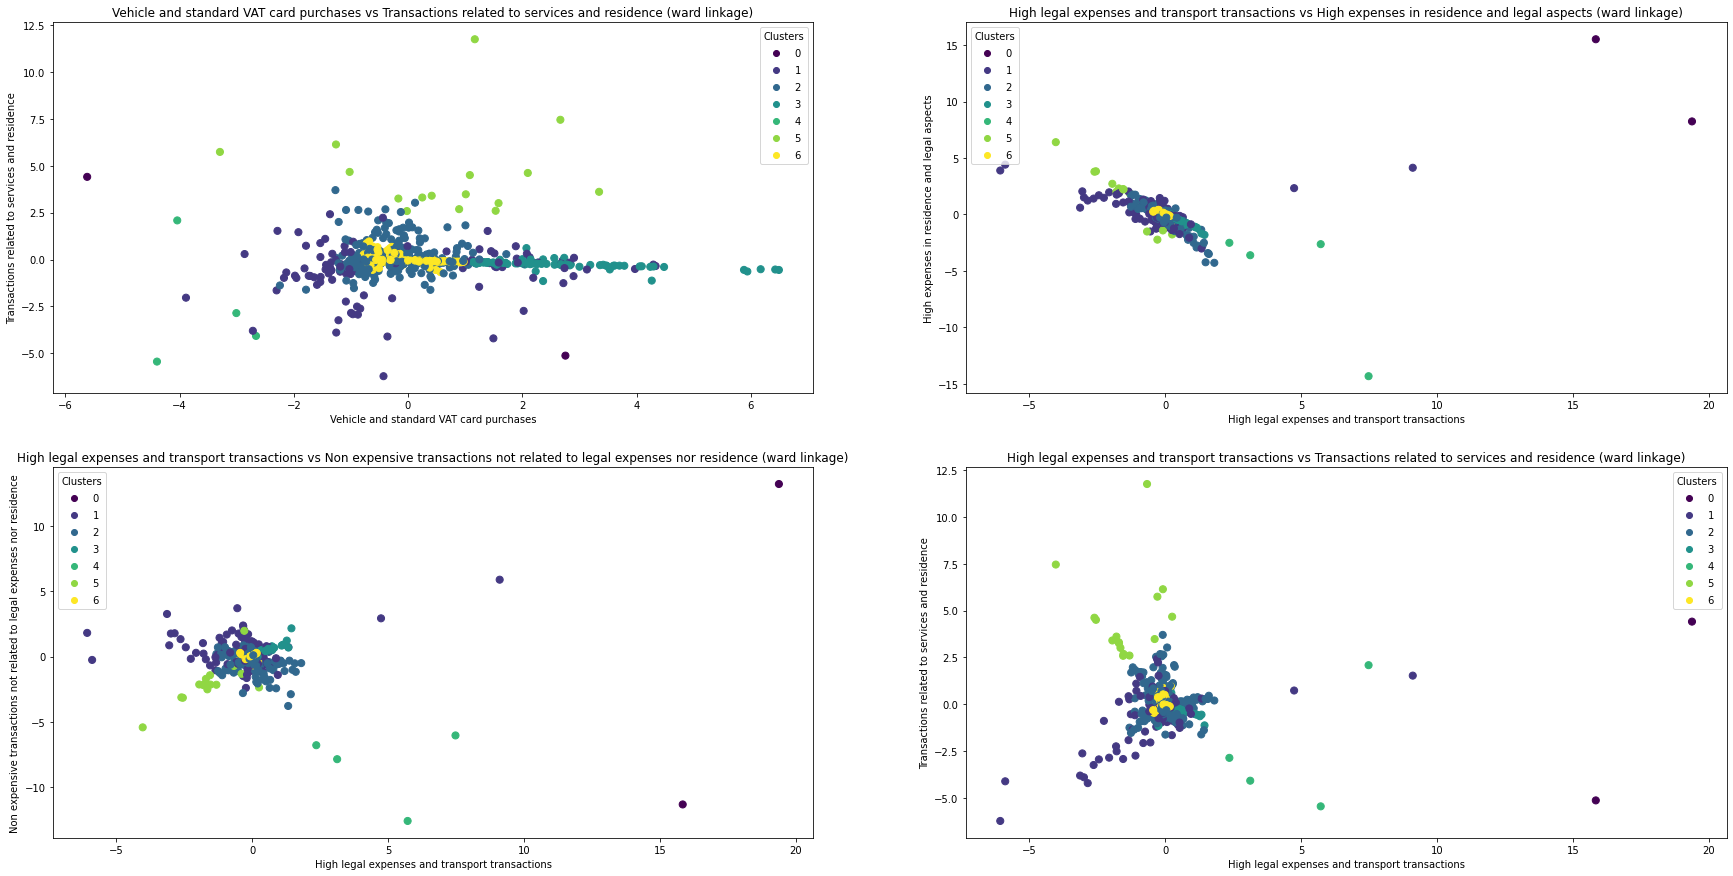

In [228]:
fig, axes = plt.subplots(2,2,figsize=(30,15))

points=axes[0][0].scatter(X[:, 1], X[:, 5], c=clustering.labels_, s=50, cmap='viridis')
axes[0][0].set_title("Vehicle and standard VAT card purchases vs Transactions related to services and residence (%s linkage)" % link)
axes[0][0].set_xlabel('Vehicle and standard VAT card purchases')
axes[0][0].set_ylabel('Transactions related to services and residence')
axes[0][0].legend(*points.legend_elements(), title="Clusters")

points=axes[0][1].scatter(X[:, 2], X[:, 3], c=clustering.labels_, s=50, cmap='viridis')
axes[0][1].set_title("High legal expenses and transport transactions vs High expenses in residence and legal aspects (%s linkage)" % link)
axes[0][1].set_xlabel('High legal expenses and transport transactions')
axes[0][1].set_ylabel('High expenses in residence and legal aspects')
axes[0][1].legend(*points.legend_elements(), title="Clusters")

points=axes[1][0].scatter(X[:, 2], X[:, 4], c=clustering.labels_, s=50, cmap='viridis')
axes[1][0].set_title("High legal expenses and transport transactions vs Non expensive transactions not related to legal expenses nor residence (%s linkage)" % link)
axes[1][0].set_xlabel('High legal expenses and transport transactions')
axes[1][0].set_ylabel('Non expensive transactions not related to legal expenses nor residence')
axes[1][0].legend(*points.legend_elements(), title="Clusters")

points=axes[1][1].scatter(X[:, 2], X[:, 5], c=clustering.labels_, s=50, cmap='viridis')
axes[1][1].set_title("High legal expenses and transport transactions vs Transactions related to services and residence (%s linkage)" % link)
axes[1][1].set_xlabel('High legal expenses and transport transactions')
axes[1][1].set_ylabel('Transactions related to services and residence')
axes[1][1].legend(*points.legend_elements(), title="Clusters")

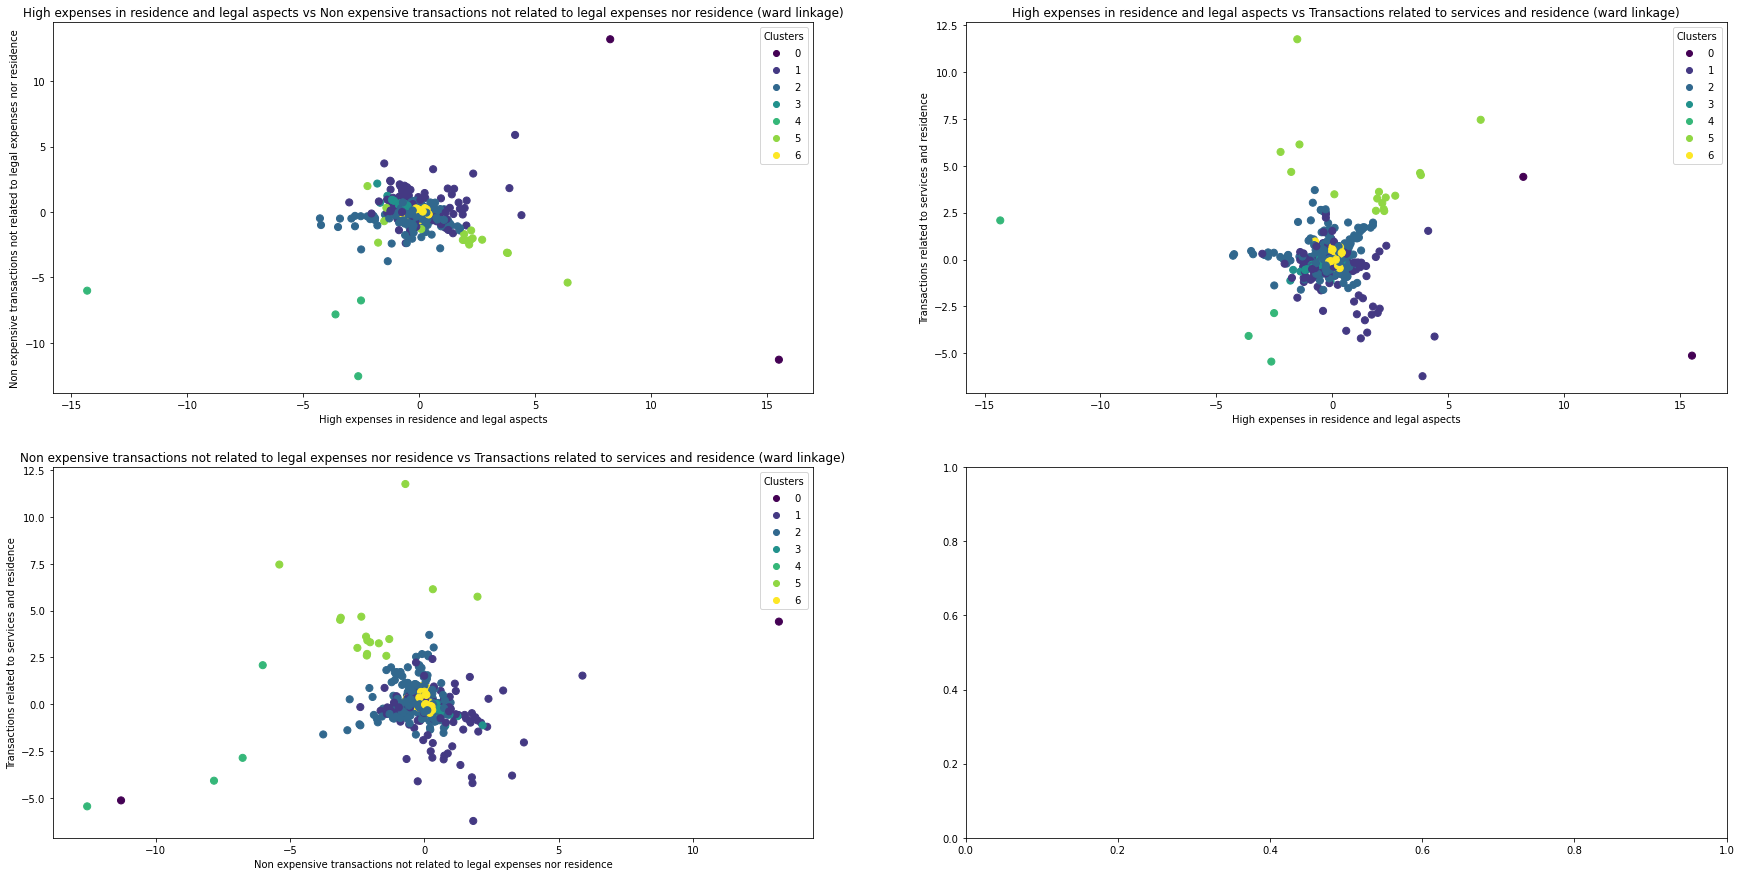

In [229]:
fig, axes = plt.subplots(2,2,figsize=(30,15))

points=axes[0][0].scatter(X[:, 3], X[:, 4], c=clustering.labels_, s=50, cmap='viridis')
axes[0][0].set_title("High expenses in residence and legal aspects vs Non expensive transactions not related to legal expenses nor residence (%s linkage)" % link)
axes[0][0].set_xlabel('High expenses in residence and legal aspects')
axes[0][0].set_ylabel('Non expensive transactions not related to legal expenses nor residence')
axes[0][0].legend(*points.legend_elements(), title="Clusters")

points=axes[0][1].scatter(X[:, 3], X[:, 5], c=clustering.labels_, s=50, cmap='viridis')
axes[0][1].set_title("High expenses in residence and legal aspects vs Transactions related to services and residence (%s linkage)" % link)
axes[0][1].set_xlabel('High expenses in residence and legal aspects')
axes[0][1].set_ylabel('Transactions related to services and residence')
axes[0][1].legend(*points.legend_elements(), title="Clusters")

points=axes[1][0].scatter(X[:, 4], X[:, 5], c=clustering.labels_, s=50, cmap='viridis')
axes[1][0].set_title("Non expensive transactions not related to legal expenses nor residence vs Transactions related to services and residence (%s linkage)" % link)
axes[1][0].set_xlabel('Non expensive transactions not related to legal expenses nor residence')
axes[1][0].set_ylabel('Transactions related to services and residence')
axes[1][0].legend(*points.legend_elements(), title="Clusters")

We save the clustering object.

In [332]:
df2014_hc7_pkl_filename = '/Users/andresaristi/Documents/BirminghamCardTransactions/pickle_files/df2014_hc7.pkl'
df2014_hc7_pkl = open(df2014_hc7_pkl_filename, 'wb')
pickle.dump(clustering, df2014_hc7_pkl)
df2014_hc7_pkl.close()

Population per cluster: 

In [242]:
counter = Counter(clustering.labels_)
counter

Counter({6: 464, 1: 106, 2: 306, 3: 95, 5: 16, 4: 4, 0: 2})

#### Profiling clients with hierarchical clustering with 7 clusters

By observing the scatter plots we will try to figure out the profile of clients, although some of the plots are not really useful. Clusters 4 and 0 have to few observations to interpret.

<b>Cluster 0:</b> Not enough data points to interpret.

<b>Cluster 1:</b> Clients with average High number of work/personal transactions (with some clients having really high values), average Vehicle and standard VAT card purchases, low High legal expenses and transport transactions (few of the clients have high values), average in High expenses in residence and legal aspects, average in Non expensive transactions not related to legal expenses nor residence and less than average in Transactions related to services and residence.

<b>Cluster 2:</b> Clients with the lowest High number of work/personal transactions, average in Vehicle and standard VAT card purchases, lower than average in High legal expenses and transport transactions, average in High expenses in residence and legal aspects, average in Non expensive transactions not related to legal expenses nor residence and less than average in Transactions related to services and residence.

<b>Cluster 3:</b> Clients with the lowest High number of work/personal transactions, the highest Vehicle and standard VAT card purchases, the lowest High legal expenses and transport transactions, average in High expenses in residence and legal aspects, average in Non expensive transactions not related to legal expenses nor residence and lower than average in Transactions related to services and residence.

<b>Cluster 4:</b> Not enough data points to interpret.

<b>Cluster 5:</b> Clients with less than average in High number of work/personal transactions, an average Vehicle and standard VAT card purchases, the lowest High legal expenses and transport transactions, average in High expenses in residence and legal aspects, average in Non expensive transactions not related to legal expenses nor residence and few Transactions related to services and residence.

<b>Cluster 6:</b> Clients with average High number of work/personal transactions, more than average Vehicle and standard VAT card purchases, the lowest High legal expenses and transport transactions, high in High expenses in residence and legal aspects, less than average in Non expensive transactions not related to legal expenses nor residence and high on Transactions related to services and residence.



#### DBSCAN

We will be using DBSCAN as another clustering techinque to find the best groups of clients, in order for us to profile them.

<AxesSubplot:xlabel='0', ylabel='count'>

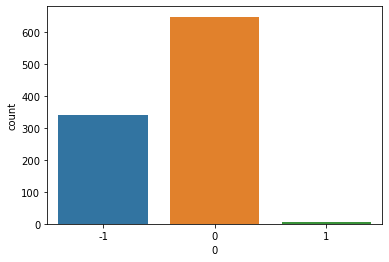

In [273]:
data2014_db = data2014_kmeans.copy()
min_points = 5
eps = 0.45
model = DBSCAN(min_samples = min_points, eps=eps) 
model.fit(X)
clusters = pd.DataFrame(model.fit_predict(X))
data2014_db['Cluster'] = clusters.values
num_clusters = len(set(modelo.labels_))-1
num_clusters
clusters
sns.countplot(x=0,data=clusters)

We found out that there were two clusters plus the noise. We made a plot bar with those results.


In [274]:
data2014_db.Cluster.value_counts()
data2014_db

High number of work/personal transactions  \
CARD NUMBER                                                   
************0007                                  -1.102613   
************0015                                  -1.510223   
************0040                                  -1.279980   
************0047                                   3.035147   
************0057                                  -1.244730   
...                                                     ...   
************9957                                   1.126939   
************9963                                  -1.360561   
************9968                                  -1.224845   
************9971                                   0.046710   
************9989                                   3.667547   

                  Vehicle and standard VAT card purchases  \
CARD NUMBER                                                 
************0007                                -0.609923   
************0015                                -0.474573   
************0040                                 0.171561   
************0047                                -0.145967   
************0057                                -0.104075   
...                                                   ...   
************9957                                 1.249133   
************9963                                -0.450382   
************9968                                 0.199069   
************9971                                -0.869348   
************9989                                -0.836873   

                  High legal expenses and transport transactions  \
CARD NUMBER                                                        
************0007                                       -0.078921   
************0015                                       -0.049181   
************0040                                        0.070341   
************0047                                       -0.586113   
************0057                                       -0.108621   
...                                                          ...   
************9957                                       -0.095804   
************9963                                       -0.067909   
************9968                                        0.106738   
************9971                                        0.040100   
************9989                                       -3.051555   

                  High expenses in residence and legal aspects  \
CARD NUMBER                                                      
************0007                                     -0.002634   
************0015                                      0.109719   
************0040                                     -0.017045   
************0047                                      0.532373   
************0057                                      0.089445   
...                                                        ...   
************9957                                      0.050369   
************9963                                      0.153903   
************9968                                     -0.070366   
************9971                                     -0.278259   
************9989                                      2.046489   

                  Non expensive transactions not related to legal expenses nor residence  \
CARD NUMBER                                                                                
************0007                                           0.090542                        
************0015                                           0.067047                        
************0040                                           0.157104                        
************0047                                          -0.254677                        
************0057                                           0.235960                        
...             

We save the dataframe resulting from the DBSCAN

In [333]:
df2014_db_pkl_filename = '/Users/andresaristi/Documents/BirminghamCardTransactions/pickle_files/df2014_db.pkl'
df2014_db_pkl = open(df2014_db_pkl_filename, 'wb')
pickle.dump(data2014_db, df2014_db_pkl)
df2014_db_pkl.close()

We start using scatter plots taking into account the PCs in order to characterize our segments.

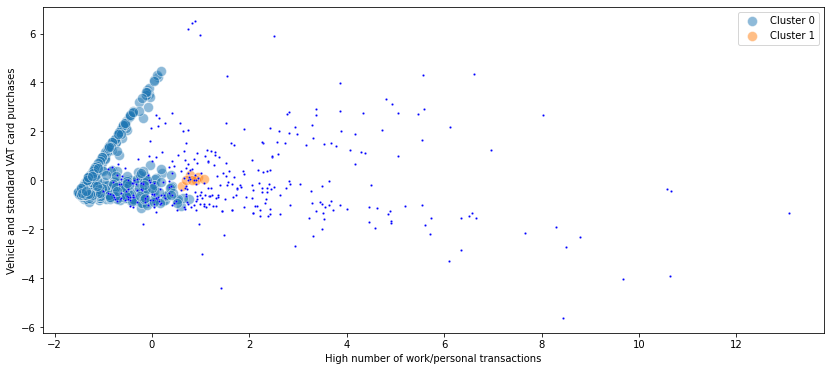

In [304]:
fig = plt.figure(figsize=(14,6))

for cluster in range(0,num_clusters):
    sns.scatterplot(x="High number of work/personal transactions", y="Vehicle and standard VAT card purchases", s=100, alpha=0.5,
                    data=data2014_db.loc[data2014_db.Cluster==cluster,:])
sns.scatterplot(x="High number of work/personal transactions", y="Vehicle and standard VAT card purchases", s=5, color = 'b',
                    data=data2014_db.loc[data2014_db.Cluster==-1,:])
plt.legend(['Cluster 0', 'Cluster 1'])
plt.show()

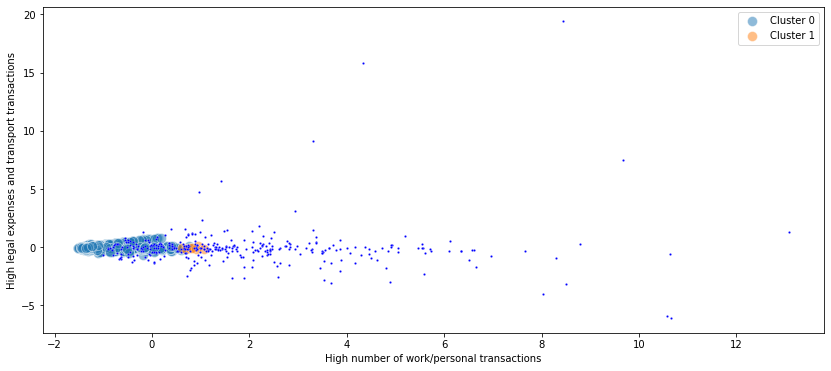

In [305]:
fig = plt.figure(figsize=(14,6))

for cluster in range(0,num_clusters):
    sns.scatterplot(x="High number of work/personal transactions", y="High legal expenses and transport transactions", s=100, alpha=0.5,
                    data=data2014_db.loc[data2014_db.Cluster==cluster,:])
sns.scatterplot(x="High number of work/personal transactions", y="High legal expenses and transport transactions", s=5, color = 'b',
                    data=data2014_db.loc[data2014_db.Cluster==-1,:])
plt.legend(['Cluster 0', 'Cluster 1'])
plt.show()

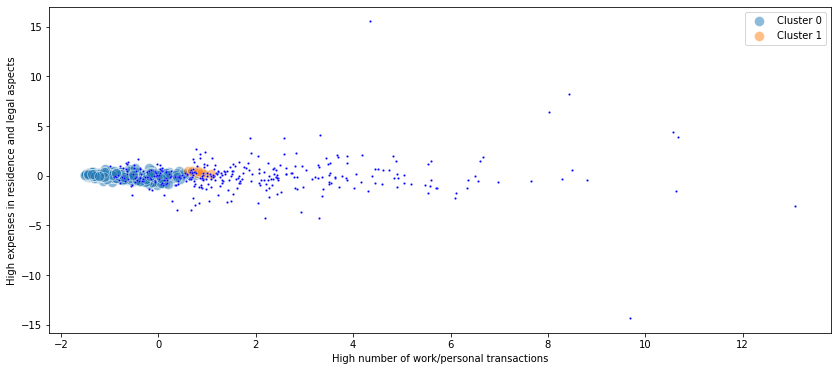

In [306]:
fig = plt.figure(figsize=(14,6))

for cluster in range(0,num_clusters):
    sns.scatterplot(x="High number of work/personal transactions", y="High expenses in residence and legal aspects", s=100, alpha=0.5,
                    data=data2014_db.loc[data2014_db.Cluster==cluster,:])
sns.scatterplot(x="High number of work/personal transactions", y="High expenses in residence and legal aspects", s=5, color = 'b',
                    data=data2014_db.loc[data2014_db.Cluster==-1,:])
plt.legend(['Cluster 0', 'Cluster 1'])
plt.show()

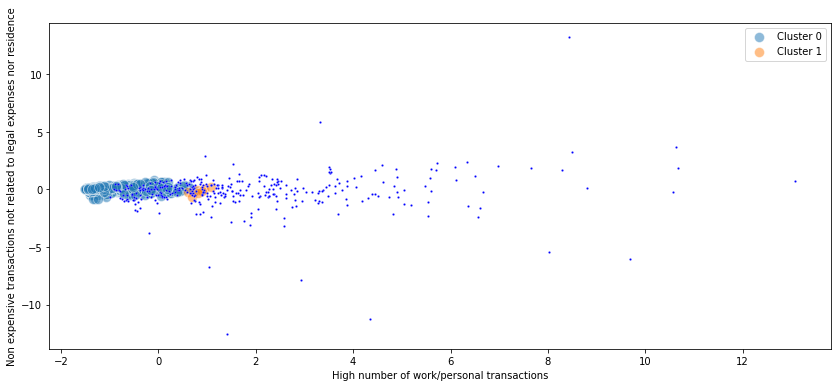

In [307]:
fig = plt.figure(figsize=(14,6))

for cluster in range(0,num_clusters):
    sns.scatterplot(x="High number of work/personal transactions", y="Non expensive transactions not related to legal expenses nor residence", s=100, alpha=0.5,
                    data=data2014_db.loc[data2014_db.Cluster==cluster,:])
sns.scatterplot(x="High number of work/personal transactions", y="Non expensive transactions not related to legal expenses nor residence", s=5, color = 'b',
                    data=data2014_db.loc[data2014_db.Cluster==-1,:])
plt.legend(['Cluster 0', 'Cluster 1'])
plt.show()

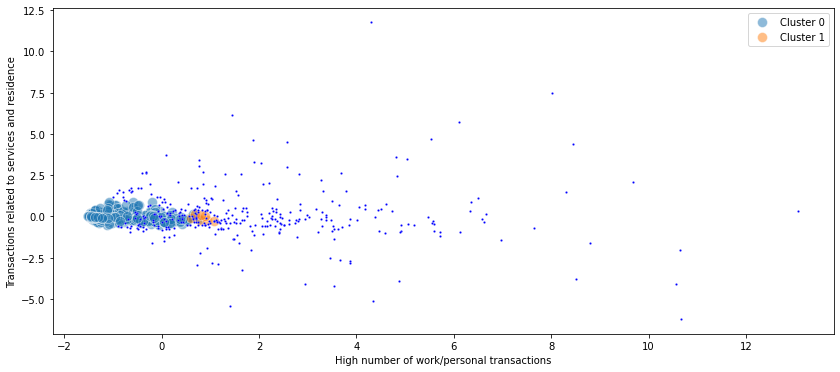

In [308]:
fig = plt.figure(figsize=(14,6))

for cluster in range(0,num_clusters):
    sns.scatterplot(x="High number of work/personal transactions", y="Transactions related to services and residence", s=100, alpha=0.5,
                    data=data2014_db.loc[data2014_db.Cluster==cluster,:])
sns.scatterplot(x="High number of work/personal transactions", y="Transactions related to services and residence", s=5, color = 'b',
                    data=data2014_db.loc[data2014_db.Cluster==-1,:])
plt.legend(['Cluster 0', 'Cluster 1'])
plt.show()

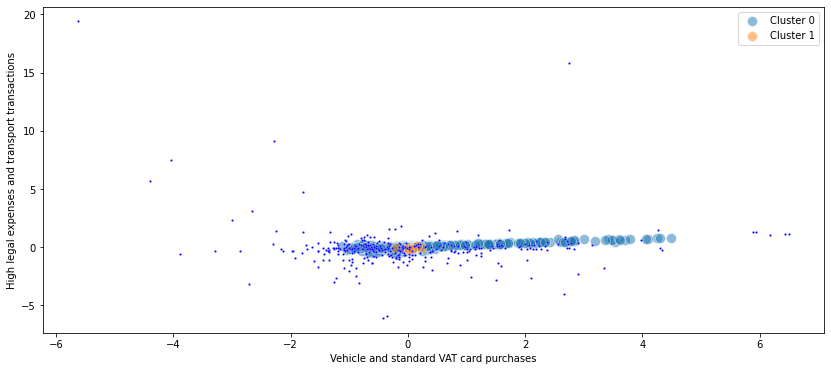

In [309]:
fig = plt.figure(figsize=(14,6))

for cluster in range(0,num_clusters):
    sns.scatterplot(x="Vehicle and standard VAT card purchases", y="High legal expenses and transport transactions", s=100, alpha=0.5,
                    data=data2014_db.loc[data2014_db.Cluster==cluster,:])
sns.scatterplot(x="Vehicle and standard VAT card purchases", y="High legal expenses and transport transactions", s=5, color = 'b',
                    data=data2014_db.loc[data2014_db.Cluster==-1,:])
plt.legend(['Cluster 0', 'Cluster 1'])
plt.show()

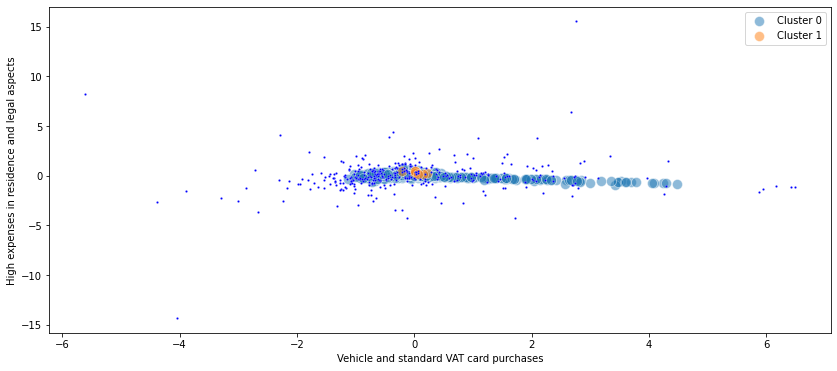

In [310]:
fig = plt.figure(figsize=(14,6))

for cluster in range(0,num_clusters):
    sns.scatterplot(x="Vehicle and standard VAT card purchases", y="High expenses in residence and legal aspects", s=100, alpha=0.5,
                    data=data2014_db.loc[data2014_db.Cluster==cluster,:])
sns.scatterplot(x="Vehicle and standard VAT card purchases", y="High expenses in residence and legal aspects", s=5, color = 'b',
                    data=data2014_db.loc[data2014_db.Cluster==-1,:])
plt.legend(['Cluster 0', 'Cluster 1'])
plt.show()

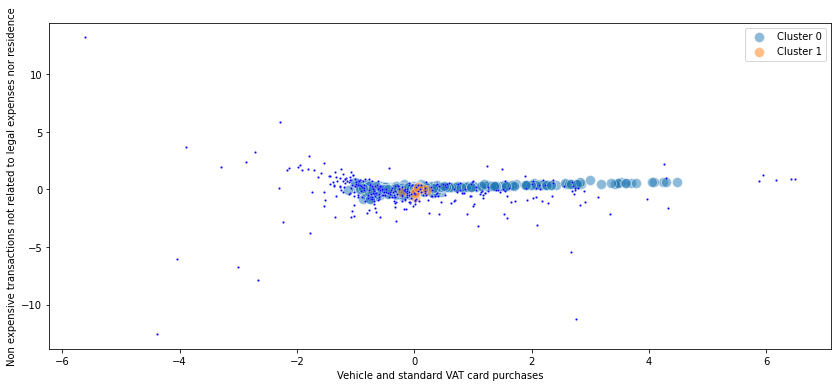

In [311]:
fig = plt.figure(figsize=(14,6))

for cluster in range(0,num_clusters):
    sns.scatterplot(x="Vehicle and standard VAT card purchases", y="Non expensive transactions not related to legal expenses nor residence", s=100, alpha=0.5,
                    data=data2014_db.loc[data2014_db.Cluster==cluster,:])
sns.scatterplot(x="Vehicle and standard VAT card purchases", y="Non expensive transactions not related to legal expenses nor residence", s=5, color = 'b',
                    data=data2014_db.loc[data2014_db.Cluster==-1,:])
plt.legend(['Cluster 0', 'Cluster 1'])
plt.show()

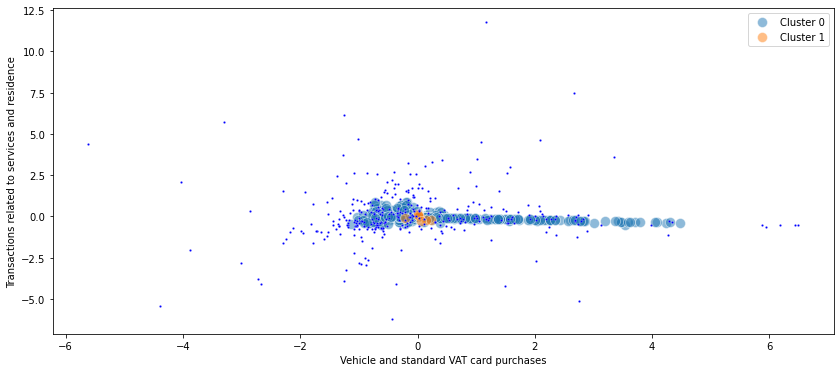

In [312]:
fig = plt.figure(figsize=(14,6))

for cluster in range(0,num_clusters):
    sns.scatterplot(x="Vehicle and standard VAT card purchases", y="Transactions related to services and residence", s=100, alpha=0.5,
                    data=data2014_db.loc[data2014_db.Cluster==cluster,:])
sns.scatterplot(x="Vehicle and standard VAT card purchases", y="Transactions related to services and residence", s=5, color = 'b',
                    data=data2014_db.loc[data2014_db.Cluster==-1,:])
plt.legend(['Cluster 0', 'Cluster 1'])
plt.show()

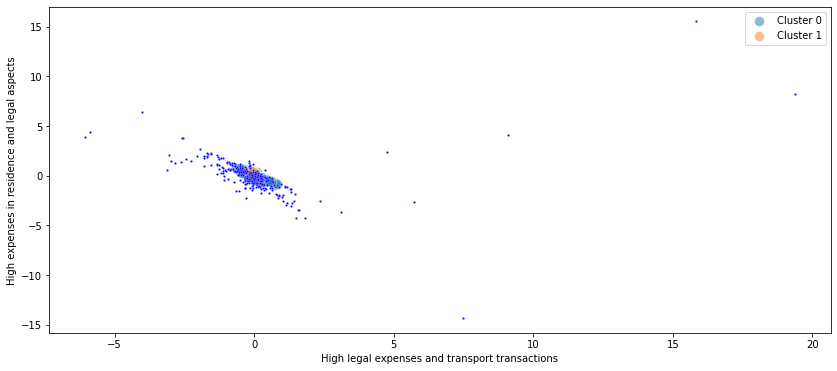

In [313]:
fig = plt.figure(figsize=(14,6))

for cluster in range(0,num_clusters):
    sns.scatterplot(x="High legal expenses and transport transactions", y="High expenses in residence and legal aspects", s=100, alpha=0.5,
                    data=data2014_db.loc[data2014_db.Cluster==cluster,:])
sns.scatterplot(x="High legal expenses and transport transactions", y="High expenses in residence and legal aspects", s=5, color = 'b',
                    data=data2014_db.loc[data2014_db.Cluster==-1,:])
plt.legend(['Cluster 0', 'Cluster 1'])
plt.show()

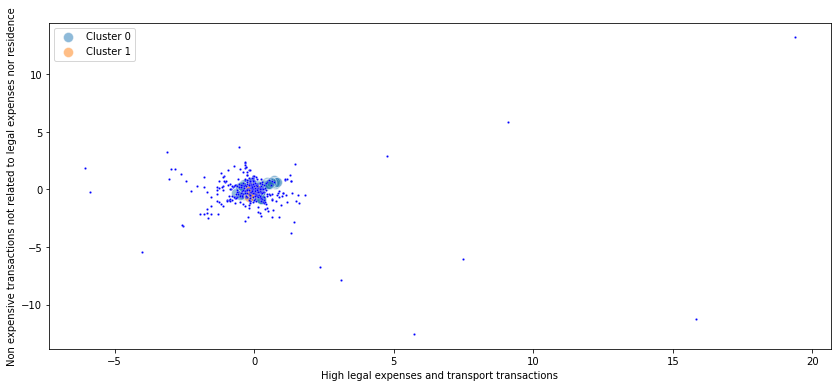

In [314]:
fig = plt.figure(figsize=(14,6))

for cluster in range(0,num_clusters):
    sns.scatterplot(x="High legal expenses and transport transactions", y="Non expensive transactions not related to legal expenses nor residence", s=100, alpha=0.5,
                    data=data2014_db.loc[data2014_db.Cluster==cluster,:])
sns.scatterplot(x="High legal expenses and transport transactions", y="Non expensive transactions not related to legal expenses nor residence", s=5, color = 'b',
                    data=data2014_db.loc[data2014_db.Cluster==-1,:])
plt.legend(['Cluster 0', 'Cluster 1'])
plt.show()

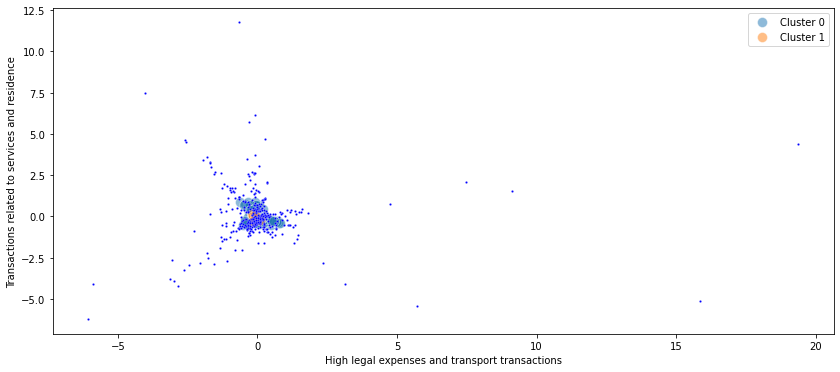

In [315]:
fig = plt.figure(figsize=(14,6))

for cluster in range(0,num_clusters):
    sns.scatterplot(x="High legal expenses and transport transactions", y="Transactions related to services and residence", s=100, alpha=0.5,
                    data=data2014_db.loc[data2014_db.Cluster==cluster,:])
sns.scatterplot(x="High legal expenses and transport transactions", y="Transactions related to services and residence", s=5, color = 'b',
                    data=data2014_db.loc[data2014_db.Cluster==-1,:])
plt.legend(['Cluster 0', 'Cluster 1'])
plt.show()

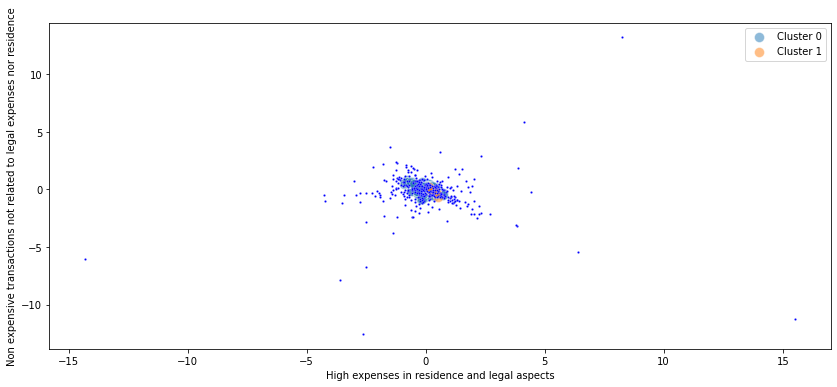

In [316]:
fig = plt.figure(figsize=(14,6))

for cluster in range(0,num_clusters):
    sns.scatterplot(x="High expenses in residence and legal aspects", y="Non expensive transactions not related to legal expenses nor residence", s=100, alpha=0.5,
                    data=data2014_db.loc[data2014_db.Cluster==cluster,:])
sns.scatterplot(x="High expenses in residence and legal aspects", y="Non expensive transactions not related to legal expenses nor residence", s=5, color = 'b',
                    data=data2014_db.loc[data2014_db.Cluster==-1,:])
plt.legend(['Cluster 0', 'Cluster 1'])
plt.show()

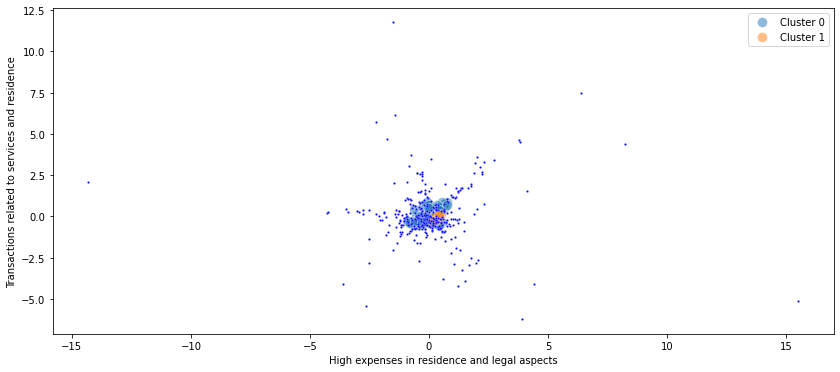

In [317]:
fig = plt.figure(figsize=(14,6))

for cluster in range(0,num_clusters):
    sns.scatterplot(x="High expenses in residence and legal aspects", y="Transactions related to services and residence", s=100, alpha=0.5,
                    data=data2014_db.loc[data2014_db.Cluster==cluster,:])
sns.scatterplot(x="High expenses in residence and legal aspects", y="Transactions related to services and residence", s=5, color = 'b',
                    data=data2014_db.loc[data2014_db.Cluster==-1,:])
plt.legend(['Cluster 0', 'Cluster 1'])
plt.show()

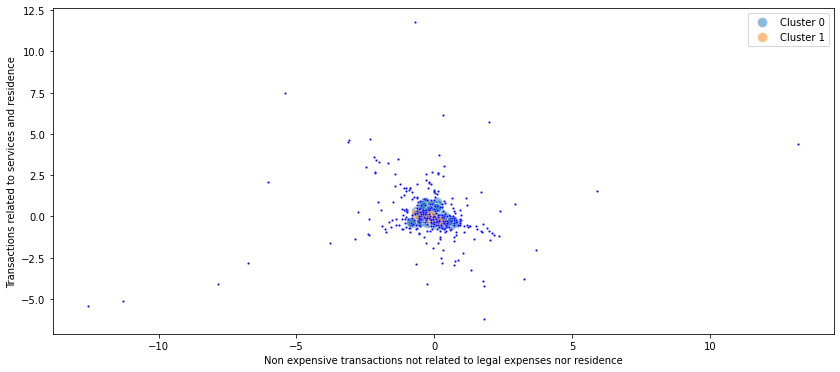

In [318]:
fig = plt.figure(figsize=(14,6))

for cluster in range(0,num_clusters):
    sns.scatterplot(x="Non expensive transactions not related to legal expenses nor residence", y="Transactions related to services and residence", s=100, alpha=0.5,
                    data=data2014_db.loc[data2014_db.Cluster==cluster,:])
sns.scatterplot(x="Non expensive transactions not related to legal expenses nor residence", y="Transactions related to services and residence", s=5, color = 'b',
                    data=data2014_db.loc[data2014_db.Cluster==-1,:])
plt.legend(['Cluster 0', 'Cluster 1'])
plt.show()

#### Profiling clients with DBSCAN with 2 clusters

By observing the scatter plots we will try to profile the clients, although 2 clusters seem too little.

<b>Cluster 0:</b> More data points. Clients with the lowest High number of work/personal transactions (scattered area), average to high Vehicle and standard VAT card purchases, low High legal expenses and transport transactions, average in High expenses in residence and legal aspects, average in Non expensive transactions not related to legal expenses nor residence and less than average in Transactions related to services and residence.

<b>Cluster 1:</b> Less data points. Clients with low High number of work/personal transactions, average Vehicle and standard VAT card purchases, low High legal expenses and transport transactions, average in High expenses in residence and legal aspects, average in Non expensive transactions not related to legal expenses nor residence and less than average in Transactions related to services and residence.

### K-modes

We will try to use k-modes, an extension of k-means, which instead of using distances uses dissimilarities (that is, quantification of the total mismatches between two objects), so we can work with categorical values, most of the features available in this dataset.

We set the date of the transaction as the index because with this clustering technique we are going to try to answer the question which are the all around purchase card transactions' profiles for the year 2014?

In [403]:
df2014_kmodes = df2014_pkl_loaded.copy()
df2014_kmodes.set_index('TRANS DATE',inplace=True)

pandas.core.frame.DataFrame

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 255090.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 255090.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 255090.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 255090.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 255090.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 6473, cost: 227379.0
Run 1, iteration: 2/100, moves: 2840, cost: 227306.0
Run 1, iteration: 3/100, moves: 23, cost: 227306.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iter

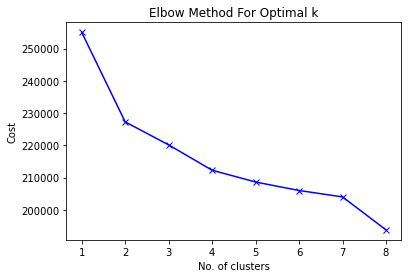

In [342]:
cost = []
K = range(1,9)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(df2014_kmodes)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

Using the elbow method we found out that the amount of clusters may be 2 or 8. We will analyze both of them.

In [411]:
df2014_kmodes2 = df2014_kmodes.copy()
kmodes = KModes(n_clusters=2)
df2014_kmodes2['kmodes_cluster'] = kmodes.fit_predict(df2014_kmodes2)

df2014_kmodes8 = df2014_kmodes.copy()
kmodes = KModes(n_clusters=8)
df2014_kmodes8['kmodes_cluster'] = kmodes.fit_predict(df2014_kmodes8)

We found out the names of the features in the dataframe

In [412]:
df2014_kmodes.columns

Index(['TRANS VAT DESC', 'ORIGINAL GROSS AMT', 'MERCHANT NAME', 'CARD NUMBER',
       'BILLING CUR CODE', 'TRANS CAC CODE 1', 'TRANS CAC DESC 1',
       'TRANS CAC CODE 2', 'TRANS CAC DESC 2', 'TRANS CAC CODE 3',
       'Directorate'],
      dtype='object')

We define a function to make a count plot for each of the categories of the features for each cluster. That in order to profile the cluster of transactions.

In [413]:
def analyze_cluster(features,data,cluster_number):
    for feature in features:
        plt.figure(figsize=(15,15))
        sns.countplot(x=feature, data=data[data['kmodes_cluster']==cluster_number])
        plt.show()

In [414]:
type(df2014_kmodes2)

pandas.core.frame.DataFrame

In [441]:
feature = 'TRANS CAC DESC 1'
old_cats = ['Vehicle Fuel','Vehicle Excise Lics','Vehicle R&M','Vehicle OthrunCosts','Car Allowances etc','Car Parking','Vehicle Hire Charge','Vehicle Tyres']
new_cat = 'Vehicles'
for c in old_cats:
    df2014_kmodes2.loc[df2014_kmodes2[feature] == c, feature] = new_cat
    df2014_kmodes8.loc[df2014_kmodes8[feature] == c, feature] = new_cat


In [442]:
feature = 'TRANS CAC DESC 1'
old_cats = ['Books','Purchases Food','Hospitality','Postage','Personal Needs','Clothing&Uniforms',
            'Subscriptions','Laundry','Entertainers/Artists','Mobiles/Radios/Pagrs','Floral Decorations',
           'Aftercare Assistance',"Mat'l Raw/Drct",'In Year Credits','CSDP Act Telephones']
new_cat = 'Personal needs'
for c in old_cats:
    df2014_kmodes2.loc[df2014_kmodes2[feature] == c, feature] = new_cat
    df2014_kmodes8.loc[df2014_kmodes8[feature] == c, feature] = new_cat

In [444]:
feature = 'TRANS CAC DESC 1'
old_cats = ['Photocopying','Gas','Electricity',"N'Papers&Periodicals",'Other Services','Disinfestation',
           'Consultancy Fees','Security Contracts','Phon NonCentrx Lines','Bank & Goro ChgsS','Refuse Collection']
new_cat = 'Services'
for c in old_cats:
    df2014_kmodes2.loc[df2014_kmodes2[feature] == c, feature] = new_cat
    df2014_kmodes8.loc[df2014_kmodes8[feature] == c, feature] = new_cat

In [445]:
feature = 'TRANS CAC DESC 1'
old_cats = ['Travel Bus/Rail',"Ttavel Other (UK)",'Travel Taxis','Travel Foreign','Transport Misc',
            'Transport Insurance']
new_cat = 'Transport'
for c in old_cats:
    df2014_kmodes2.loc[df2014_kmodes2[feature] == c, feature] = new_cat
    df2014_kmodes8.loc[df2014_kmodes8[feature] == c, feature] = new_cat

In [446]:
feature = 'TRANS CAC DESC 1'
old_cats = ['Other Fix&Fittings','Bldg RM Fair Fund NS','Bldg RM Routine UDD','Bldg RM Emergy UDD',
           'Bldg RM Fair Fund S','Rents incl Svce Chgs','Bldg RM Departmental']
new_cat = 'Residence'
for c in old_cats:
    df2014_kmodes2.loc[df2014_kmodes2[feature] == c, feature] = new_cat
    df2014_kmodes8.loc[df2014_kmodes8[feature] == c, feature] = new_cat

In [447]:
feature = 'TRANS CAC DESC 1'
old_cats = ['Training Other','Computing Other','Equip Other','Staff Advert Exp','Equip Operational',
            'Supplies & Sev Mic','Conference Fees Subs Foreign','Conference Fees Subs UK','Equip Office',
            'Equip Maintenance','Licences & Permits','Stock Misc','Cleaning Materials','Grounds Maintenance',
            "Signs & N'boards",'Premises Provisions','Oth Indirect EmpExps','Advertising NonStaff',
            'GoodsPurchforResale','Promotions/Marketing','Other Agencies','Accomodation Hire',
            "Purchases Othermat'l","Training EquipMat'ls",'Catering Disposables',"Fire/Sec'yAlarm/Eq't",
            "Equip Hire/Op Lease",'Contract Meals','NonEmpAllow-General','Insurance NonPremise',
            'Other Third Parties','Training Travel&Subs','IT Leasing Charges','NonEmpAllow-Training',
            'Visits Expenditure','Premises Misc',"Not'l fin Cha IT",'Stationery','HR&M Door Entry',
            'Recordings (S&V)']
new_cat = 'Work related'
for c in old_cats:
    df2014_kmodes2.loc[df2014_kmodes2[feature] == c, feature] = new_cat
    df2014_kmodes8.loc[df2014_kmodes8[feature] == c, feature] = new_cat

In [448]:
feature = 'TRANS CAC DESC 1'
old_cats = ['Prof Fees other','Family Support S17','Other Grants','Training Tutor Fees','SchGovBrds Clerks',
            'Sec. 24 CH Act 1989']
new_cat = "Family&School"
for c in old_cats:
    df2014_kmodes2.loc[df2014_kmodes2[feature] == c, feature] = new_cat
    df2014_kmodes8.loc[df2014_kmodes8[feature] == c, feature] = new_cat

In [449]:
feature = 'TRANS CAC DESC 1'
old_cats = ['Legal Fee Other','Witness Expenses']
new_cat = "Legal"
for c in old_cats:
    df2014_kmodes2.loc[df2014_kmodes2[feature] == c, feature] = new_cat
    df2014_kmodes8.loc[df2014_kmodes8[feature] == c, feature] = new_cat

### We profile the clusters that came out from k-modes where k=2.

In [450]:
df2014_kmodes2.columns

Index(['TRANS VAT DESC', 'ORIGINAL GROSS AMT', 'MERCHANT NAME', 'CARD NUMBER',
       'BILLING CUR CODE', 'TRANS CAC CODE 1', 'TRANS CAC DESC 1',
       'TRANS CAC CODE 2', 'TRANS CAC DESC 2', 'TRANS CAC CODE 3',
       'Directorate', 'kmodes_cluster'],
      dtype='object')

We define the features we will need to analyze each cluster.

In [451]:
features = df2014_kmodes.columns[[0,6,10]]

We analyze cluster 0:

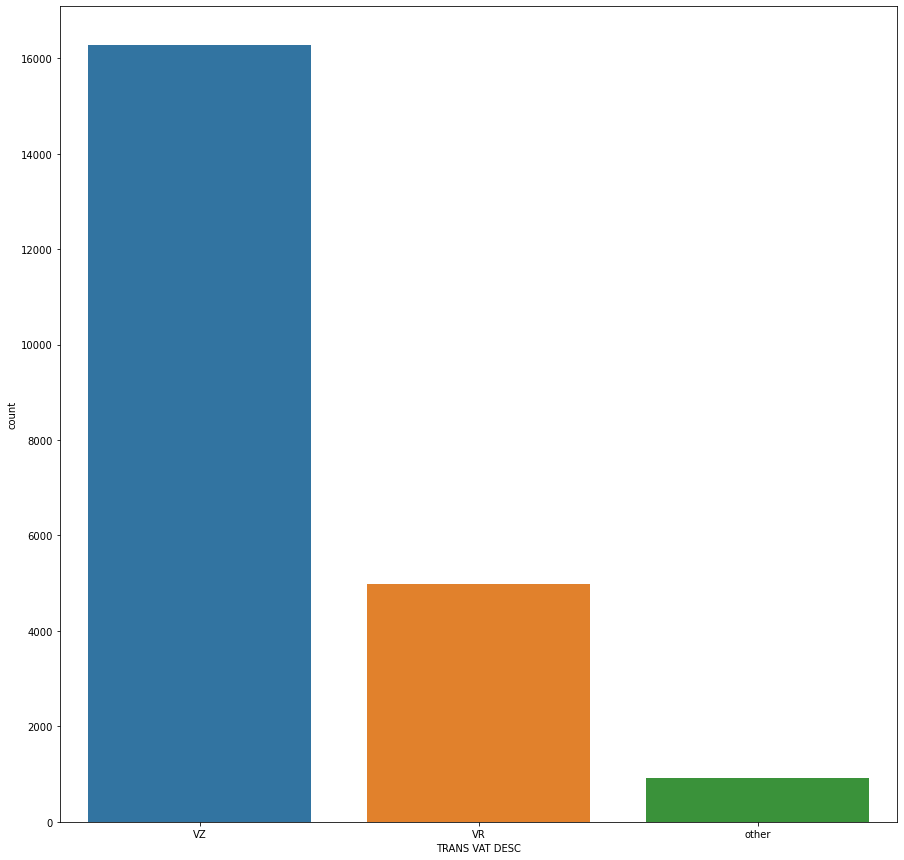

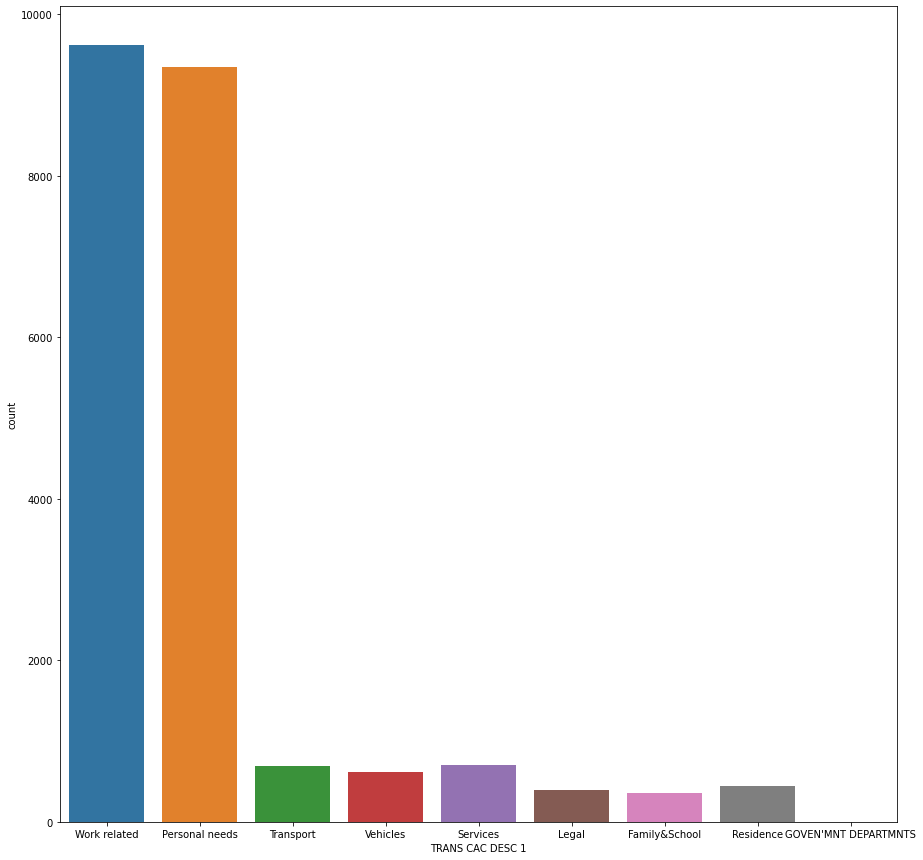

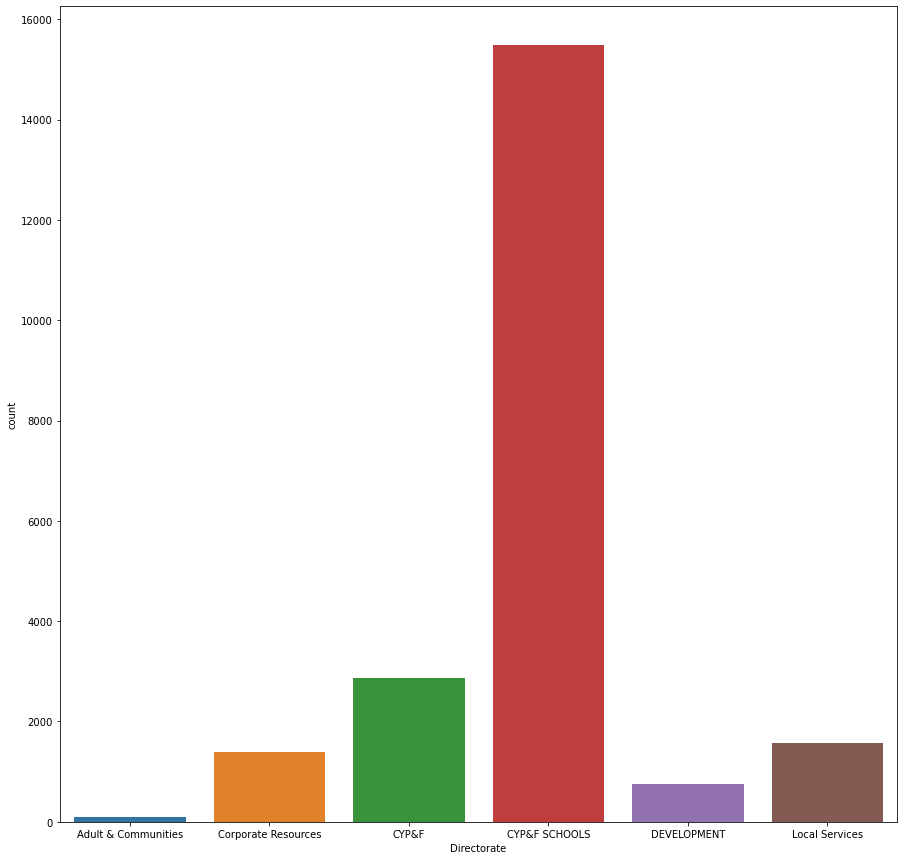

In [452]:
analyze_cluster(features,df2014_kmodes2,0)

Profiling transactions

<b>Cluster 0:</b> These are transactions mainly with zero Value added tax, related to work and personal needs. Are involved with the CY&PF directorate.

We analyze cluster 1:

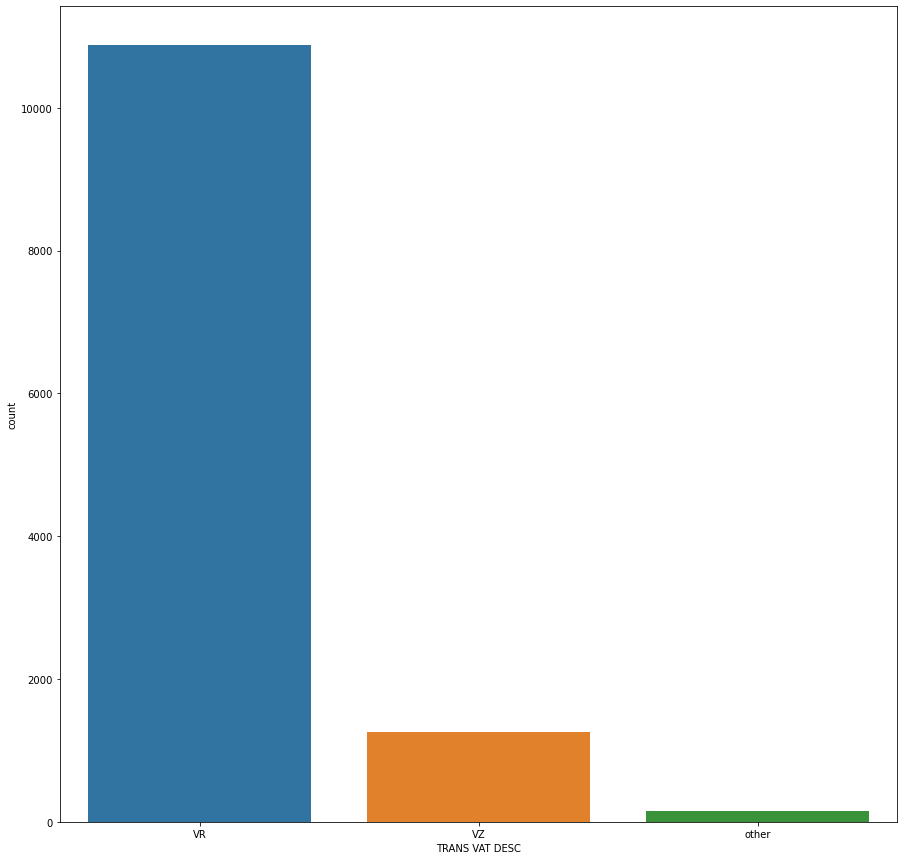

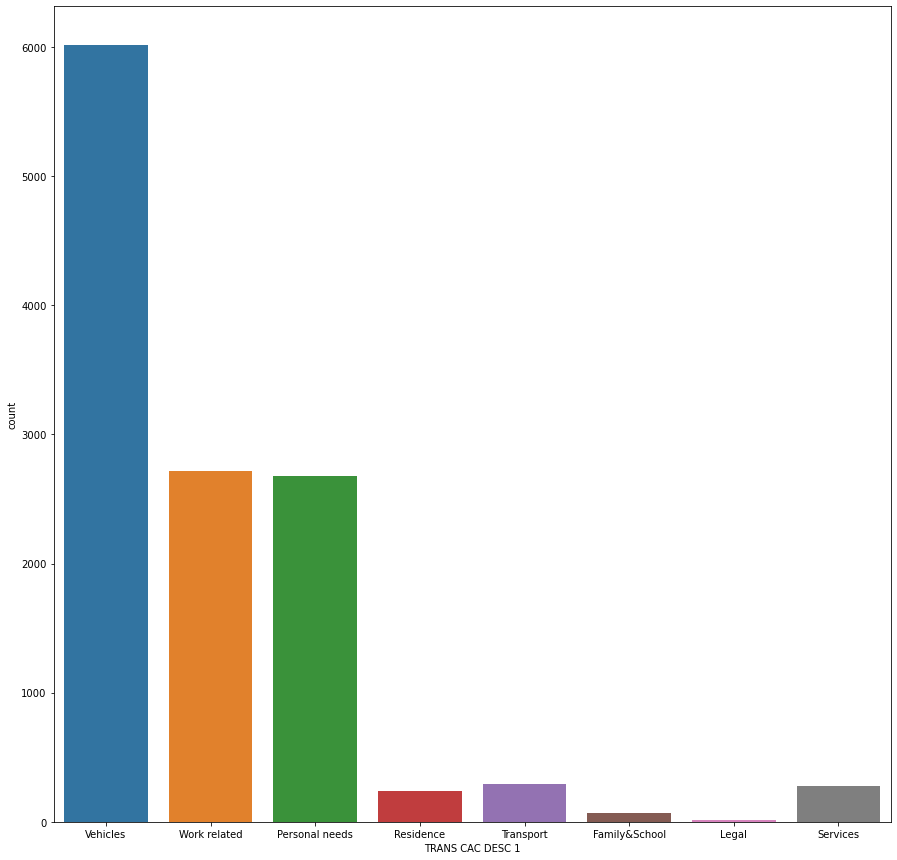

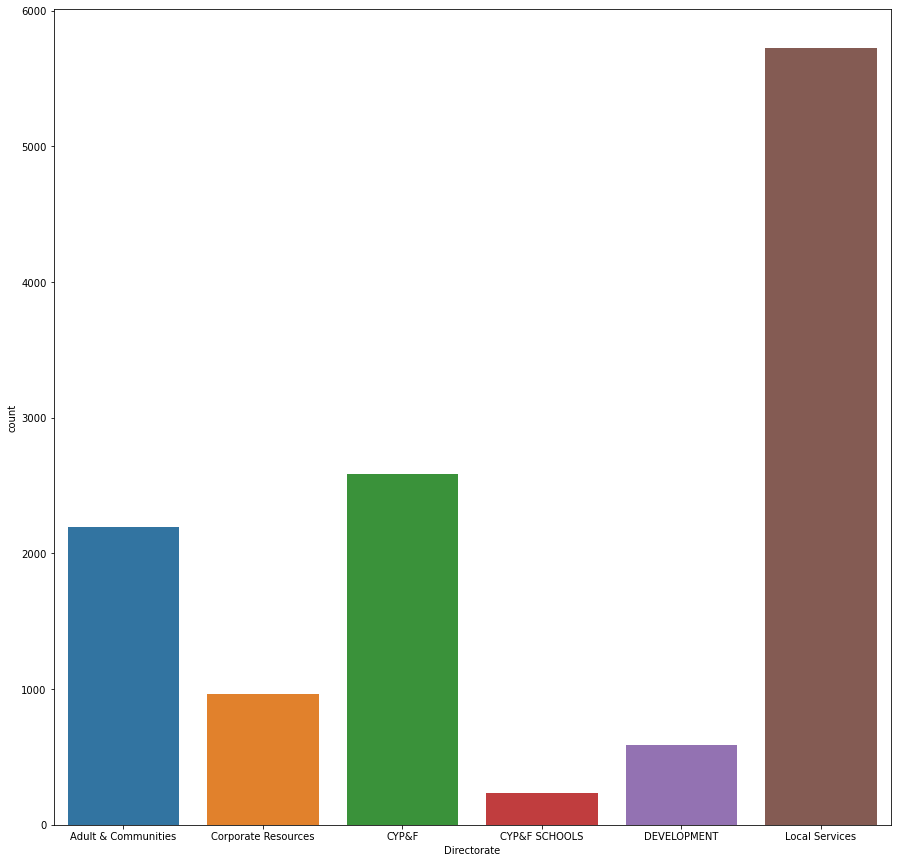

In [453]:
analyze_cluster(features,df2014_kmodes2,1)

Profiling transactions

<b>Cluster 1:</b> These are transactions mainly with standard Value added tax, related in a high percentage to vehicles. Much less about work and personal needs. Are involved mainly with local services.

### Now we profile the clusters that came out from k-modes where k=8.

In [454]:
df2014_kmodes8.columns

Index(['TRANS VAT DESC', 'ORIGINAL GROSS AMT', 'MERCHANT NAME', 'CARD NUMBER',
       'BILLING CUR CODE', 'TRANS CAC CODE 1', 'TRANS CAC DESC 1',
       'TRANS CAC CODE 2', 'TRANS CAC DESC 2', 'TRANS CAC CODE 3',
       'Directorate', 'kmodes_cluster'],
      dtype='object')

We analyze cluster 0:

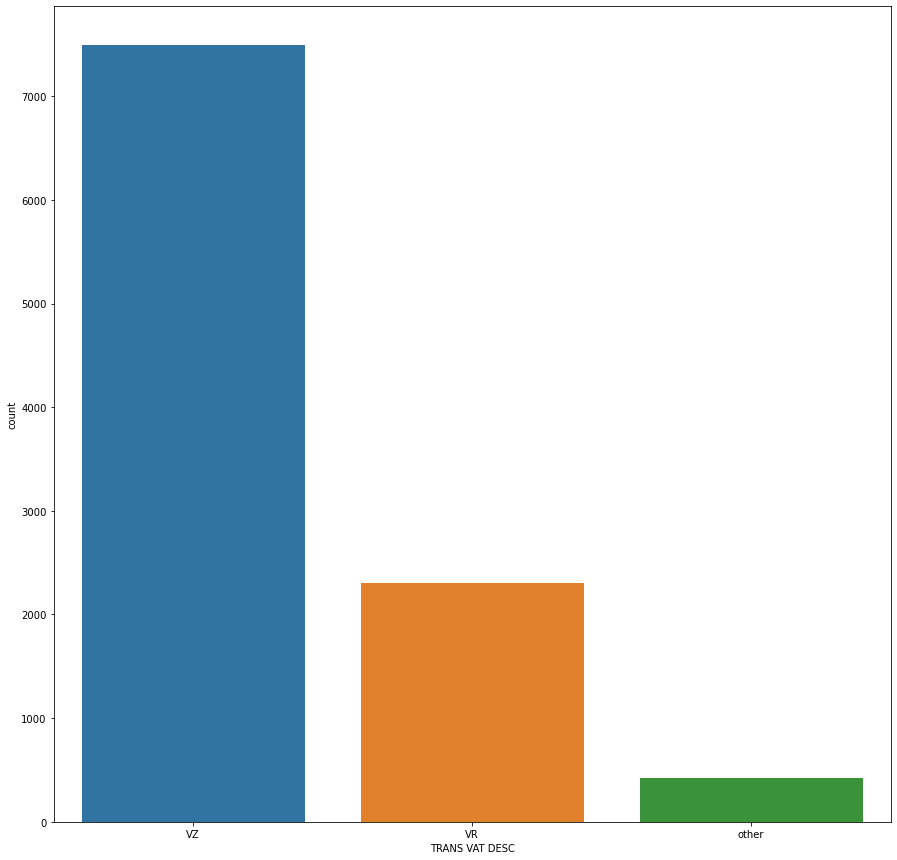

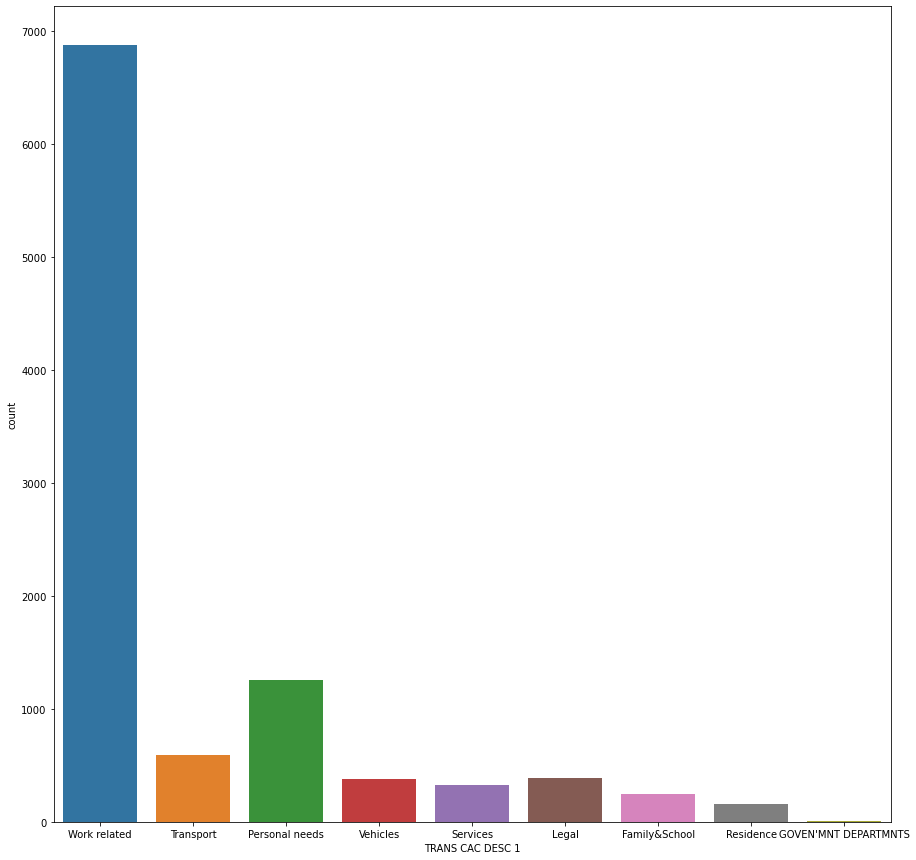

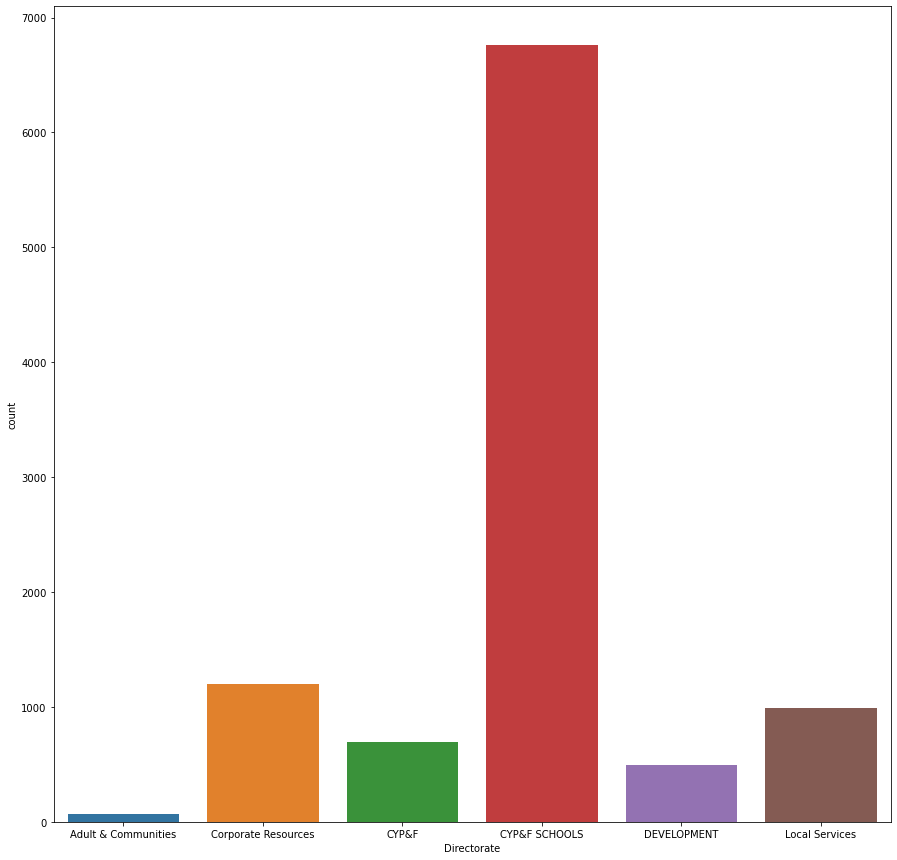

In [455]:
analyze_cluster(features,df2014_kmodes8,0)

Profiling transactions

<b>Cluster 0:</b> These are transactions mainly with standard Value added tax, related to work. Are involved with the CY&PF Schools directorate.

We analyze cluster 1:

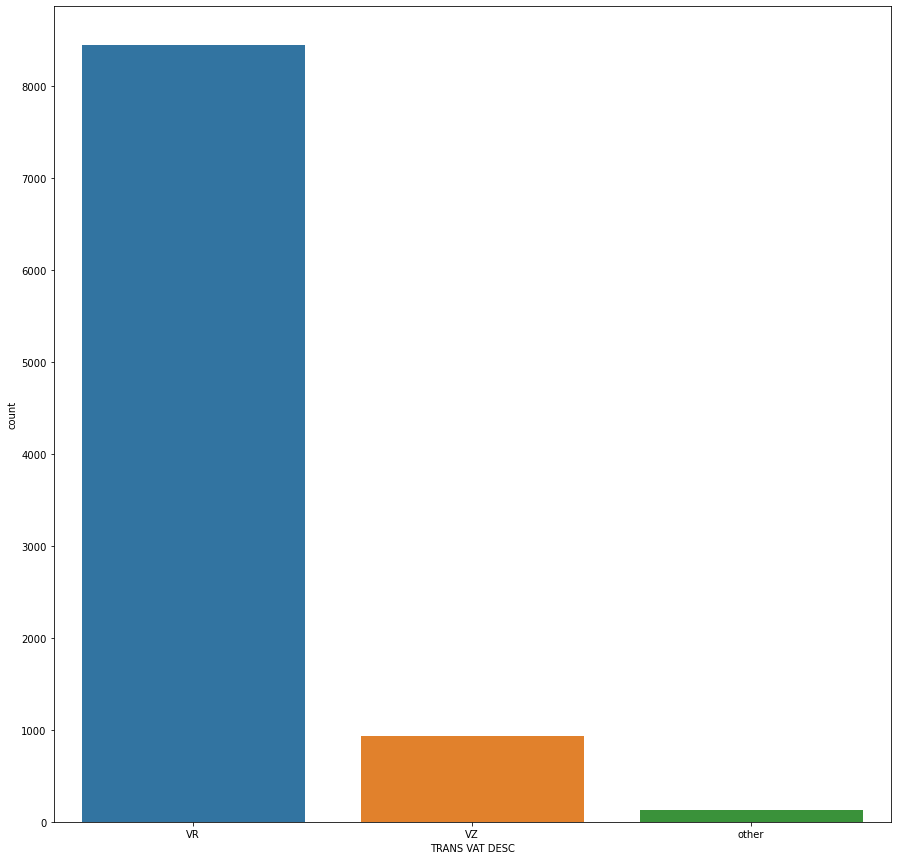

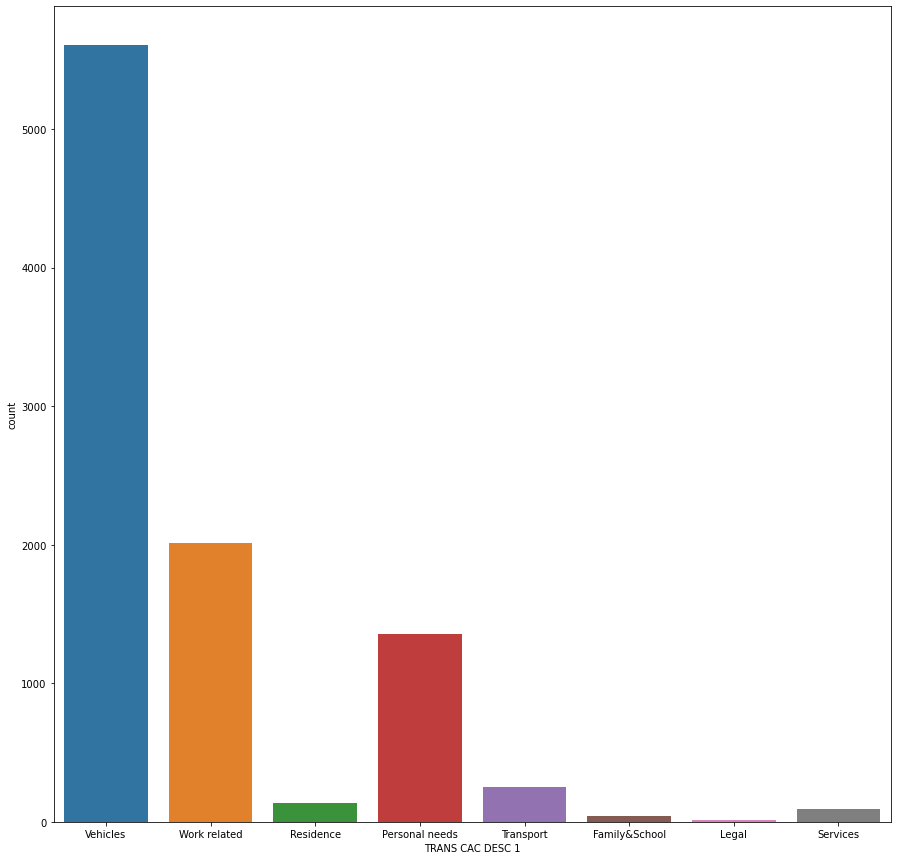

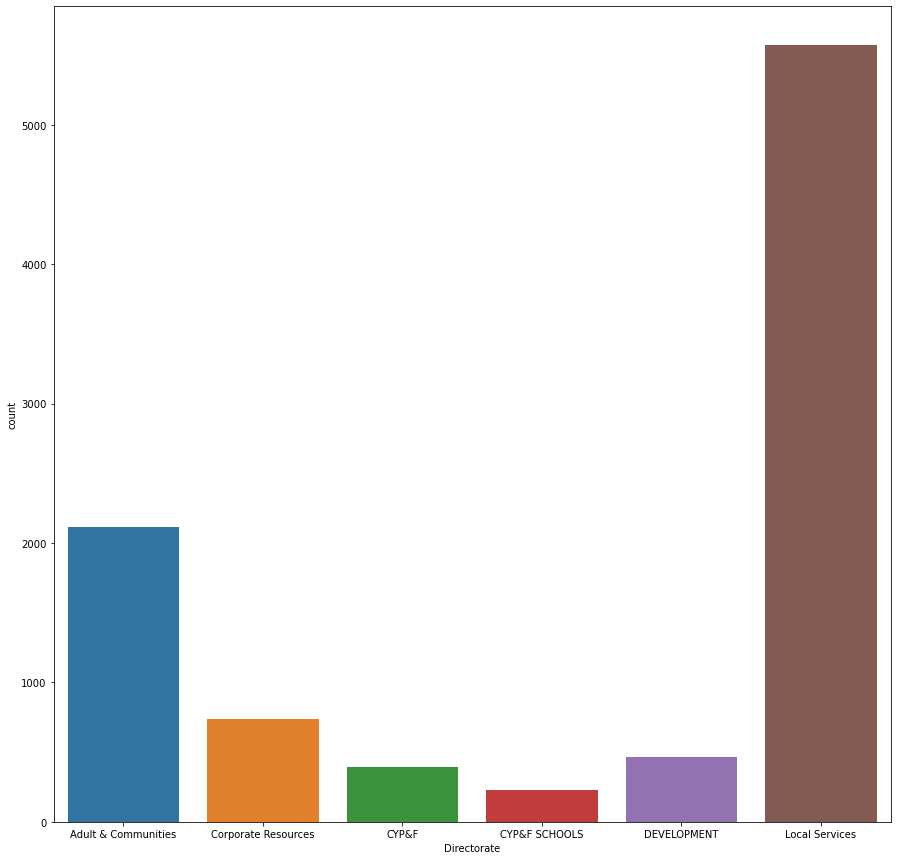

In [456]:
analyze_cluster(features,df2014_kmodes8,1)

Profiling transactions

<b>Cluster 1:</b> These are transactions with standard Value added tax, related to vehicles. Are involved with the local services directorate. A bit about Adult & Communities.

We analyze cluster 2:

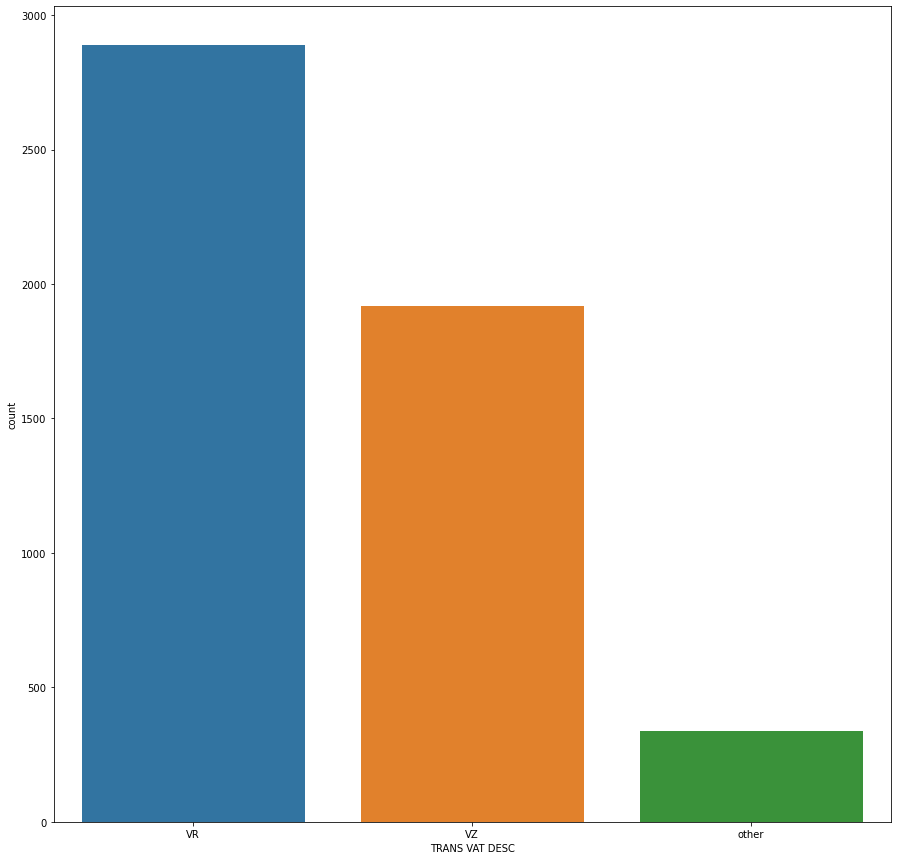

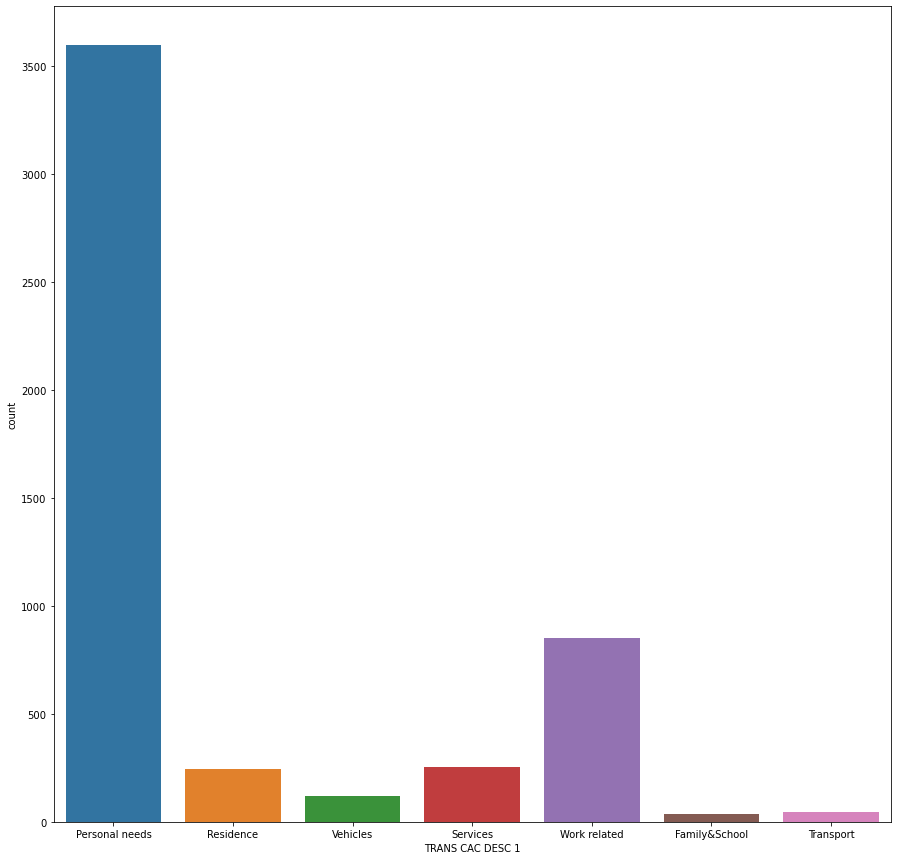

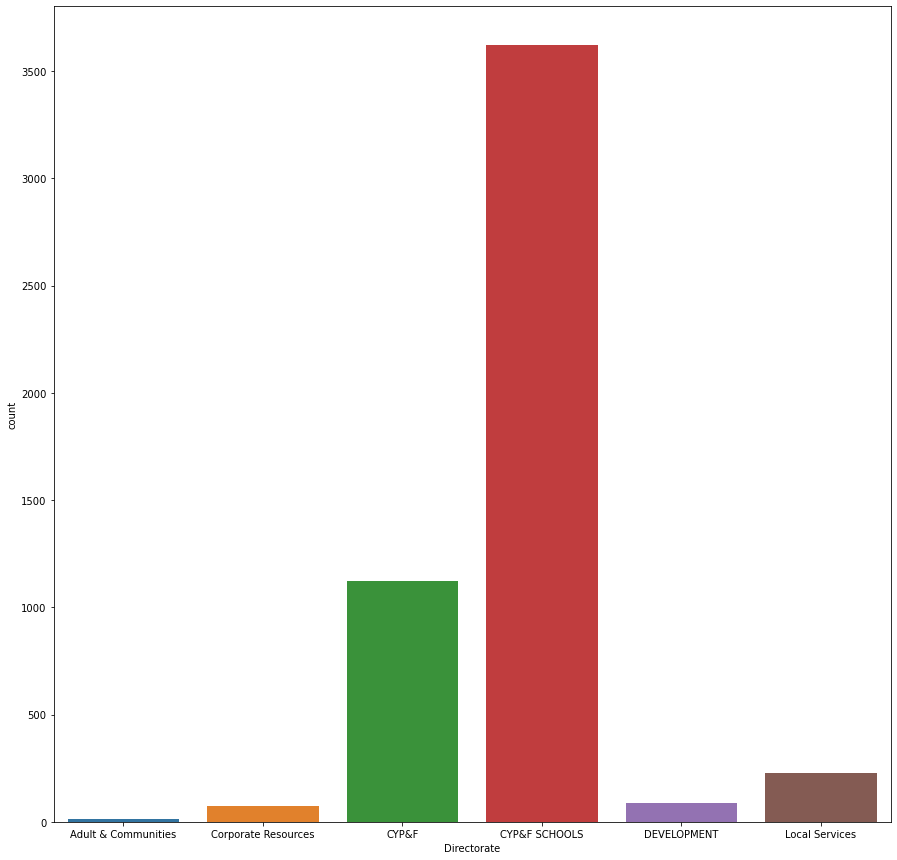

In [458]:
analyze_cluster(features,df2014_kmodes8,2)

Profiling transactions

<b>Cluster 2:</b> These are transactions with standard Value added tax and some considerable amount of zero value added tax. Are related to personal needs. Are involved with the CY&PF Schools directorate.

We analyze cluster 3:

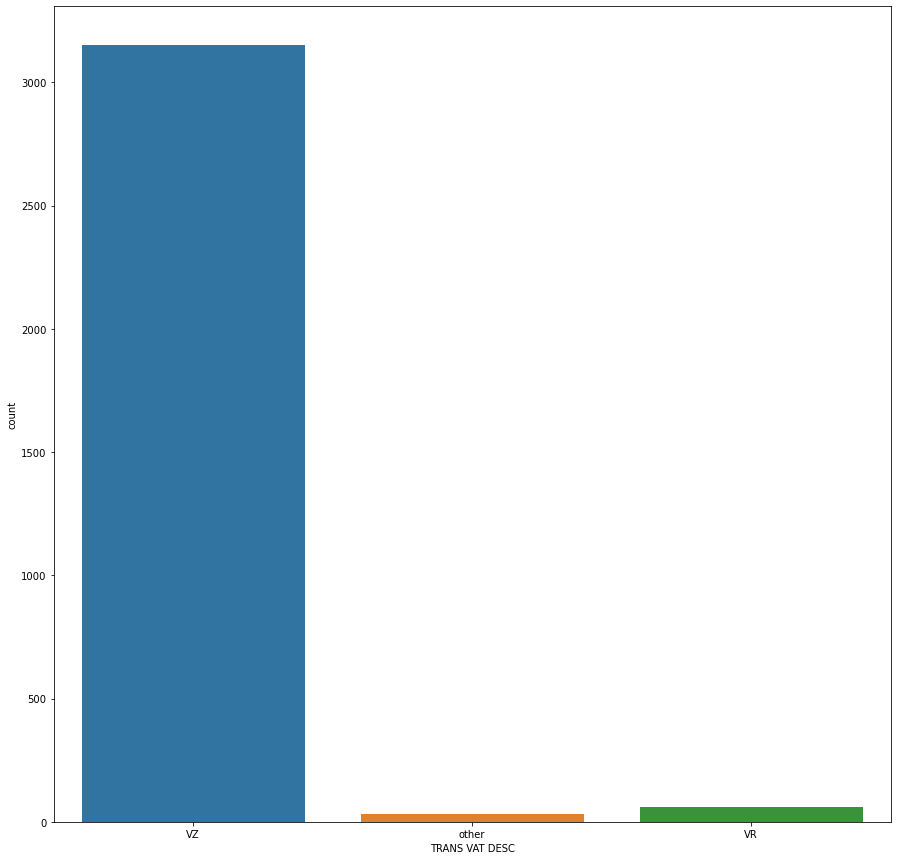

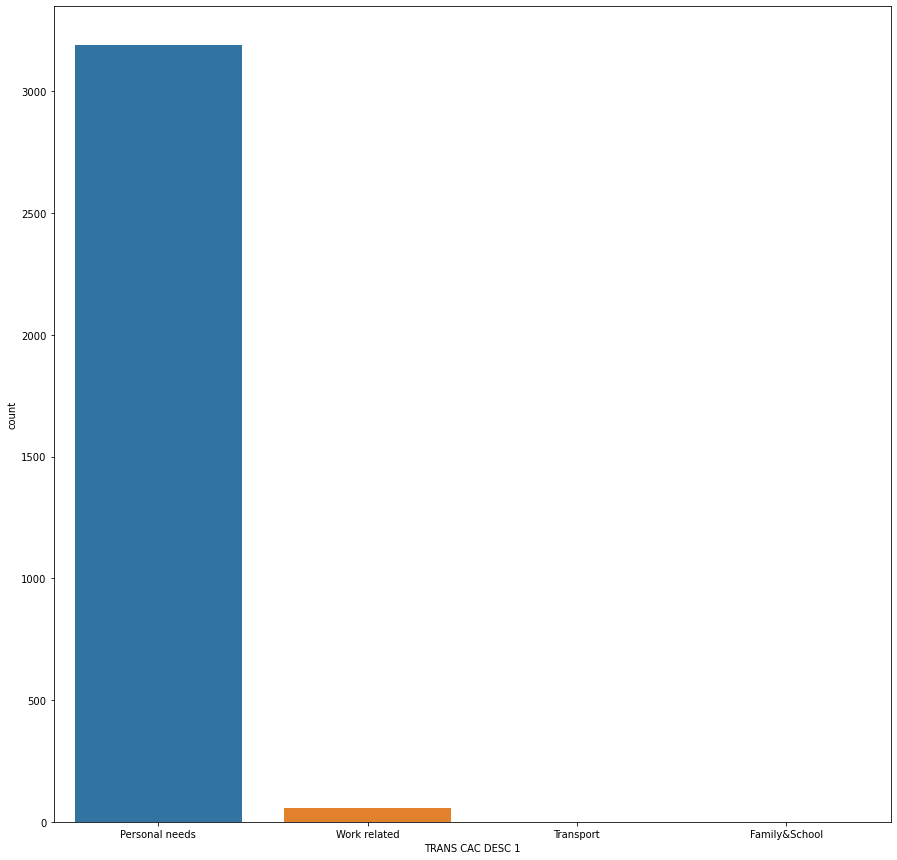

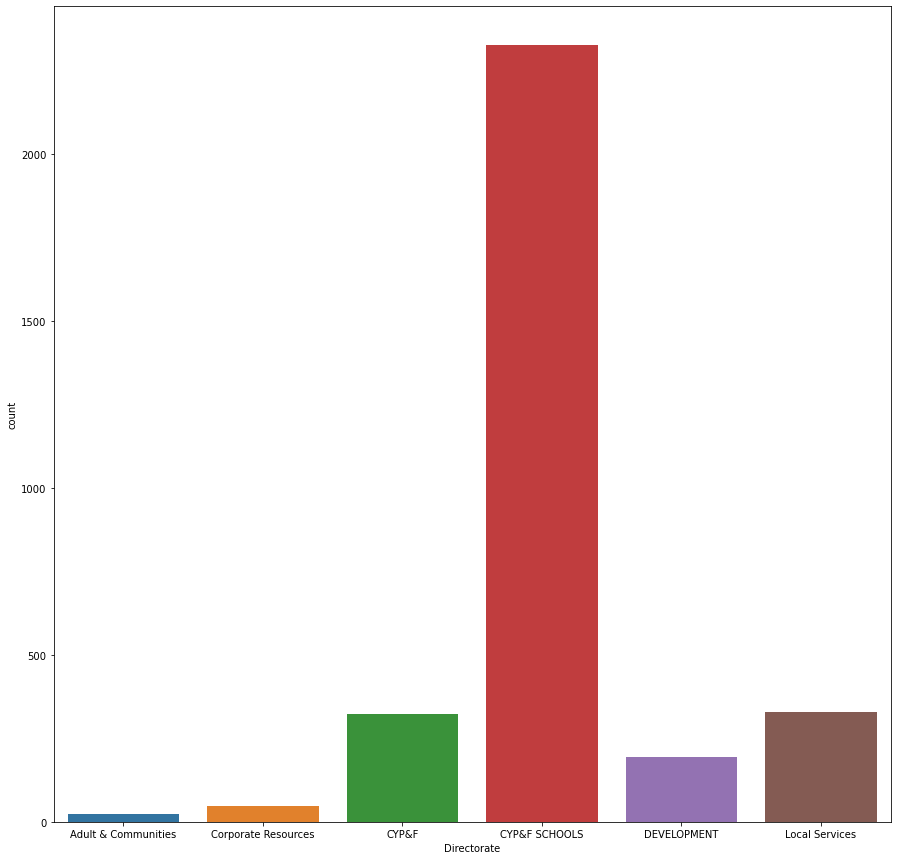

In [459]:
analyze_cluster(features,df2014_kmodes8,3)

Profiling transactions

<b>Cluster 3:</b> These are transactions with zero Value added tax, related to personal needs. Are involved with the CY&PF Schools directorate.

We analyze cluster 4:

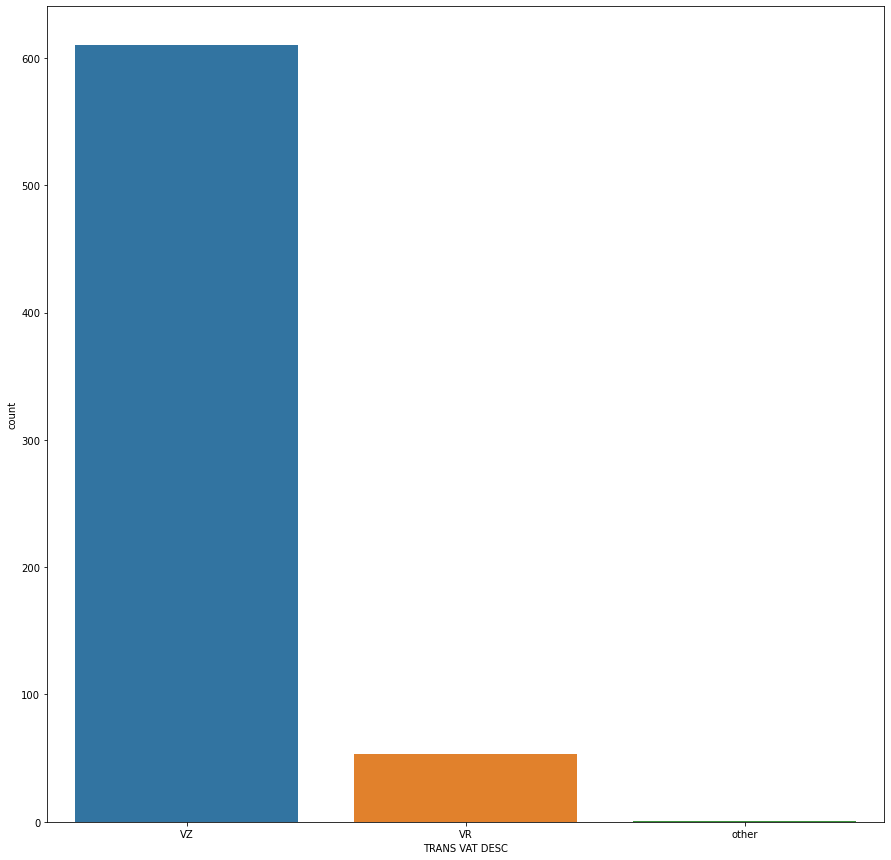

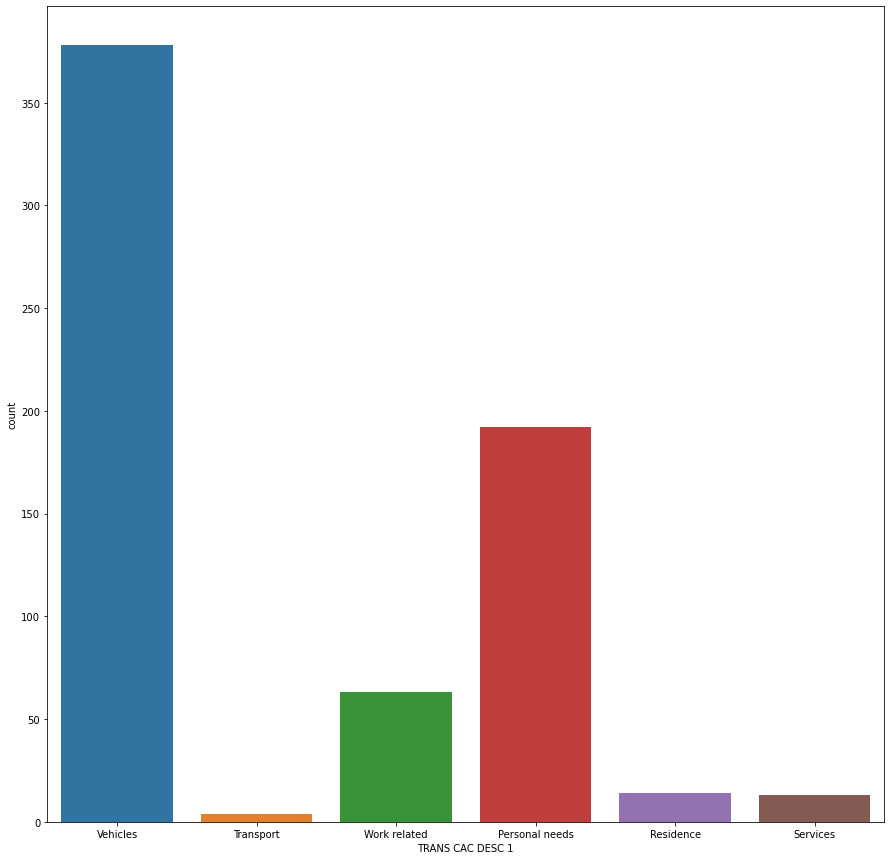

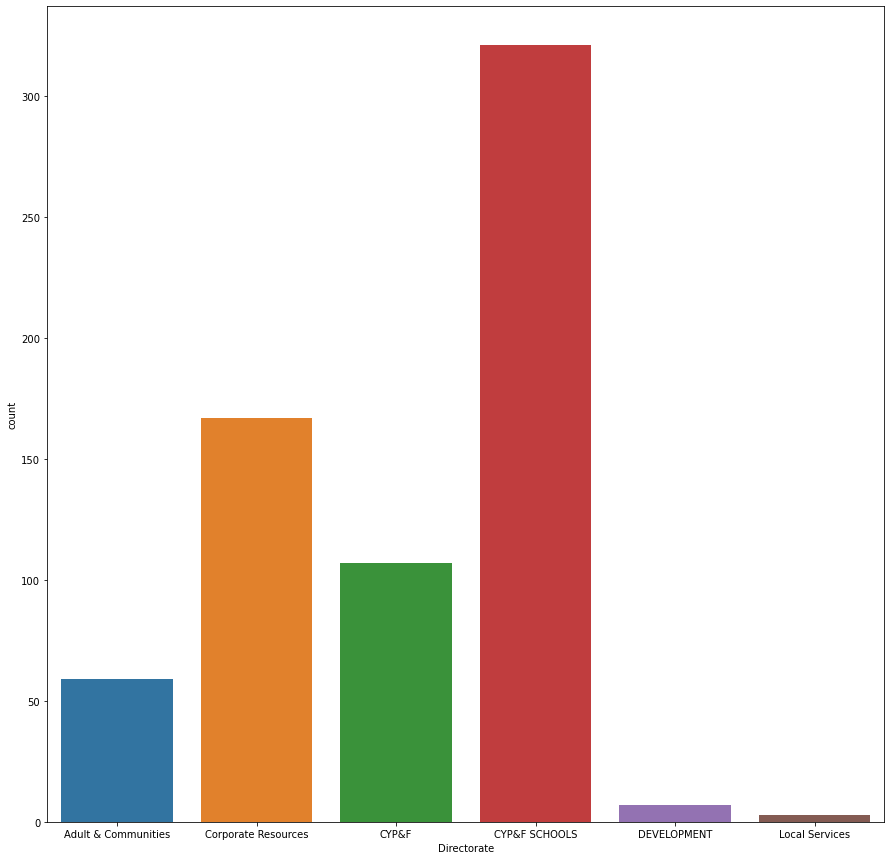

In [462]:
analyze_cluster(features,df2014_kmodes8,4)

Profiling transactions

<b>Cluster 4:</b> These are transactions with zero Value added tax, related to vehicles and a considerable amount of personal needs purchases. Are involved with the CY&PF Schools and Corporate Resources directorates.

We analyze cluster 5:

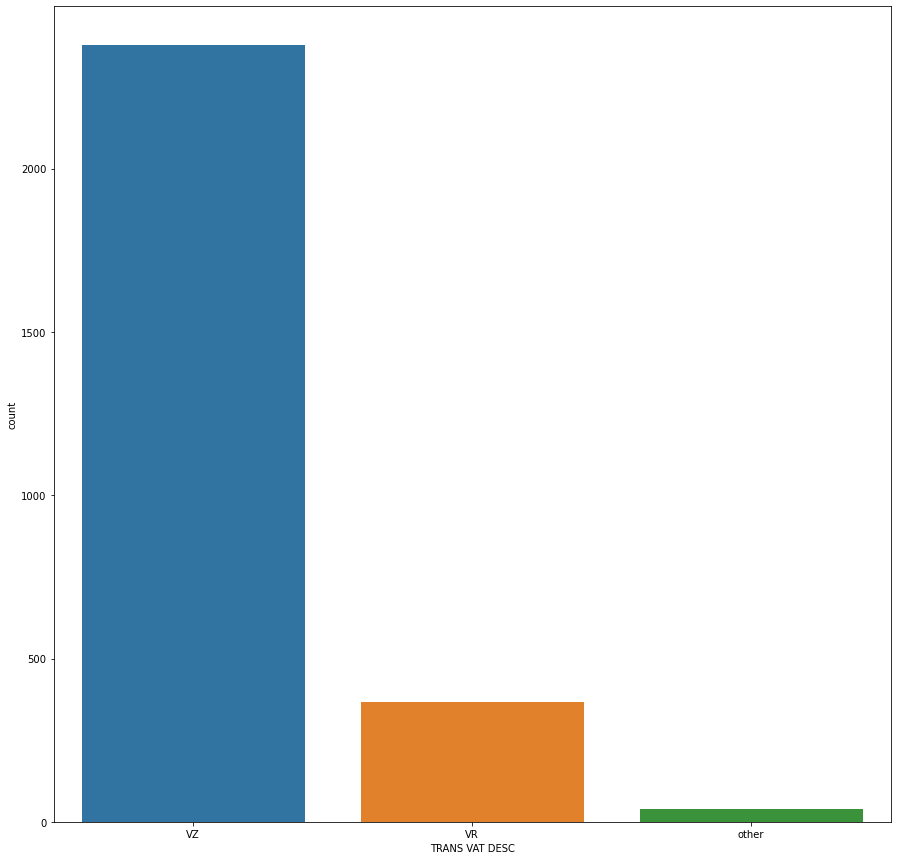

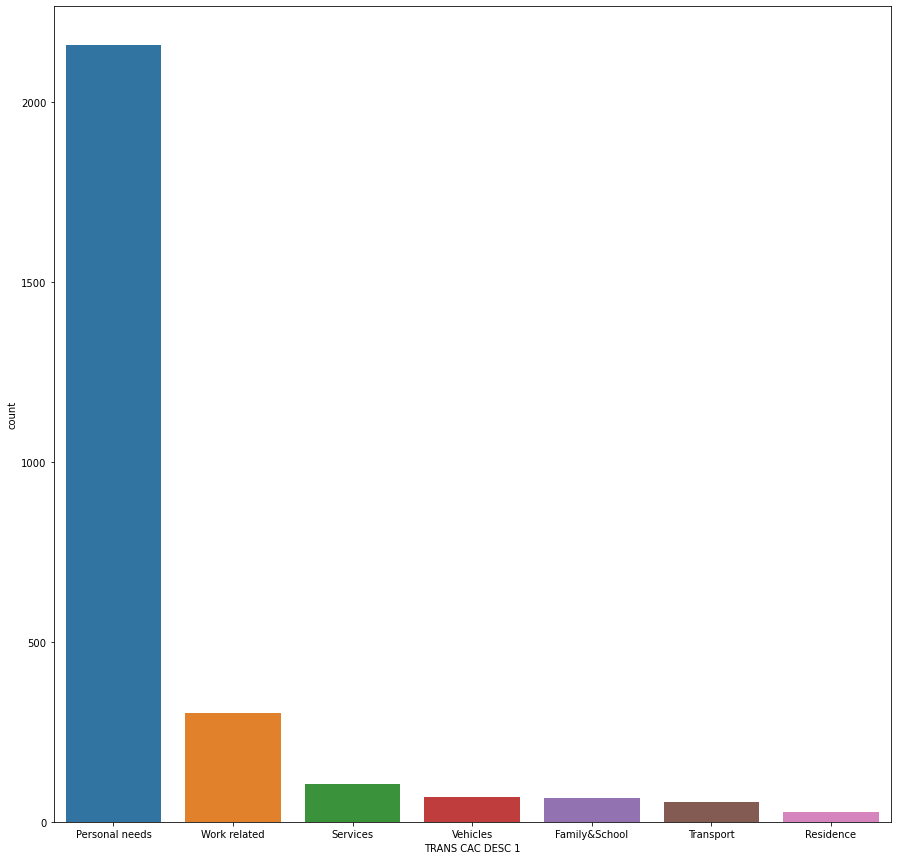

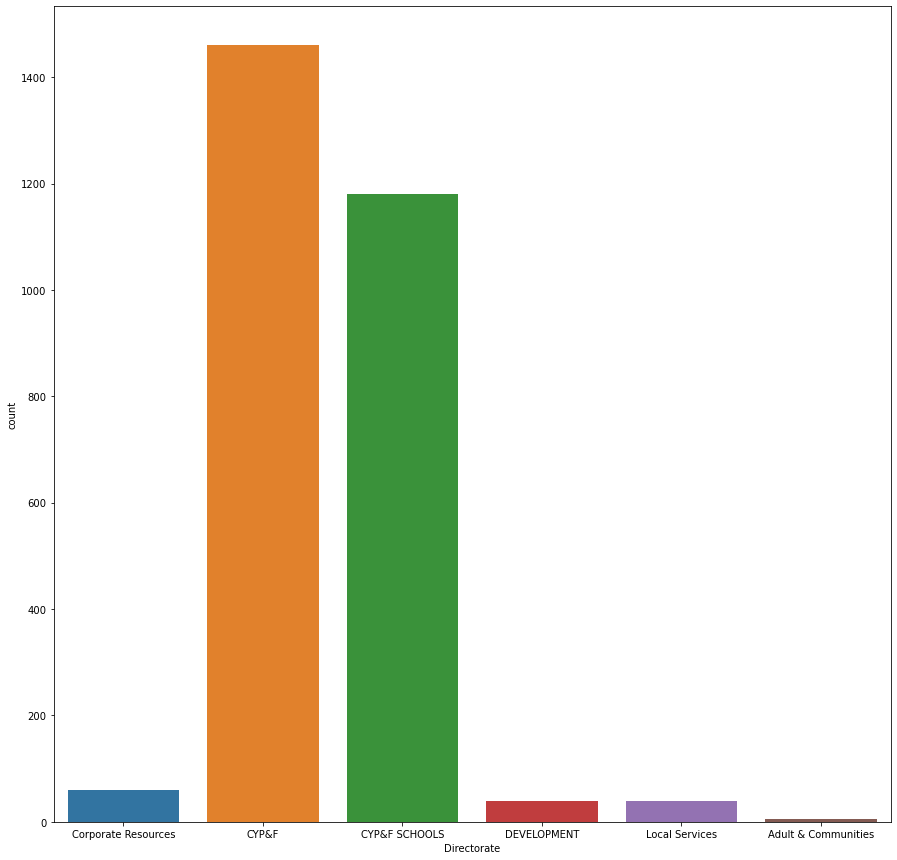

In [463]:
analyze_cluster(features,df2014_kmodes8,5)

Profiling transactions

<b>Cluster 5:</b> These are transactions with zero Value added tax, related to personal needs. Are involved with the CY&PF Schools and CY&PF directorates.

We analyze cluster 6:

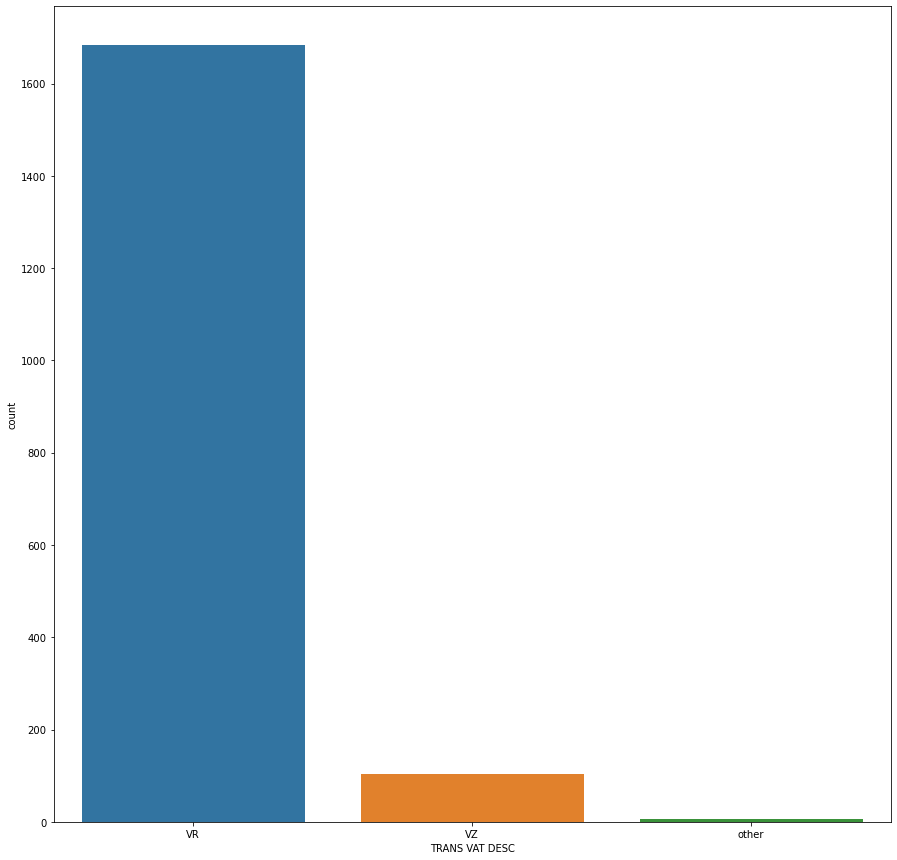

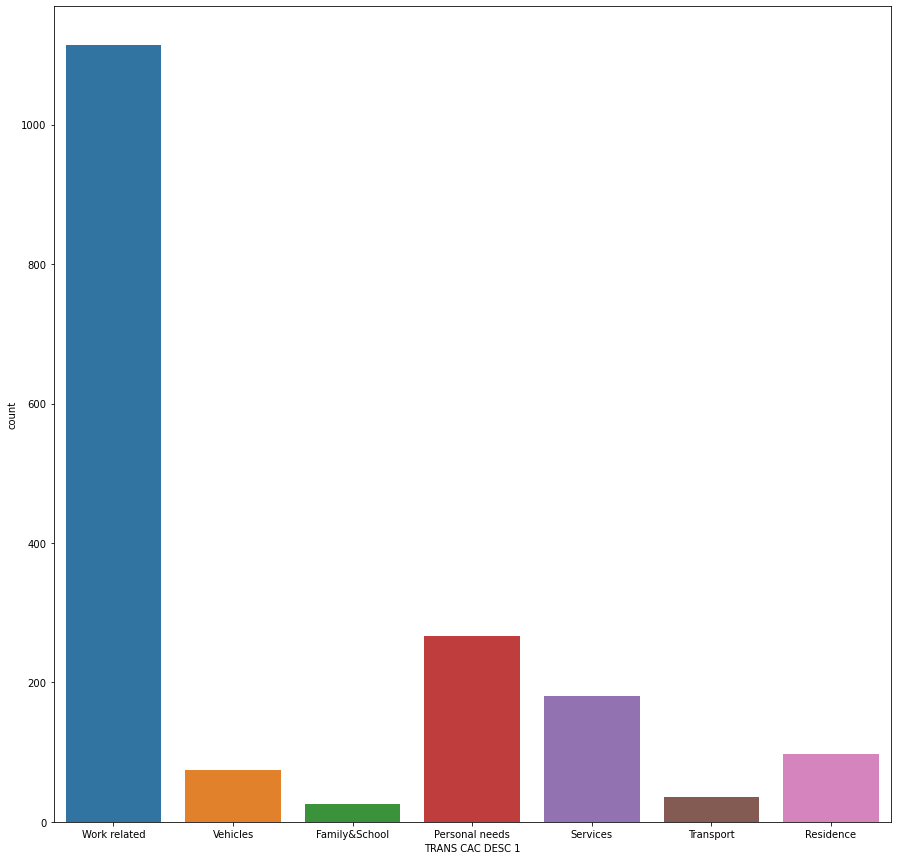

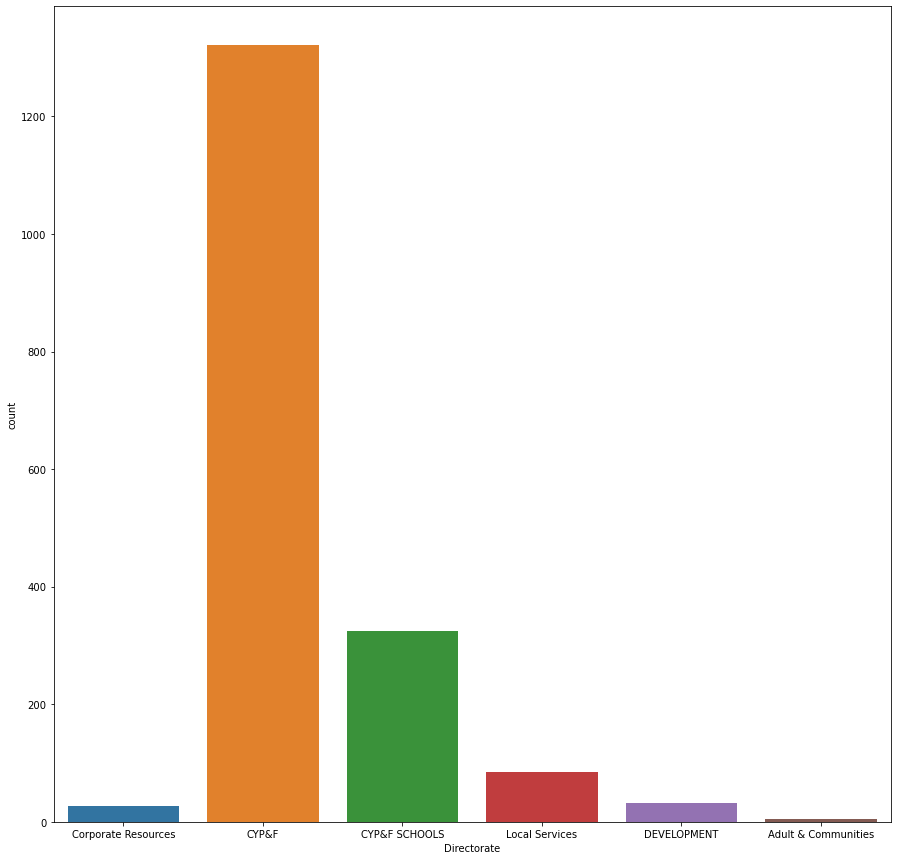

In [464]:
analyze_cluster(features,df2014_kmodes8,6)

Profiling transactions

<b>Cluster 6:</b> These are transactions with standard Value added tax, work related and some personal needs and services purchases. Are involved with the CY&PF directorate.

We analyze cluster 7:

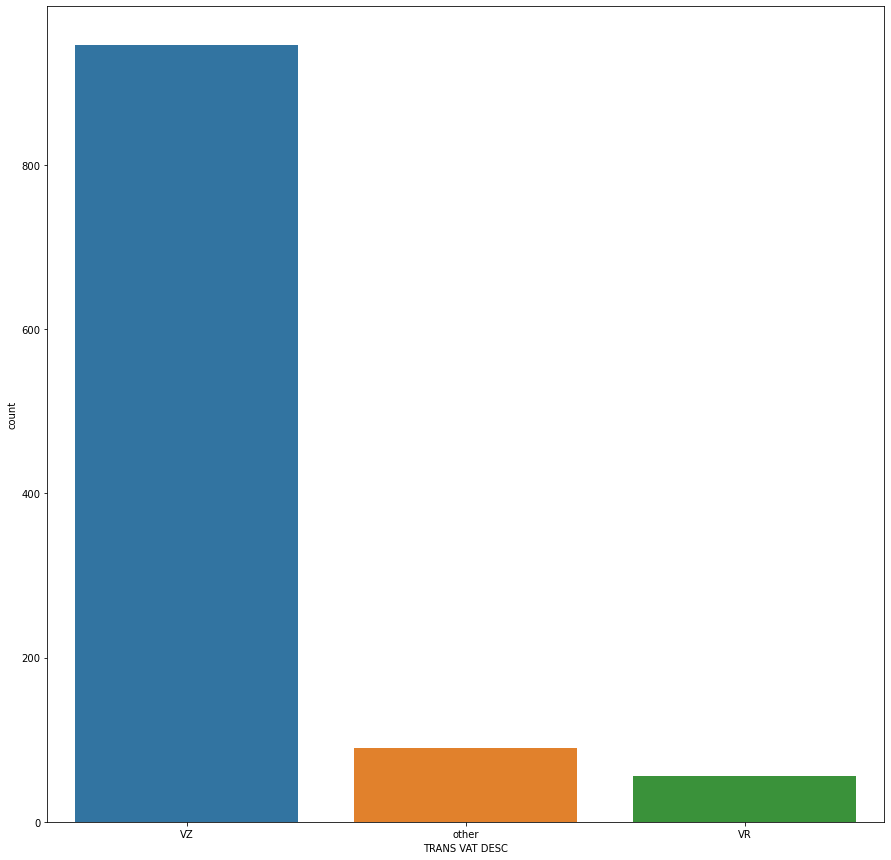

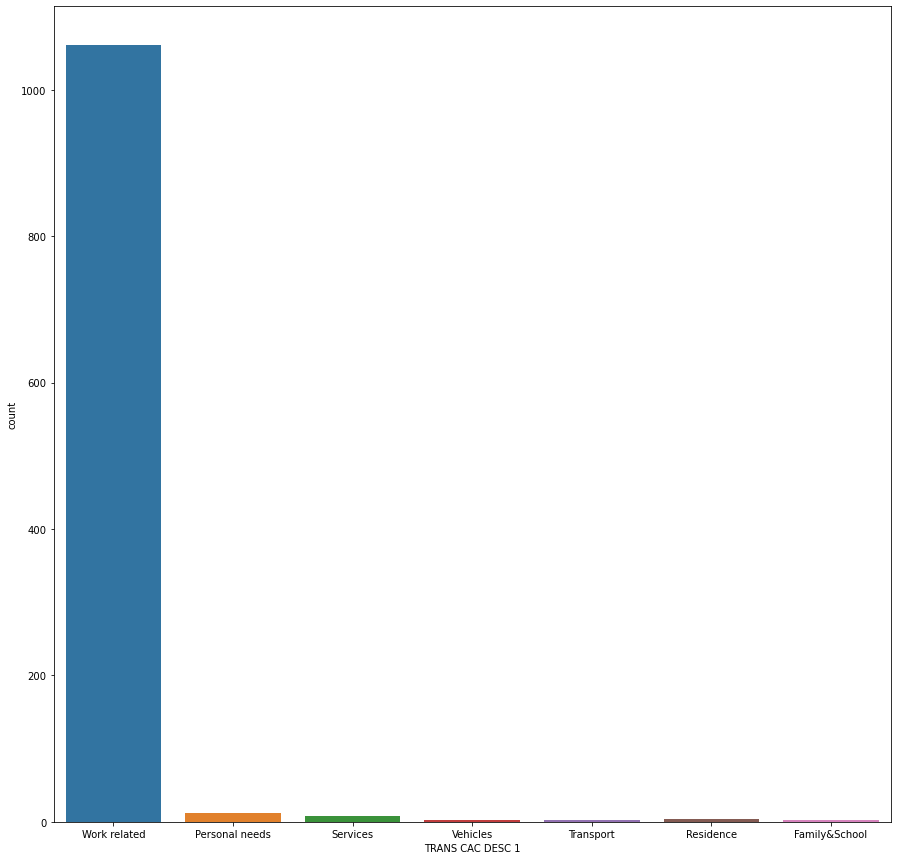

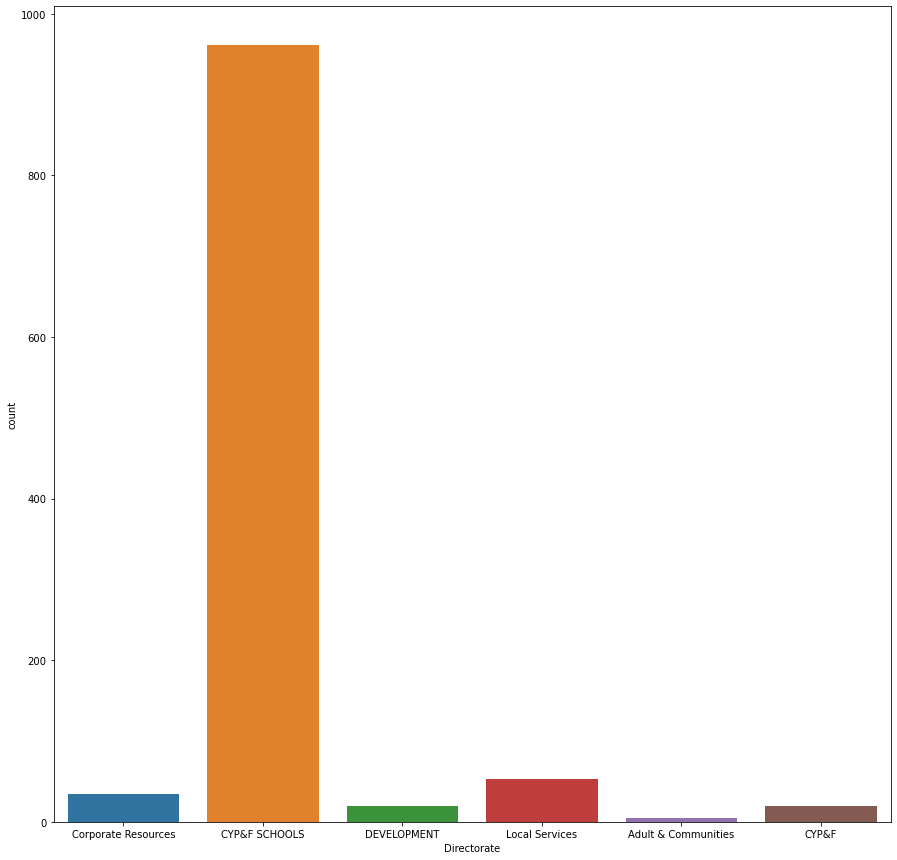

In [465]:
analyze_cluster(features,df2014_kmodes8,7)

Profiling transactions

<b>Cluster 7:</b> These are transactions with zero Value added tax, work related. Are involved with the CY&PF Schools directorate.